# Setup env and install requirements


In [ ]:
!pip install dash
!pip install dwave-system
!pip install dwave-hybrid
!pip install dimod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.7/18.7 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.7/223.7 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.6/305.6 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 2.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import networkx as nx
from matplotlib.gridspec import GridSpec
import matplotlib.colors as colors
from sklearn.preprocessing import LabelEncoder
import itertools
import dimod
from dwave.system import DWaveSampler, FixedEmbeddingComposite
from minorminer.busclique import find_clique_embedding
from hybrid.reference.kerberos import KerberosSampler
import time
from datetime import datetime
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import random
from itertools import combinations

In [ ]:
!dwave config create --full    # DEV-49c85af23caf299303d14889afaa960c6204a821 #DEV-d6aa56372e3eb12fedaff94bfe06acaf8dc633fe

Creating new configuration file: /root/.config/dwave/dwave.conf
Confirm configuration file path [/root/.config/dwave/dwave.conf]: 
Profile [defaults]: 
Updating existing profile: defaults
Solver API region (na-west-1, eu-central-1) [skip]: 
Solver API endpoint URL (overwrites 'region') [skip]: 
Solver API token [skip]: DEV-49c85af23caf299303d14889afaa960c6204a821
Client class (base, qpu, sw, hybrid) [skip]: 
Solver [skip]: 
Configuration saved.


In [ ]:
def sub_plot(size, small, big, x, subtitles, y, *y2):
    gs = GridSpec(big + 1, small)
    plt.figure(figsize=size)
    for i in range(small):
        ax = 'ax_' + str(i)
        ax = plt.subplot(gs[0, i])
        ax.set_title(subtitles[i])
        if y2:
            ax.plot(x, y2[0]['out'].values, 'ro')
            ax.plot(x, y[y.columns[i]].values, 'bv')
            ax.legend(["out", "model"])
        else:
            ax.plot(x, y[y.columns[i]].values)

    if big:
        axy = plt.subplot(gs[1, :])
        i += 1
        axy.set_title(y.columns[i])
        axy.plot(x, y[y.columns[i]].values, 'r')
    return plt

def plot_toy_signals(df):
    sub_plot((10, 8), 3, True, np.linspace(-np.pi, np.pi, len(df)), df.columns, df)
    plt.suptitle("Toy Problem: System Inputs and Output", fontsize=15)

def plot_two_var_model(df1, df2):
    subtitles = ["Modeling %s and %s" % f0f1 for f0f1 in df1.columns]
    sub_plot((12, 4), 3, 0, np.linspace(-np.pi, np.pi, len(df1)), subtitles, df1, df2)
    plt.suptitle("Toy Problem: Output Vesus Two-Signal Model", fontsize=15)

def plot_lingress(df, toy):
    subtitles = ["%s correlation coefficient: %.2f" % var_rval for var_rval in df.columns]
    sub_plot((12, 4), 3, 0, np.linspace(-np.pi, np.pi, len(df)), subtitles, df, toy)
    plt.suptitle("Toy Problem: Linear Regression", fontsize=15)

# Warning since 0.24.2
#def plot_se(data):
#    pd.DataFrame(data).plot(x='Bins', y=['Maximum', 'Uniform', 'Exp', 'Vals'], style = [ 'ro','b', 'g', 'y'])
#    plt.title("Shannon Entropy")
#    plt.ylabel("Entropy")
def plot_se(data):
    df = pd.DataFrame(data)
    plt.figure(figsize=(5, 4))
    plt.plot(df[['Bins']].values, df[['Maximum']].values, 'ro',
             df[['Bins']].values, df[['Uniform']].values, 'b',
             df[['Bins']].values, df[['Exp']].values, 'g',
             df[['Bins']].values, df[['Vals']].values, 'y')
    plt.title("Shannon Entropy")
    plt.xlabel("Bins")
    plt.ylabel("Entropy")
    plt.legend(['Maximum', 'Uniform', 'Exp', 'Vals'])

def plot_mi(scores):
    if len(scores) > 5:
        plt.figure(figsize=(8, 5))
    else:
        plt.figure(figsize=(4, 4))
    labels, values = zip(*sorted(scores.items(), key=lambda pair: pair[1], reverse=True))
    plt.bar(np.arange(len(labels)), values)
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.bar(np.arange(len(labels)), values)
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.title("Mutual Information")
    plt.ylabel("MI with Variable of Interest")

def plot_solutions(result):
    features = []
    energies = []
    for sample, energy in result.data(['sample', 'energy']):
        energies.append(energy)
        features.append([key for (key, value) in sample.items() if value == 1])
    plt.figure(figsize=(4, 4))
    plt.bar(np.arange(len(features)), energies)
    plt.xticks(np.arange(len(features)), features, rotation=90)
    plt.title("Toy Problem: Unconstrained Solution")
    plt.ylabel("Energy")

def plot_features(features, selected_features):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_axes([0.1, 0.3, .9, .7])
    ax.set_title("Best Feature Selection")
    ax.set_ylabel('Number of Selected Features')
    ax.set_xticks(np.arange(len(features)))
    ax.set_xticklabels(features, rotation=90)
    ax.set_yticks(np.arange(len(features)))
    ax.set_yticklabels(np.arange(1, len(features)+1))
    # Set a grid on minor ticks
    ax.set_xticks(np.arange(-0.5, len(features)), minor=True)
    ax.set_yticks(np.arange(-0.5, len(features)), minor=True)
    ax.grid(which='minor', color='black')
    ax.imshow(selected_features, cmap=colors.ListedColormap(['white', 'red']))



def plot_bqm(bqm):
    """Plot binary quadratic model as a labeled graph."""
    g = nx.Graph()
    g.add_nodes_from(bqm.variables)
    g.add_edges_from(bqm.quadratic)

    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax.set_title(f"BQM with {len(bqm)} nodes and {len(bqm.quadratic)} edges")
    nx.draw_circular(g, with_labels=True, node_size=3000, node_color="y")
    plt.show()

def plot_feature_selection(features, selected_features):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_axes([0.1, 0.3, .9, .7])
    ax.set_title("Best Feature Selection")
    ax.set_ylabel('Number of Selected Features')
    ax.set_xticks(np.arange(len(features)))
    ax.set_xticklabels(features, rotation=90)
    ax.set_yticks(np.arange(len(features)))
    ax.set_yticklabels(np.arange(1, len(features)+1))
    # Set a grid on minor ticks
    ax.set_xticks(np.arange(-0.5, len(features)), minor=True)
    ax.set_yticks(np.arange(-0.5, len(features)), minor=True)
    ax.grid(which='minor', color='black')
    ax.imshow(selected_features, cmap=colors.ListedColormap(['white', 'red']))



# Data Loader


Import Bike Sharing System Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Predict BSS/Bike share ridership 2023-01.csv')
df_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Predict BSS/Bike share ridership 2023-02.csv')
#df_8_9 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Predict BSS/8_9.xlsx')
#df_10_12 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Predict BSS/10_12.xlsx')
df_original = pd.concat([df_1, df_2], ignore_index=True)
print(df_original.shape)


# Check if the CSV file already exists
filename_csv_results = '/content/drive/MyDrive/Colab Notebooks/Predict BSS/Result_feature_selection/rmse_records.csv'

## Wine quality dataset
df_wine = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Predict BSS/wineQuality.csv')
## insurance dataset
df_insurance = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Predict BSS/insurance.csv')
df_insurance['sex'] = df_insurance['sex'].replace({'male': 0, 'female': 1})
df_insurance['smoker'] = df_insurance['smoker'].replace({'no': 0, 'yes': 1})
region_dummies = pd.get_dummies(df_insurance['region'], prefix='region', drop_first=True)
df_insurance = pd.concat([df_insurance, region_dummies], axis=1)
df_insurance.drop('region', axis=1, inplace=True)
## obesity
df_obesity = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Predict BSS/Obesity.csv')
df_obesity = df_obesity.dropna(subset=['Data_Value'])

(352911, 10)


In [ ]:
df_original

Trip Id  Trip  Duration  Start Station Id        Start Time  \
0       20148784             840              7022  01/01/2023 00:00   
1       20148785             722              7399  01/01/2023 00:01   
2       20148786            1054              7269  01/01/2023 00:02   
3       20148790            1329              7721  01/01/2023 00:04   
4       20148791            1291              7721  01/01/2023 00:04   
...          ...             ...               ...               ...   
352906  20554539            1024              7251  02/28/2023 23:57   
352907  20554542             134              7164  02/28/2023 23:59   
352908  20554543             686              7285  02/28/2023 23:59   
352909  20554544             197              7033  02/28/2023 23:59   
352910  20554545            1081              7620  02/28/2023 23:59   

                                  Start Station Name  End Station Id  \
0                             Simcoe St / Queen St W          7703.0   
1                       Lower Jarvis / Queens Quay E          7533.0   
2                    Toronto Eaton Centre (Yonge St)          7076.0   
3                                                NaN          7685.0   
4                                                NaN          7685.0   
...                                              ...             ...   
352906  The Royal Ontario Museum (Bloor St Entrance)          7061.0   
352907      Gould St / Yonge St (Ryerson University)          7389.0   
352908              Spadina Ave / Harbord St - SMART          7033.0   
352909                                 Union Station          7375.0   
352910                  Eglinton Ave E / Redpath Ave          7041.0   

                End Time                End Station Name  Bike Id  \
0       01/01/2023 00:14                             NaN     1770   
1       01/01/2023 00:13      Housey St / Dan Leckie Way     6400   
2       01/01/2023 00:20         York St / Queens Quay W     4068   
3       01/01/2023 00:26                             NaN      427   
4       01/01/2023 00:26                             NaN     1840   
...                  ...                             ...      ...   
352906  03/01/2023 00:15          Dalton Rd / Bloor St W     7258   
352907  03/01/2023 00:01  College Park- Gerrard Entrance     5337   
352908  03/01/2023 00:10                   Union Station     6272   
352909  03/01/2023 00:02           Front St E / Scott St     6536   
352910  03/01/2023 00:17            Edward St / Yonge St     2251   

            User Type  
0       Casual Member  
1       Casual Member  
2       Annual Member  
3       Casual Member  
4       Casual Member  
...               ...  
352906  Casual Member  
352907  Annual Member  
352908  Annual Member  
352909  Annual Member  
352910  Casual Member  

[352911 rows x 10 columns]

# Feature Engineering


In [ ]:
number_of_records = 300000 # Number of bike sharing ride
select_subset_of_features = True
number_of_features_to_select = 500
number_of_features_to_select_QC = 50
df = df_original.sample(n=number_of_records, random_state=42)

In [ ]:
df['Start Time'] = pd.to_datetime(df['Start Time'])
df_new = df
df['Week Number'] = df['Start Time'].dt.strftime('%U')
df_new['Week Number'] = df_new['Start Time'].dt.strftime('%U')
df_new['Is Weekend'] = df_new['Start Time'].dt.dayofweek.isin([5, 6])
df_new['Date'] = df_new['Start Time'].dt.date
df_new['Day_Number'] = df_new['Start Time'].dt.day
#df_new['Hour'] = df_new['Start Time'].dt.hour
df_new['Month'] = df_new['Start Time'].dt.month
df_new['AM_PM'] = df_new['Start Time'].dt.hour.apply(lambda x: 'AM' if x < 12 else 'PM')


In [ ]:
# Group by the specified columns and count the number of records in each group
grouped_df = df_new.groupby(['Start Station Id', 'Date', 'AM_PM']).size().reset_index(name='Total Users')
# Merge the aggregated DataFrame with the original DataFrame to keep all other columns
result_df = pd.merge(df_new, grouped_df, on=['Start Station Id', 'Date', 'AM_PM'], how='left')
result_df
#sorted_df = result_df.sort_values(by=['Start Station Id','Date'])
#sorted_df[sorted_df['Start Station Id'] == 7000]

Trip Id  Trip  Duration  Start Station Id          Start Time  \
0       20396849             333              7506 2023-02-07 18:35:00   
1       20352216             575              7375 2023-01-31 17:11:00   
2       20510609             485              7682 2023-02-20 13:58:00   
3       20351671              99              7265 2023-01-31 16:16:00   
4       20245673             616              7110 2023-01-15 17:08:00   
...          ...             ...               ...                 ...   
299995  20534096            1217              7430 2023-02-24 17:32:00   
299996  20466607             783              7542 2023-02-15 13:01:00   
299997  20272634            2257              7713 2023-01-19 03:59:00   
299998  20231694             365              7052 2023-01-12 17:36:00   
299999  20423323             477              7139 2023-02-10 23:52:00   

                         Start Station Name  End Station Id          End Time  \
0       Berkeley St / Adelaide St E - SMART          7462.0  02/07/2023 18:40   
1                     Front St E / Scott St          7506.0  01/31/2023 17:20   
2                                       NaN          7069.0  02/20/2023 14:06   
3       Wallace Ave / Symington Ave - SMART          7265.0  01/31/2023 16:18   
4                  Queen St E / Berkeley St          7724.0  01/15/2023 17:18   
...                                     ...             ...               ...   
299995       Marilyn Bell Park Tennis Court          7514.0  02/24/2023 17:52   
299996                 Queen St W / John St          7322.0  02/15/2023 13:14   
299997                                  NaN          7260.0  01/19/2023 04:37   
299998             Wellington St W / Bay St          7253.0  01/12/2023 17:42   
299999         Glen Edyth Dr / Davenport Rd          7677.0  02/11/2023 00:00   

                                 End Station Name  Bike Id      User Type  \
0                        Richmond St E / Yonge St     1878  Annual Member   
1             Berkeley St / Adelaide St E - SMART     2354  Casual Member   
2                        Queen St W / Spadina Ave     2604  Annual Member   
3             Wallace Ave / Symington Ave - SMART     5512  Casual Member   
4                                             NaN     6062  Casual Member   
...                                           ...      ...            ...   
299995  Humber Bay Shores Park / Marine Parade Dr     1401  Annual Member   
299996                       King St W / Brant St     5749  Annual Member   
299997                Spadina Ave / Adelaide St W     7134  Casual Member   
299998               John St  / Mercer St - SMART     3635  Casual Member   
299999                      1303 Yonge St - SMART     1024  Annual Member   

       Week Number  Is Weekend        Date  Day_Number  Month AM_PM  \
0               06       False  2023-02-07           7      2    PM   
1               05       False  2023-01-31          31      1    PM   
2               08       False  2023-02-20          20      2    PM   
3               05       False  2023-01-31          31      1    PM   
4               03        True  2023-01-15          15      1    PM   
...            ...         ...         ...         ...    ...   ...   
299995          08       False  2023-02-24          24      2    PM   
299996          07       False  2023-02-15          15      2    PM   
299997          03       False  2023-01-19          19      1    AM   
299998          02       False  2023-01-12          12      1    PM   
299999          06       False  2023-02-10          10      2    PM   

        Total Users  
0                 5  
1                12  
2                17  
3                 2  
4                 3  
...             ...  
299995            3  
299996           30  
299997           10  
299998           15  
299999            4  

[300000 rows x 17 columns]

Add location of start station

In [ ]:
# Read the meta data of staitons cause the lat and lon is in this one.
# Source of the data: https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information
json_data = pd.read_json("/content/drive/MyDrive/Colab Notebooks/Predict BSS/Stations informatino.json")
stations_df = pd.DataFrame(json_data['data']['stations'])
columns_to_remove = ['name', 'altitude', 'address','groups','obcn','rental_uris','post_code','is_valet_station','cross_street']
stations_df = stations_df.drop(columns=columns_to_remove)
stations_df

station_id physical_configuration        lat        lon  capacity  \
0         7000                REGULAR  43.639832 -79.395954        35   
1         7001    ELECTRICBIKESTATION  43.664964 -79.383550        23   
2         7002                REGULAR  43.667333 -79.399429        19   
3         7003                REGULAR  43.667158 -79.402761        15   
4         7005                REGULAR  43.648001 -79.383177        23   
..         ...                    ...        ...        ...       ...   
789       7928                REGULAR  43.651053 -79.387649        31   
790       7929          SMARTMAPFRAME  43.649354 -79.396757        12   
791       7930                REGULAR  43.639523 -79.433960        15   
792       7931          SMARTMAPFRAME  43.673392 -79.477984        16   
793       7932          SMARTMAPFRAME  43.661602 -79.338946        20   

     is_charging_station                         rental_methods  \
0                  False  [KEY, TRANSITCARD, CREDITCARD, PHONE]   
1                   True  [KEY, TRANSITCARD, CREDITCARD, PHONE]   
2                  False  [KEY, TRANSITCARD, CREDITCARD, PHONE]   
3                  False  [KEY, TRANSITCARD, CREDITCARD, PHONE]   
4                  False  [KEY, TRANSITCARD, CREDITCARD, PHONE]   
..                   ...                                    ...   
789                False  [KEY, TRANSITCARD, CREDITCARD, PHONE]   
790                False              [KEY, TRANSITCARD, PHONE]   
791                False  [KEY, TRANSITCARD, CREDITCARD, PHONE]   
792                False              [KEY, TRANSITCARD, PHONE]   
793                False              [KEY, TRANSITCARD, PHONE]   

                      short_name  nearby_distance  _ride_code_support  
0                   647-643-9607            500.0                True  
1                   416-617-9576            500.0                True  
2                   647-643-9615            500.0                True  
3                   647-631-4587            500.0                True  
4                   647-643-9693            500.0                True  
..                           ...              ...                 ...  
789     Ward- 10( 180 Simcoe St)            100.0                True  
790  Ward 10 -( 174 Spadina Ave)            100.0                True  
791      Ward 4 - (240 Dunn Ave)            300.0                True  
792     Ward 5 - ( 150 Symes Rd)            300.0                True  
793   Ward- 14( 1014 Queen St E)            300.0                True  

[794 rows x 10 columns]

Merge meta data of the stations to the main dataframe.

In [ ]:
stations_df['station_id'] = stations_df['station_id'].astype(int)
merged_df_location = pd.merge(result_df, stations_df, left_on="Start Station Id", right_on="station_id")
merged_df_location = merged_df_location.drop(columns=['Start Station Id'])
merged_df_location

Trip Id  Trip  Duration          Start Time  \
0       20396849             333 2023-02-07 18:35:00   
1       20248942             311 2023-01-16 09:21:00   
2       20444792            1222 2023-02-13 13:46:00   
3       20549651             534 2023-02-28 11:20:00   
4       20347183             609 2023-01-30 21:06:00   
...          ...             ...                 ...   
283914  20197741            2136 2023-01-08 14:39:00   
283915  20514268            3540 2023-02-20 18:15:00   
283916  20499494            1892 2023-02-19 11:27:00   
283917  20410763             257 2023-02-09 09:53:00   
283918  20498625             898 2023-02-19 08:37:00   

                          Start Station Name  End Station Id  \
0        Berkeley St / Adelaide St E - SMART          7462.0   
1        Berkeley St / Adelaide St E - SMART          7099.0   
2        Berkeley St / Adelaide St E - SMART          7261.0   
3        Berkeley St / Adelaide St E - SMART          7462.0   
4        Berkeley St / Adelaide St E - SMART          7055.0   
...                                      ...             ...   
283914                                   NaN          7103.0   
283915                                   NaN          7740.0   
283916                                   NaN          7732.0   
283917                                   NaN          7739.0   
283918  Livingston Rd (Highland Creek Trail)          7613.0   

                End Time                      End Station Name  Bike Id  \
0       02/07/2023 18:40              Richmond St E / Yonge St     1878   
1       01/16/2023 09:26                   Cherry St / Mill St     1604   
2       02/13/2023 14:06   Queens Quay E / Lower Sherbourne St     6466   
3       02/28/2023 11:29              Richmond St E / Yonge St     6085   
4       01/30/2023 21:16                Jarvis St / Carlton St     5609   
...                  ...                                   ...      ...   
283914  01/08/2023 15:15      Jimmie Simpson Park (Queen St E)     2236   
283915  02/20/2023 19:14                                   NaN     3585   
283916  02/19/2023 11:59                                   NaN     2217   
283917  02/09/2023 09:58                                   NaN     4659   
283918  02/19/2023 08:52  Livingston Rd (Highland Creek Trail)     5897   

            User Type Week Number  ...  station_id physical_configuration  \
0       Annual Member          06  ...        7506          SMARTMAPFRAME   
1       Annual Member          03  ...        7506          SMARTMAPFRAME   
2       Casual Member          07  ...        7506          SMARTMAPFRAME   
3       Annual Member          09  ...        7506          SMARTMAPFRAME   
4       Casual Member          05  ...        7506          SMARTMAPFRAME   
...               ...         ...  ...         ...                    ...   
283914  Annual Member          02  ...        7735                  VAULT   
283915  Casual Member          08  ...        7738                  VAULT   
283916  Casual Member          08  ...        7738                  VAULT   
283917  Annual Member          06  ...        7738                  VAULT   
283918  Casual Member          08  ...        7613                REGULAR   

              lat        lon capacity  is_charging_station  \
0       43.653359 -79.365023       11                False   
1       43.653359 -79.365023       11                False   
2       43.653359 -79.365023       11                False   
3       43.653359 -79.365023       11                False   
4       43.653359 -79.365023       11                False   
...           ...        ...      ...                  ...   
283914  43.691688 -79.265027       15                False   
283915  43.702419 -79.256317       15                False   
283916  43.702419 -79.256317       15                False   
283917  43.702419 -79.256317       15                False   
283918  43.756168 -79.202669       19                False 

Add weather to the dataframe

In [ ]:
# Source of the data: https://climate.weather.gc.ca/historical_data/search_historic_data_stations_e.html?searchType=stnProv&timeframe=1&lstProvince=ON&StartYear=2023&EndYear=2024&optLimit=specDate&Year=2024&Month=1&Day=1&selRowPerPage=25&txtCentralLatMin=0&txtCentralLatSec=0&txtCentralLongMin=0&txtCentralLongSec=0&startRow=151
df_weather = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Predict BSS/weather_2023.csv')
df_weather=df_weather.drop(columns=['Climate ID','Station Name','Data Quality','Max Temp Flag', 'Min Temp Flag', 'Mean Temp Flag','Heat Deg Days Flag','Cool Deg Days Flag','Total Rain (mm)','Total Rain Flag','Total Snow (cm)','Total Snow Flag','Total Precip Flag','Snow on Grnd Flag','Dir of Max Gust (10s deg)','Spd of Max Gust (km/h)','Dir of Max Gust Flag','Spd of Max Gust Flag'])
df_weather

Longitude (x)  Latitude (y)   Date/Time  Year  Month  Day  Max Temp (°C)  \
0            -79.4         43.67  2023-01-01  2023      1    1            5.0   
1            -79.4         43.67  2023-01-02  2023      1    2            5.6   
2            -79.4         43.67  2023-01-03  2023      1    3            4.4   
3            -79.4         43.67  2023-01-04  2023      1    4            4.4   
4            -79.4         43.67  2023-01-05  2023      1    5            4.8   
..             ...           ...         ...   ...    ...  ...            ...   
360          -79.4         43.67  2023-12-27  2023     12   27            8.4   
361          -79.4         43.67  2023-12-28  2023     12   28            7.9   
362          -79.4         43.67  2023-12-29  2023     12   29            7.1   
363          -79.4         43.67  2023-12-30  2023     12   30            2.7   
364          -79.4         43.67  2023-12-31  2023     12   31            1.6   

     Min Temp (°C)  Mean Temp (°C)  Heat Deg Days (°C)  Cool Deg Days (°C)  \
0              2.7             3.9                14.1                 0.0   
1              3.5             4.6                13.4                 0.0   
2              2.8             3.6                14.4                 0.0   
3              2.5             3.5                14.5                 0.0   
4              3.2             4.0                14.0                 0.0   
..             ...             ...                 ...                 ...   
360            7.2             7.8                10.2                 0.0   
361            6.1             7.0                11.0                 0.0   
362            2.6             4.9                13.1                 0.0   
363           -0.3             1.2                16.8                 0.0   
364           -1.0             0.3                17.7                 0.0   

     Total Precip (mm)  Snow on Grnd (cm)  
0                  1.5                NaN  
1                  0.0                NaN  
2                  3.3                NaN  
3                 21.1                0.0  
4                  0.2                NaN  
..                 ...                ...  
360               16.4                NaN  
361                3.3                NaN  
362                4.5                0.0  
363                0.0                NaN  
364                2.3                NaN  

[365 rows x 13 columns]

In [ ]:
# Merge the weather df with the previous df
df_weather['Date/Time'] = pd.to_datetime(df_weather['Date/Time'] ).dt.date
merged_df_location_weather = pd.merge(merged_df_location, df_weather, left_on="Date", right_on="Date/Time")
merged_df_location_weather

Trip Id  Trip  Duration          Start Time  \
0       20396849             333 2023-02-07 18:35:00   
1       20396542             793 2023-02-07 18:12:00   
2       20390224             712 2023-02-07 07:28:00   
3       20390368             799 2023-02-07 07:47:00   
4       20391294            1327 2023-02-07 08:52:00   
...          ...             ...                 ...   
283914  20246244            1007 2023-01-15 18:32:00   
283915  20244089            1061 2023-01-15 13:45:00   
283916  20244067            1187 2023-01-15 13:40:00   
283917  20246690             705 2023-01-15 19:55:00   
283918  20245294             614 2023-01-15 16:19:00   

                         Start Station Name  End Station Id          End Time  \
0       Berkeley St / Adelaide St E - SMART          7462.0  02/07/2023 18:40   
1       Berkeley St / Adelaide St E - SMART          7079.0  02/07/2023 18:25   
2       Berkeley St / Adelaide St E - SMART          7292.0  02/07/2023 07:39   
3       Berkeley St / Adelaide St E - SMART          7332.0  02/07/2023 08:00   
4       Berkeley St / Adelaide St E - SMART          7523.0  02/07/2023 09:14   
...                                     ...             ...               ...   
283914                                  NaN          7355.0  01/15/2023 18:49   
283915                Esther Shiner Stadium          7587.0  01/15/2023 14:02   
283916                Esther Shiner Stadium          7587.0  01/15/2023 14:00   
283917                                  NaN          7734.0  01/15/2023 20:06   
283918                                  NaN          7732.0  01/15/2023 16:29   

                                    End Station Name  Bike Id      User Type  \
0                           Richmond St E / Yonge St     1878  Annual Member   
1                              McGill St / Church St     2754  Casual Member   
2                      Granby St / Church St - SMART       48  Casual Member   
3                                   200 Bloor St. E.     4253  Casual Member   
4         Lynn Williams St / East Liberty St - SMART     6102  Casual Member   
...                                              ...      ...            ...   
283914                Beltline Trail / Chaplin Cres.       79  Annual Member   
283915  Dufferin St / Finch Hydro Recreational Trail     5292  Casual Member   
283916  Dufferin St / Finch Hydro Recreational Trail     1179  Casual Member   
283917                                           NaN     2721  Annual Member   
283918                                           NaN     5718  Casual Member   

       Week Number  ...  Year Month_y  Day  Max Temp (°C) Min Temp (°C)  \
0               06  ...  2023       2    7            8.9          -0.1   
1               06  ...  2023       2    7            8.9          -0.1   
2               06  ...  2023       2    7            8.9          -0.1   
3               06  ...  2023       2    7            8.9          -0.1   
4               06  ...  2023       2    7            8.9          -0.1   
...            ...  ...   ...     ...  ...            ...           ...   
283914          03  ...  2023       1   15           -1.0          -8.4   
283915          03  ...  2023       1   15           -1.0          -8.4   
283916          03  ...  2023       1   15           -1.0          -8.4   
283917          03  ...  2023       1   15           -1.0          -8.4   
283918          03  ...  2023       1   15           -1.0          -8.4   

        Mean Temp (°C)  Heat Deg Days (°C) Cool Deg Days (°C)  \
0                  4.4                13.6                0.0   
1                  4.4                13.6                0.0   
2                  4.4                13.6                0.0   
3                  4.4                13.6                0.0   
4                  4.4                13.6                0.0   
...                ...                 ...                ...   
283914            -4.7                22.7    

Neighbourhood data. Source: https://open.toronto.ca/dataset/neighbourhood-profiles/

In [ ]:
df_neighbourhood = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Predict BSS/NeighbourhoodWithLocations.csv')
df_neighbourhood

OBJECTID Loc_name Status  Score  \
0           1    World      M  85.47   
1           2    World      M  85.90   
2           3    World      T  86.34   
3           4    World      M  81.42   
4           5    World      T  75.01   
..        ...      ...    ...    ...   
133       134    World      T  83.88   
134       135    World      T  77.65   
135       136    World      M  79.81   
136       137    World      M  87.03   
137       138    World      M  81.25   

                                            Match_addr  \
0         Westhumber Blvd, Etobicoke, Ontario, M9W 3M7   
1    Beaumonde Heights Dr, Etobicoke, Ontario, M9V 1V7   
2                 Kipling Ave, Etobicoke, Ontario, M9W   
3              Silverstone Dr, Etobicoke, Ontario, M9V   
4            Rexdale Blvd, Etobicoke, Ontario, M9W 5L2   
..                                                 ...   
133             Wellington St W, Toronto, Ontario, M5E   
134             Place Wellesley, Toronto, Ontario, M4Y   
135       Av Dovercourt NO, Edmonton, Alberta, T5L 4E3   
136                  Toronto St, Toronto, Ontario, M5C   
137  Lane N Wallace E Emerson, Toronto, Ontario, M6...   

                                             LongLabel  \
0         Westhumber Blvd, Etobicoke, ON, M9W 3M7, CAN   
1    Beaumonde Heights Dr, Etobicoke, ON, M9V 1V7, CAN   
2                 Kipling Ave, Etobicoke, ON, M9W, CAN   
3              Silverstone Dr, Etobicoke, ON, M9V, CAN   
4            Rexdale Blvd, Etobicoke, ON, M9W 5L2, CAN   
..                                                 ...   
133             Wellington St W, Toronto, ON, M5E, CAN   
134             Place Wellesley, Toronto, ON, M4Y, CAN   
135       Av Dovercourt NO, Edmonton, AB, T5L 4E3, CAN   
136                  Toronto St, Toronto, ON, M5C, CAN   
137  Lane N Wallace E Emerson, Toronto, ON, M6H 1T5...   

                   ShortLabel   Addr_type Type PlaceName  ...  \
0             Westhumber Blvd  StreetName  NaN       NaN  ...   
1        Beaumonde Heights Dr  StreetName  NaN       NaN  ...   
2                 Kipling Ave  StreetName  NaN       NaN  ...   
3              Silverstone Dr  StreetName  NaN       NaN  ...   
4                Rexdale Blvd  StreetName  NaN       NaN  ...   
..                        ...         ...  ...       ...  ...   
133           Wellington St W  StreetName  NaN       NaN  ...   
134           Place Wellesley  StreetName  NaN       NaN  ...   
135          Av Dovercourt NO  StreetName  NaN       NaN  ...   
136                Toronto St  StreetName  NaN       NaN  ...   
137  Lane N Wallace E Emerson  StreetName  NaN       NaN  ...   

    USER_Between_9_a_m__and_11_59_a_m_  USER_Between_12_p_m__and_4_59_a_m_  \
0                                 1665                                2935   
1                                  395                                 635   
2                                  425                                 775   
3                                 1145                                2965   
4                                  355                                 675   
..                                 ...                                 ...   
133                               1510                                 565   
134                               1385                                 875   
135                                775                                 570   
136                                970                                 550   
137                               1185                                1105   

     USER_Total___Eligibility_for_instruction_in_the_minority_officia  \
0                                                 5430                  
1                                                 1860                  
2                                                 1910                  
3                                                 7285                  
4                                              

In [ ]:
from scipy.spatial.distance import cdist
# Calculate pairwise distances between coordinates
distances = cdist(merged_df_location_weather[['lat', 'lon']], df_neighbourhood[['Y', 'X']])
# Find the nearest neighbor index for each row in merged_df_location_weather
nearest_indices = distances.argmin(axis=1)
# Create a mapping between df1 index and df2 index
mapping = pd.DataFrame({'df1_index': range(len(merged_df_location_weather)), 'df2_index': nearest_indices})
# Merge df1 with df2 based on nearest neighbors
df_all = pd.merge(merged_df_location_weather, mapping, left_index=True, right_on='df1_index')
df_all = pd.merge(df_all, df_neighbourhood, left_on='df2_index', right_index=True)

# Drop auxiliary columns
df_all.drop(columns=['df1_index', 'df2_index','Trip Id','End Station Id','End Time','End Station Name','Bike Id'], inplace=True)
df_all.head()

Trip  Duration          Start Time                   Start Station Name  \
0             333 2023-02-07 18:35:00  Berkeley St / Adelaide St E - SMART   
1             793 2023-02-07 18:12:00  Berkeley St / Adelaide St E - SMART   
2             712 2023-02-07 07:28:00  Berkeley St / Adelaide St E - SMART   
3             799 2023-02-07 07:47:00  Berkeley St / Adelaide St E - SMART   
4            1327 2023-02-07 08:52:00  Berkeley St / Adelaide St E - SMART   

       User Type Week Number  Is Weekend        Date  Day_Number  Month_x  \
0  Annual Member          06       False  2023-02-07           7        2   
1  Casual Member          06       False  2023-02-07           7        2   
2  Casual Member          06       False  2023-02-07           7        2   
3  Casual Member          06       False  2023-02-07           7        2   
4  Casual Member          06       False  2023-02-07           7        2   

  AM_PM  ...  USER_Between_9_a_m__and_11_59_a_m_  \
0    PM  ...                                 515   
1    PM  ...                                 515   
2    AM  ...                                 515   
3    AM  ...                                 515   
4    AM  ...                                 515   

   USER_Between_12_p_m__and_4_59_a_m_  \
0                                 645   
1                                 645   
2                                 645   
3                                 645   
4                                 645   

  USER_Total___Eligibility_for_instruction_in_the_minority_officia  \
0                                               2155                 
1                                               2155                 
2                                               2155                 
3                                               2155                 
4                                               2155                 

   USER_Children_eligible_for_instruction_in_the_minority_official  \
0                                                190                 
1                                                190                 
2                                                190                 
3                                                190                 
4                                                190                 

   USER_Children_not_eligible_for_instruction_in_the_minority_offic  \
0                                               1965                  
1                                               1965                  
2                                               1965                  
3                                               1965                  
4                                               1965                  

   USER_Total___Eligibility_and_instruction_in_the_minority_officia  \
0                                               1520                  
1                                               1520                  
2                                               1520                  
3                                               1520                  
4                                               1520                  

   USER_Children_eligible_for_instruction_in_the_minority_officia_1  \
0                                                NaN                  
1                                                NaN                  
2                                                NaN                  
3                                                NaN                  
4                                                NaN                  

  USER_Eligible_children_who_have_been_instructed_in_the_minority  \
0                                                115                
1                                                115                
2                                                115                
3                                                115                
4                                          

# Run on QC

1) Linear biases that maximize the MI between rideship and other features

In [ ]:
# Convert time to string and check to find all features with list type.
#df_all['Start Time'] = df_all['Start Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
reference_time = pd.Timestamp("1970-01-01")
df_all['Start Time'] = (df_all['Start Time'] - reference_time).dt.total_seconds()

for column in df_all.columns:

    if df_all[column].dtype != 'object' and df_all[column].dtype != 'float64' and df_all[column].dtype != 'int64':
      if df_all[column].dtype == 'datetime64[ns]':
        print(column)

In [ ]:
### convert categorical features to numerical features



# Assuming df is your DataFrame with categorical features
categorical_columns = df_all.select_dtypes(include=['object']).columns
# Iterate through each categorical column and convert lists to strings
for column in categorical_columns:
    df_all[column] = df_all[column].apply(lambda x: ','.join(x) if isinstance(x, list) else x)


# Create a new DataFrame to store the numerical representations
df_numerical = df_all.copy()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate through each categorical column and encode it
for column in categorical_columns:
    # Apply fit_transform to each element in the column
    df_numerical[column] = label_encoder.fit_transform(df_all[column])

# Now df_numerical contains numerical representations of categorical features


In [ ]:
def shannon_entropy(p):

    p = p.flatten()
    return -sum(pi*np.log2(pi) for pi in p if pi)


def conditional_shannon_entropy(p, *conditional_indices):

    axis = tuple(i for i in np.arange(len(p.shape)) if i not in conditional_indices)

    return shannon_entropy(p) - shannon_entropy(np.sum(p, axis=axis))



def mutual_information(p, j):

    return shannon_entropy(np.sum(p, axis=j)) - conditional_shannon_entropy(p, j)


def prob(dataset, max_bins=10):

    num_rows, num_columns = dataset.shape
    bins = [min(len(np.unique(dataset[:, ci])), max_bins) for ci in range(num_columns)]


    freq, _ = np.histogramdd(dataset, bins)

    p = freq / np.sum(freq)
    return p




2) Quadratic biases that maximize the CMI

In [ ]:
def conditional_mutual_information(p, j, *conditional_indices):


    marginal_conditional_indices = [i-1 if i > j else i for i in conditional_indices]

    return (conditional_shannon_entropy(np.sum(p, axis=j), *marginal_conditional_indices)
            - conditional_shannon_entropy(p, j, *conditional_indices))

In [ ]:
# Remove columns with all NaN values
df_all_clean = df_numerical.dropna(axis=1, how='all')
df_all_clean.fillna(0, inplace=True)
number_of_features_to_select = min(number_of_features_to_select, len(df_all_clean.columns))-1
if select_subset_of_features:
  random_columns = df_all_clean.drop(columns='Total Users').sample(n=number_of_features_to_select, axis=1)
else:
  random_columns = df_all_clean.drop(columns='Total Users')

total_users_column = df_all_clean[['Total Users']]

# Concatenate the randomly selected columns with the 'Total Users' column
df_random = pd.concat([total_users_column, random_columns], axis=1)

<ipython-input-21-da08679295f4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_clean.fillna(0, inplace=True)


In [ ]:
'''mi = {}
features = list(set(df_random.columns).difference(('Total Users',)))

for feature in features:
    mi[feature] = mutual_information(prob(df_random[['Total Users', feature]].values), 1)

plot_mi(mi)'''

"mi = {}\nfeatures = list(set(df_random.columns).difference(('Total Users',)))\n\nfor feature in features:\n    mi[feature] = mutual_information(prob(df_random[['Total Users', feature]].values), 1)\n\nplot_mi(mi)"

In [ ]:
'''keep = number_of_features_to_select_QC

sorted_mi = sorted(mi.items(), key=lambda pair: pair[1], reverse=True)
df_random = df_random[[column[0] for column in sorted_mi[0:keep]] + ["Total Users"]]
features = list(set(df_random.columns).difference(('Total Users',)))

print("Submitting for {} features: {}".format(keep, features))
'''

'keep = number_of_features_to_select_QC\n\nsorted_mi = sorted(mi.items(), key=lambda pair: pair[1], reverse=True)\ndf_random = df_random[[column[0] for column in sorted_mi[0:keep]] + ["Total Users"]]\nfeatures = list(set(df_random.columns).difference((\'Total Users\',)))\n\nprint("Submitting for {} features: {}".format(keep, features))\n'

In [ ]:

'''plt.plot(range(len(features)), [mutual_information(prob(df_random[['Total Users', feature]].values), 1) for feature in features], 'bo')

plt.plot(range(len([x for x in itertools.combinations(features, 2)])), [conditional_mutual_information(prob(df_random[['Total Users', f0, f1]].values), 1, 2) for f0, f1 in itertools.combinations(features, 2)], 'go')
plt.plot(range(len([x for x in itertools.combinations(features, 2)])), [conditional_mutual_information(prob(df_random[['Total Users', f1, f0]].values), 1, 2) for f0, f1 in itertools.combinations(features, 2)], 'go')

plt.title("df_random MI & CMI Values")
plt.ylabel("Shannon Entropy")
plt.xlabel("Variable")
plt.legend(["MI", "CMI"])'''

'plt.plot(range(len(features)), [mutual_information(prob(df_random[[\'Total Users\', feature]].values), 1) for feature in features], \'bo\')\n\nplt.plot(range(len([x for x in itertools.combinations(features, 2)])), [conditional_mutual_information(prob(df_random[[\'Total Users\', f0, f1]].values), 1, 2) for f0, f1 in itertools.combinations(features, 2)], \'go\')\nplt.plot(range(len([x for x in itertools.combinations(features, 2)])), [conditional_mutual_information(prob(df_random[[\'Total Users\', f1, f0]].values), 1, 2) for f0, f1 in itertools.combinations(features, 2)], \'go\')\n\nplt.title("df_random MI & CMI Values")\nplt.ylabel("Shannon Entropy")\nplt.xlabel("Variable")\nplt.legend(["MI", "CMI"])'

In [ ]:

'''bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

# add the features
for feature in features:
    mi = mutual_information(prob(df_random[['Total Users', feature]].values), 1)
    bqm.add_variable(feature, -mi)

for f0, f1 in itertools.combinations(features, 2):
    cmi_01 = conditional_mutual_information(prob(df_random[['Total Users', f0, f1]].values), 1, 2)
    cmi_10 = conditional_mutual_information(prob(df_random[['Total Users', f1, f0]].values), 1, 2)
    bqm.add_interaction(f0, f1, -cmi_01)
    bqm.add_interaction(f1, f0, -cmi_10)

bqm.normalize()

#plot_bqm(bqm)'''

"bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)\n\n# add the features\nfor feature in features:\n    mi = mutual_information(prob(df_random[['Total Users', feature]].values), 1)\n    bqm.add_variable(feature, -mi)\n\nfor f0, f1 in itertools.combinations(features, 2):\n    cmi_01 = conditional_mutual_information(prob(df_random[['Total Users', f0, f1]].values), 1, 2)\n    cmi_10 = conditional_mutual_information(prob(df_random[['Total Users', f1, f0]].values), 1, 2)\n    bqm.add_interaction(f0, f1, -cmi_01)\n    bqm.add_interaction(f1, f0, -cmi_10)\n\nbqm.normalize()\n\n#plot_bqm(bqm)"

In [ ]:

'''qpu = DWaveSampler()

qpu_working_graph = qpu.to_networkx_graph()
embedding = find_clique_embedding(bqm.variables, qpu_working_graph)

qpu_sampler = FixedEmbeddingComposite(qpu, embedding)

print("Maximum chain length for minor embedding is {}.".format(max(len(x) for x in embedding.values())))'''

'qpu = DWaveSampler()\n\nqpu_working_graph = qpu.to_networkx_graph()\nembedding = find_clique_embedding(bqm.variables, qpu_working_graph)\n\nqpu_sampler = FixedEmbeddingComposite(qpu, embedding)\n\nprint("Maximum chain length for minor embedding is {}.".format(max(len(x) for x in embedding.values())))'

In [ ]:
'''kerberos_sampler = KerberosSampler()

#for k in range(1, len(features) + 1):
array_seleted_features = []
number_of_selected_features = 1
selected_features = np.zeros((len(features), len(features)))

start_time = time.time()
for k in range(1, number_of_selected_features + 1):
    print("Submitting for k={}".format(k))
    kbqm = dimod.generators.combinations(features, number_of_features_to_select_QC, strength=6)
    kbqm.update(bqm)
    kbqm.normalize()

    best = kerberos_sampler.sample(kbqm,
                                   qpu_sampler=qpu_sampler,
                                   qpu_reads=100,
                                   max_iter=1,
                                   qpu_params={'label':'FeatureSelection'}
                                  ).first.sample

    for fi, f in enumerate(features):
        if (k==number_of_selected_features) and best[f] == 1:
          array_seleted_features.append(f)

        selected_features[k-1, fi] = best[f]
runtime_QC = time.time() - start_time
nonzero_rows = selected_features[~np.all(selected_features == 0, axis=1)]
plot_feature_selection(features, nonzero_rows)'''

'kerberos_sampler = KerberosSampler()\n\n#for k in range(1, len(features) + 1):\narray_seleted_features = []\nnumber_of_selected_features = 1\nselected_features = np.zeros((len(features), len(features)))\n\nstart_time = time.time()\nfor k in range(1, number_of_selected_features + 1):\n    print("Submitting for k={}".format(k))\n    kbqm = dimod.generators.combinations(features, number_of_features_to_select_QC, strength=6)\n    kbqm.update(bqm)\n    kbqm.normalize()\n\n    best = kerberos_sampler.sample(kbqm,\n                                   qpu_sampler=qpu_sampler,\n                                   qpu_reads=100,\n                                   max_iter=1,\n                                   qpu_params={\'label\':\'FeatureSelection\'}\n                                  ).first.sample\n\n    for fi, f in enumerate(features):\n        if (k==number_of_selected_features) and best[f] == 1:\n          array_seleted_features.append(f)\n\n        selected_features[k-1, fi] = best[f]\

In [ ]:
'''df_selected_features = df_random[['Total Users'] + array_seleted_features]
df_selected_features'''

"df_selected_features = df_random[['Total Users'] + array_seleted_features]\ndf_selected_features"

In [ ]:
def quantum_solver(my_bqm, x_variables, number_of_features_to_select_QC):
    qpu = DWaveSampler()

    qpu_working_graph = qpu.to_networkx_graph()
    print("kbqm=", my_bqm)
    embedding = find_clique_embedding(my_bqm.variables, qpu_working_graph)

    qpu_sampler = FixedEmbeddingComposite(qpu, embedding)

    print("Maximum chain length for minor embedding is {}.".format(max(len(x) for x in embedding.values())))


    kerberos_sampler = KerberosSampler()
    array_seleted_features = []
    number_of_selected_features = 1
    selected_features = np.zeros((len(x_variables), len(x_variables)))

    start_time = time.time()
    for k in range(1, number_of_selected_features + 1):
        print("Submitting for k={}".format(k))
        print("my_bqm", my_bqm)
        print("x_variables", x_variables)

        kbqm = dimod.generators.combinations(x_variables, number_of_features_to_select_QC, strength=2)
        kbqm.update(my_bqm)
        kbqm.normalize()

        best = kerberos_sampler.sample(kbqm,
                                      qpu_sampler=qpu_sampler,
                                      qpu_reads=100,
                                      max_iter=3,
                                      qpu_params={'label':'FeatureSelection'}
                                      ).first.sample

        for fi, f in enumerate(x_variables):
            if (k==number_of_selected_features) and best[f] == 1:
              array_seleted_features.append(f)

            selected_features[k-1, fi] = best[f]
    runtime_QC = time.time() - start_time
    print("Runtime for QC: ", runtime_QC)
    nonzero_rows = selected_features[~np.all(selected_features == 0, axis=1)]
    plot_feature_selection(x_variables, nonzero_rows)
    return array_seleted_features, runtime_QC

# Target Models


In [ ]:
def sns_jointplot(y_pred, y_test, denormalize=True):
  sns.jointplot(x=y_pred, y=y_test, kind='reg')
  plt.xlabel('y_pred'); plt.ylabel('y_label')
  plt.show()

def save_rmse_to_csv(rmse, configs,original_df, size_selected_features, runtime_, method, r_squared, target_method, alpha_, dataset_name):
    # Get the current date and time
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    # Create a DataFrame to store the RMSE values and configurations
    df = pd.DataFrame({'RMSE': [rmse], 'Configs': [configs], 'Time': [current_time],'Original_Dataset_Shape':[original_df.shape],
                       'Selected_Features':[size_selected_features], 'runtime_':[runtime_],
                       'Similarity_method':[method], 'R_squared':[r_squared],
                       'Target_method':[target_method], 'Alpha':[alpha_], 'Dataset':[dataset_name]})


    if os.path.exists(filename_csv_results):
        # If the file exists, append the new data
        df.to_csv(filename_csv_results, mode='a', header=False, index=False)
    else:
        # If the file doesn't exist, create a new file and write the header
        df.to_csv(filename_csv_results, index=False)


## 1) Linear Regression

In [ ]:
def linear_regression(df, X_train_lr, y_train_lr, X_test_lr, y_test_lr, similarity_method, alpha_, dataset_name):
    start_time = time.time()
    # Initialize the Linear Regression model
    lr_regressor = LinearRegression()

    # Fit the model to the training data
    lr_regressor.fit(X_train_lr, y_train_lr)

    # Make predictions on the test set
    y_pred_lr = lr_regressor.predict(X_test_lr)

    # Evaluate the model
    rmse = mean_squared_error(y_test_lr, y_pred_lr)**0.5
    r_squared = r2_score(y_test_lr, y_pred_lr)
    print("RMSE in target lr and similarity function:" + similarity_method + '=' + str(rmse))
    print("r_squared in target lr and similarity function:" + similarity_method + '=' + str(r_squared))
    runtime = time.time() - start_time
    save_rmse_to_csv(rmse, lr_regressor, df, len(X_train_lr.columns), runtime, similarity_method, r_squared, 'Linear Regression', alpha_, dataset_name)

    #sns_jointplot(y_pred_lr, y_test_lr)

    return lr_regressor, rmse

## 2) Random Forest


In [ ]:

def random_forest_regression(df, X_train_rf, y_train_rf, X_test_rf, y_test_rf, similarity_method, alpha_, dataset_name):

    start_time = time.time()
    # Initialize the Random Forest regressor
    rf_regressor = RandomForestRegressor(
        n_estimators=100,  # Number of trees in the forest
        max_depth=10,       # Maximum depth of each tree
        min_samples_split=2,  # Minimum number of samples required to split an internal node
        min_samples_leaf=1,   # Minimum number of samples required to be at a leaf node
        max_features='auto',  # Number of features to consider when looking for the best split
        random_state=42
    )

    # Fit the model to the training data
    rf_regressor.fit(X_train_rf, y_train_rf)

    # Make predictions on the test set
    y_pred_rf = rf_regressor.predict(X_test_rf)

    # Evaluate the model
    rmse = mean_squared_error(y_test_rf, y_pred_rf)**0.5
    r_squared = r2_score(y_test_rf, y_pred_rf)
    print("RMSE in target rf and similarity function:" + similarity_method + '='+ str(rmse))
    print("r_squared in target rf and similarity function:"+ similarity_method + '='+ str(r_squared))
    runtime = time.time() - start_time
    save_rmse_to_csv(rmse, rf_regressor,df, len(X_train_rf.columns), runtime ,similarity_method, r_squared, 'Random Forest', alpha_, dataset_name)

    #sns_jointplot(y_pred_rf, y_test_rf)

    return rf_regressor, rmse

## 3) XGBoost

In [ ]:
def xgboost_regression(df, X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb, similarity_method, alpha_, dataset_name):
    start_time = time.time()
    # Initialize the XGBoost regressor
    xgb_regressor = xgb.XGBRegressor(
        n_estimators=100,  # Number of trees
        max_depth=3,       # Depth of each tree
        learning_rate=0.1, # Learning rate
        objective='reg:squarederror',  # Regression objective to minimize squared errors
        random_state=42
    )

    # Fit the model to the training data
    xgb_regressor.fit(X_train_xgb, y_train_xgb)

    # Make predictions on the test set
    y_pred_xgb = xgb_regressor.predict(X_test_xgb)

    # Evaluate the model
    rmse = mean_squared_error(y_test_xgb, y_pred_xgb)**0.5
    r_squared = r2_score(y_test_xgb, y_pred_xgb)
    print("RMSE in target xgboost and similarity function:" + similarity_method + '=' + str(rmse))
    print("r_squared in target xgboost and similarity function:" + similarity_method + '=' + str(r_squared))
    runtime = time.time() - start_time
    save_rmse_to_csv(rmse, xgb_regressor, df, len(X_train_xgb.columns), runtime, similarity_method, r_squared, 'XGBoost', alpha_, dataset_name)

    #sns_jointplot(y_pred_xgb, y_test_xgb)

    return xgb_regressor, rmse


#Similarity Functions


 r(feature i, target)
Find similarity between the predicted values (Eulidean or Pearson)
Construct Q matrix in which the quadratic term is the similarity functions from previous step
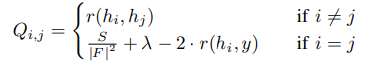

## brute force method

In [ ]:

def brute_force_method(df, target, dataset_name):
    X = df.drop(target, axis=1)
    y = df[target]
    start_time = time.time()


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    best_score = -float('inf')
    best_rmse = float('inf')
    best_combination = []


    for i in range(1, len(X.columns) + 1):
        for combo in combinations(X.columns, i):

            model = LinearRegression()
            model.fit(X_train[list(combo)], y_train)
            y_pred = model.predict(X_test[list(combo)])
            score = r2_score(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            if score > best_score or (score == best_score and rmse < best_rmse):
                best_score = score
                best_rmse = rmse
                best_combination = combo
    end_time = time.time()
    runtime_ = end_time - start_time
    save_rmse_to_csv(best_rmse, model,df, len(X_train.columns), runtime_, 'brute force', best_score, model, 1, dataset_name)

    print('Best RMSE:', best_rmse)
    print('Best R2 Score:', best_score)
    print('Best combination of features:', best_combination)
    return [best_combination, best_score, best_rmse]


## 1) Mutual Information Classical


In [ ]:


########################## Mutual Information ##################################
def get_mutual_inf(df_, number_of_f_to_select, target_name):
  mi = {}
  features = list(set(df_.columns).difference((target_name,)))
  for feature in features:
      mi[feature] = mutual_information(prob(df_[[target_name, feature]].values), 1)

  sorted_mi = sorted(mi.items(), key=lambda pair: pair[1], reverse=True)
  df_ = df_[[column[0] for column in sorted_mi[0:number_of_f_to_select]]]
  print("Submitting for {} features: {}".format(number_of_f_to_select, features))
  plot_mi(mi)

  return df_.columns




## 2) Mutual Information QC

In [ ]:

############################ Q matrix with MI ##################################
def construct_q_matrix_mi(df_, alpha_, target_name):
    my_bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
    features = list(set(df_.columns).difference((target_name,)))

    for feature in features:
        mi = mutual_information(prob(df_[[target_name, feature]].values), 1)
        my_bqm.add_variable(feature, -mi)

    for f0, f1 in itertools.combinations(features, 2):
        cmi_01 = conditional_mutual_information(alpha_ *prob(df_[[target_name, f0, f1]].values), 1, 2)
        cmi_10 = conditional_mutual_information(alpha_ *prob(df_[[target_name, f1, f0]].values), 1, 2)
        my_bqm.add_interaction(f0, f1, -cmi_01)
        my_bqm.add_interaction(f1, f0, -cmi_10)

    my_bqm.normalize()

    #print("bqm in Q matrix of MI=", bqm)



    return my_bqm

## 3) R_squared Linear Regression

In [ ]:
######################### r(feature i, target) #################################
def get_r_squared_rmse_one_feature(df_, target_name):
  predictions_df = pd.DataFrame(columns=['Feature', 'RMSE', 'R_Squared', 'Std_Dev', 'Mean_val', 'Coefficient_of_variation'])

  for feature in df_.columns:
      if feature == target_name:
          continue

      X = df_[[feature]]
      y = df_[target_name]

      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


      model = LinearRegression()
      model.fit(X_train, y_train)


      y_pred_ = model.predict(X_test)

      rmse = mean_squared_error(y_test, y_pred_)**0.5
      #r_squared = max(r2_score(y_test, y_pred_), 0)
      r_squared = r2_score(y_test, y_pred_)
      std_dev = df_[feature].std()
      mean_val = df_[feature].mean()
      cv = std_dev / mean_val if mean_val != 0 else 0
      predictions_df.loc[len(predictions_df)] = [feature, rmse,r_squared, std_dev, mean_val, cv]

  return predictions_df


#################### r(feature (i,j), Target)###################################
def get_r_squared_rmse_two_features(df_, target_name):

  predictions_df_pairs = pd.DataFrame(columns=['Feature_1', 'Feature_2', 'RMSE_2', 'R_Squared_2', 'Coefficient_of_variation_1','Coefficient_of_variation_2'])


  for feature_pair in itertools.combinations(df_.columns, 2):
      feature_1, feature_2 = feature_pair

      if feature_1 == target_name or feature_2 == target_name:
          continue

      X = df_[list(feature_pair)]
      y = df_[target_name]

      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

      model = LinearRegression()
      model.fit(X_train, y_train)

      y_pred = model.predict(X_test)

      rmse = mean_squared_error(y_test, y_pred) ** 0.5
      r_squared = max(r2_score(y_test, y_pred), 0)



      std_dev_1 = df_[feature_1].std()
      mean_val_1 = df_[feature_1].mean()
      cv_1 = std_dev_1 / mean_val_1 if mean_val_1 != 0 else 0

      std_dev_2= df_[feature_2].std()
      mean_val_2 = df_[feature_2].mean()
      cv_2 = std_dev_2 / mean_val_2 if mean_val_2 != 0 else 0

      predictions_df_pairs.loc[len(predictions_df_pairs)] = [feature_1,feature_2, rmse,r_squared, cv_1, cv_2]

  return predictions_df_pairs


####################### Q matrix with linear reg ###############################
def construct_q_matrix(df_linear, df_quadratic, alpha_):
    my_bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    for index, row in df_linear.iterrows():

        my_bqm.add_variable(row['Feature'], -row['R_Squared'])


    for index, row in df_quadratic.iterrows():
        my_bqm.add_interaction(row['Feature_1'],row['Feature_2'], -alpha_ * row['R_Squared_2'])
        my_bqm.add_interaction(row['Feature_2'], row['Feature_1'], -alpha_ * row['R_Squared_2'])


    my_bqm.normalize()

    return my_bqm

####################### Q matrix with linear reg with my CV#####################
def construct_q_matrix_lr_cv(df_linear, df_quadratic, alpha_):
    my_bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    for index, row in df_linear.iterrows():

        my_bqm.add_variable(row['Feature'], -row['R_Squared']*(1/row['RMSE']))


    for index, row in df_quadratic.iterrows():
        my_bqm.add_interaction(row['Feature_1'],row['Feature_2'], -alpha_ * row['R_Squared_2']*(1/row['RMSE_2']))
        my_bqm.add_interaction(row['Feature_2'], row['Feature_1'], -alpha_  * row['R_Squared_2']*(1/row['RMSE_2']))


    my_bqm.normalize()

    return my_bqm

###########Q matrix with linear reg difference between singlee R2 #############
def construct_q_matrix_diff_two_single_Rsquared(df_linear, df_quadratic, alpha_):


    my_bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
    for index, row in df_linear.iterrows():
        my_bqm.add_variable(row['Feature'], -row['R_Squared'])

    df_linear.set_index('Feature', inplace=True)
    for index, row in df_quadratic.iterrows():


        my_bqm.add_interaction(row['Feature_1'],row['Feature_2'], -alpha_ * (row['R_Squared_2']-df_linear.loc[row['Feature_1'], 'RMSE']))
        my_bqm.add_interaction(row['Feature_2'], row['Feature_1'], -alpha_  * (row['R_Squared_2']-df_linear.loc[row['Feature_2'], 'RMSE']))

        #my_bqm.add_interaction(row['Feature_1'],row['Feature_2'], -alpha_ * (row['R_Squared_2']-df_linear.loc[row['Feature_1'], 'R_Squared']))
        #my_bqm.add_interaction(row['Feature_2'], row['Feature_1'], -alpha_  * (row['R_Squared_2']-df_linear.loc[row['Feature_2'], 'R_Squared']))



    my_bqm.normalize()


    return my_bqm



## 4) R_squared Random Forest

In [ ]:
############ Random Forest Regression for Single Feature Prediction ############
def get_r_squared_rmse_one_feature_rf(df_, target_name):
    predictions_df = pd.DataFrame(columns=['Feature', 'RMSE', 'R_Squared'])



    for feature in df_.columns:

        if feature == target_name:
            continue

        X = df_[[feature]]
        y = df_[target_name]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestRegressor(random_state=42)

        model.fit(X_train, y_train)

        y_pred_ = model.predict(X_test)


        rmse = mean_squared_error(y_test, y_pred_)**0.5
        print("##########10")
        r_squared = r2_score(y_test, y_pred_)
        predictions_df.loc[len(predictions_df)] = [feature, rmse, r_squared]

    return predictions_df


############ Random Forest Regression for Pairwise Feature Prediction #########
def get_r_squared_rmse_two_features_rf(df_, target_name):

    predictions_df_pairs = pd.DataFrame(columns=['Feature_1', 'Feature_2', 'RMSE_2', 'R_Squared_2'])

    for feature_pair in itertools.combinations(df_.columns, 2):

        feature_1, feature_2 = feature_pair
        if feature_1 == target_name or feature_2 == target_name:
          continue
        X = df_[list(feature_pair)]
        y = df_[target_name]


        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestRegressor(random_state=42)

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        print("######222####14")
        rmse = mean_squared_error(y_test, y_pred) ** 0.5
        r_squared = r2_score(y_test, y_pred)


        predictions_df_pairs.loc[len(predictions_df_pairs)] = [feature_1, feature_2, rmse, r_squared]

    return predictions_df_pairs


############ Adjust Q Matrix Construction for Random Forest Outcomes ###########
def construct_q_matrix_rf(df_linear, df_quadratic, alpha_):
    my_bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    for index, row in df_linear.iterrows():
        my_bqm.add_variable(row['Feature'], -row['R_Squared'])

    for index, row in df_quadratic.iterrows():
        my_bqm.add_interaction(row['Feature_1'], row['Feature_2'], -alpha_ * row['R_Squared_2'])
        my_bqm.add_interaction(row['Feature_2'], row['Feature_1'], -alpha_ * row['R_Squared_2'])

    my_bqm.normalize()

    return my_bqm

###########Q matrix with rf difference between singlee R2 #############
def construct_q_matrix_diff_two_single_Rsquared_rf(df_linear, df_quadratic, alpha_):


    my_bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
    for index, row in df_linear.iterrows():
        my_bqm.add_variable(row['Feature'], -row['R_Squared'])

    df_linear.set_index('Feature', inplace=True)
    for index, row in df_quadratic.iterrows():


        my_bqm.add_interaction(row['Feature_1'],row['Feature_2'], -alpha_ * (row['R_Squared_2']-df_linear.loc[row['Feature_1'], 'R_Squared']))
        my_bqm.add_interaction(row['Feature_2'], row['Feature_1'], -alpha_  * (row['R_Squared_2']-df_linear.loc[row['Feature_2'], 'R_Squared']))


    my_bqm.normalize()


    return my_bqm


## 5) R_squared XGboost

In [ ]:
### XGBoost Regression for Single Feature Prediction ##########################

def get_r_squared_rmse_one_feature_xgb(df_, target_name):
    predictions_df = pd.DataFrame(columns=['Feature', 'RMSE', 'R_Squared'])

    for feature in df_.columns:
        if feature == target_name:
            continue

        X = df_[[feature]]
        y = df_[target_name]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = xgb.XGBRegressor(objective ='reg:squarederror', seed=42)
        model.fit(X_train, y_train)

        y_pred_ = model.predict(X_test)

        rmse = mean_squared_error(y_test, y_pred_)**0.5
        r_squared = r2_score(y_test, y_pred_)
        predictions_df.loc[len(predictions_df)] = [feature, rmse, r_squared]

    return predictions_df


##########XGBoost Regression for Pairwise Feature Prediction###################
def get_r_squared_rmse_two_features_xgb(df_, target_name):
    predictions_df_pairs = pd.DataFrame(columns=['Feature_1', 'Feature_2', 'RMSE_2', 'R_Squared_2'])

    for feature_pair in itertools.combinations(df_.columns, 2):
        feature_1, feature_2 = feature_pair

        if feature_1 == target_name or feature_2 == target_name:
            continue
        X = df_[list(feature_pair)]
        y = df_[target_name]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = xgb.XGBRegressor(objective ='reg:squarederror', seed=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        rmse = mean_squared_error(y_test, y_pred) ** 0.5
        r_squared = r2_score(y_test, y_pred)


        predictions_df_pairs.loc[len(predictions_df_pairs)] = [feature_1, feature_2, rmse, r_squared]

    return predictions_df_pairs


###############Adjust Q Matrix Construction for XGBoost Outcomes###############
def construct_q_matrix_xgb(df_linear, df_quadratic, alpha_):
    my_bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    for index, row in df_linear.iterrows():
        my_bqm.add_variable(row['Feature'], -row['R_Squared'])

    for index, row in df_quadratic.iterrows():
        my_bqm.add_interaction(row['Feature_1'], row['Feature_2'], -alpha_ * row['R_Squared_2'])
        my_bqm.add_interaction(row['Feature_2'], row['Feature_1'], -alpha_ * row['R_Squared_2'])

    my_bqm.normalize()

    return my_bqm

###########Q matrix with xgboost difference between singlee R2 #############
def construct_q_matrix_diff_two_single_Rsquared_xgb(df_linear, df_quadratic, alpha_):


    my_bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
    for index, row in df_linear.iterrows():
        my_bqm.add_variable(row['Feature'], -row['R_Squared'])

    df_linear.set_index('Feature', inplace=True)
    for index, row in df_quadratic.iterrows():


        my_bqm.add_interaction(row['Feature_1'],row['Feature_2'], -alpha_ * (row['R_Squared_2']-df_linear.loc[row['Feature_1'], 'R_Squared']))
        my_bqm.add_interaction(row['Feature_2'], row['Feature_1'], -alpha_  * (row['R_Squared_2']-df_linear.loc[row['Feature_2'], 'R_Squared']))


    my_bqm.normalize()


    return my_bqm

In [ ]:
'''
######################### r(feature i, target) #################################
def get_r_squared_rmse_one_feature(df_):
  predictions_df = pd.DataFrame(columns=['Feature', 'RMSE', 'R_Squared'])

  for feature in df_.columns:
      if feature == 'Total Users':
          continue

      X = df_[[feature]]
      y = df_['Total Users']

      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


      model = LinearRegression()
      model.fit(X_train, y_train)


      y_pred_ = model.predict(X_test)

      rmse = mean_squared_error(y_test, y_pred_)**0.5
      r_squared = r2_score(y_test, y_pred_)
      predictions_df.loc[len(predictions_df)] = [feature, rmse,r_squared ]

  return predictions_df


#################### r(feature (i,j), Target)###################################
def get_r_squared_rmse_two_features(df_):

  predictions_df_pairs = pd.DataFrame(columns=['Feature_1', 'Feature_2', 'RMSE_2', 'R_Squared_2'])


  for feature_pair in itertools.combinations(df_.columns, 2):
      X = df_[list(feature_pair)]
      y = df_['Total Users']

      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

      model = LinearRegression()
      model.fit(X_train, y_train)

      y_pred = model.predict(X_test)

      rmse = mean_squared_error(y_test, y_pred) ** 0.5
      r_squared = r2_score(y_test, y_pred)

      feature_1, feature_2 = feature_pair
      predictions_df_pairs.loc[len(predictions_df_pairs)] = [feature_1,feature_2, rmse,r_squared ]

  return predictions_df_pairs


####################### Q matrix with linear reg ###############################
def construct_q_matrix(df_linear, df_quadratic, alpha_):
    my_bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    for index, row in df_linear.iterrows():

        my_bqm.add_variable(row['Feature'], -row['R_Squared'])


    for index, row in df_quadratic.iterrows():
        my_bqm.add_interaction(row['Feature_1'],row['Feature_2'], alpha_ * row['R_Squared_2'])
        my_bqm.add_interaction(row['Feature_2'], row['Feature_1'], alpha_ * row['R_Squared_2'])


    my_bqm.normalize()

    return my_bqm


############################ Q matrix with MI ##################################
def construct_q_matrix_mi(df_):
    my_bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
    features = list(set(df_.columns).difference(('Total Users',)))

    for feature in features:
        mi = mutual_information(prob(df_[['Total Users', feature]].values), 1)
        my_bqm.add_variable(feature, -mi)

    for f0, f1 in itertools.combinations(features, 2):
        cmi_01 = conditional_mutual_information(prob(df_[['Total Users', f0, f1]].values), 1, 2)
        cmi_10 = conditional_mutual_information(prob(df_[['Total Users', f1, f0]].values), 1, 2)
        my_bqm.add_interaction(f0, f1, -cmi_01)
        my_bqm.add_interaction(f1, f0, -cmi_10)

    my_bqm.normalize()

    #print("bqm in Q matrix of MI=", bqm)



    return my_bqm




########################## Mutual Information ##################################
def get_mutual_inf(df_, number_of_f_to_select):
  mi = {}
  features = list(set(df_.columns).difference(('Total Users',)))
  for feature in features:
      mi[feature] = mutual_information(prob(df_[['Total Users', feature]].values), 1)

  sorted_mi = sorted(mi.items(), key=lambda pair: pair[1], reverse=True)
  df_ = df_[[column[0] for column in sorted_mi[0:number_of_f_to_select]]]
  print("Submitting for {} features: {}".format(number_of_f_to_select, features))
  plot_mi(mi)

  return df_.columns'''






'\n######################### r(feature i, target) #################################\ndef get_r_squared_rmse_one_feature(df_):\n  predictions_df = pd.DataFrame(columns=[\'Feature\', \'RMSE\', \'R_Squared\'])\n\n  for feature in df_.columns:\n      if feature == \'Total Users\':\n          continue\n\n      X = df_[[feature]]\n      y = df_[\'Total Users\']\n\n      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n\n      model = LinearRegression()\n      model.fit(X_train, y_train)\n\n\n      y_pred_ = model.predict(X_test)\n\n      rmse = mean_squared_error(y_test, y_pred_)**0.5\n      r_squared = r2_score(y_test, y_pred_)\n      predictions_df.loc[len(predictions_df)] = [feature, rmse,r_squared ]\n\n  return predictions_df\n\n\n#################### r(feature (i,j), Target)###################################\ndef get_r_squared_rmse_two_features(df_):\n\n  predictions_df_pairs = pd.DataFrame(columns=[\'Feature_1\', \'Feature_2\', \'RMSE_2\', \

## 6) Pearson Similarity

In [ ]:
############## Pearson Similarity for Single Feature ########################
import numpy as np

def get_pearson_similarity_one_feature(df_, target_name):
    similarity_df = pd.DataFrame(columns=['Feature', 'Pearson_Coefficient'])

    for feature in df_.columns:
        if feature == target_name:
            continue

        correlation = np.corrcoef(df_[feature], df_[target_name])[0, 1]
        similarity_df.loc[len(similarity_df)] = [feature, correlation]

    return similarity_df


############### Pearson Similarity for Pairwise Feature Combination ##########
def get_pearson_similarity_two_features(df_, target_name):
    similarity_df_pairs = pd.DataFrame(columns=['Feature_1', 'Feature_2', 'Pearson_Coefficient_2'])

    for feature_pair in itertools.combinations(df_.columns, 2):
        feature_1, feature_2 = feature_pair
        if feature_1 == target_name or feature_2 == target_name:
            continue
        correlation = np.corrcoef(df_[feature_pair[0]], df_[feature_pair[1]])[0, 1]

        similarity_df_pairs.loc[len(similarity_df_pairs)] = [feature_1, feature_2, correlation]

    return similarity_df_pairs


############## Construct Q Matrix Using Pearson Similarity ####################
def construct_q_matrix_pearson(df_linear, df_quadratic, alpha_):
    my_bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    for index, row in df_linear.iterrows():
        my_bqm.add_variable(row['Feature'], -row['Pearson_Coefficient'])

    for index, row in df_quadratic.iterrows():
        my_bqm.add_interaction(row['Feature_1'], row['Feature_2'], -alpha_ * row['Pearson_Coefficient_2'])
        my_bqm.add_interaction(row['Feature_2'], row['Feature_1'],-alpha_ * row['Pearson_Coefficient_2'])

    my_bqm.normalize()

    return my_bqm



## 7) Spearman Similarity

In [ ]:
from scipy.stats import spearmanr
############  Spearman Similarity for Single Feature ###########################
def get_spearman_similarity_one_feature(df_, target_name):
    similarity_df = pd.DataFrame(columns=['Feature', 'Spearman_Coefficient'])


    for feature in df_.columns:
        if feature == target_name:
            continue

        correlation, _ = spearmanr(df_[feature], df_[targtarget_nameet])
        similarity_df.loc[len(similarity_df)] = [feature, correlation]

    return similarity_df

########### Spearman Similarity for Pairwise Feature Combination ##############
def get_spearman_similarity_two_features(df_, target_name):
    similarity_df_pairs = pd.DataFrame(columns=['Feature_1', 'Feature_2', 'Spearman_Coefficient_2'])

    for feature_pair in itertools.combinations(df_.columns, 2):
        feature_1, feature_2 = feature_pair

        if feature_1 == target_name or feature_2 == target_name:
            continue
        correlation, _ = spearmanr(df_[feature_pair[0]], df_[feature_pair[1]])

        similarity_df_pairs.loc[len(similarity_df_pairs)] = [feature_1, feature_2, correlation]

    return similarity_df_pairs



########### Construct Q Matrix Using Spearman Similarity ######################
def construct_q_matrix_spearman(df_linear, df_quadratic, alpha_):
    my_bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    for index, row in df_linear.iterrows():
        my_bqm.add_variable(row['Feature'], -row['Spearman_Coefficient'])

    for index, row in df_quadratic.iterrows():
        my_bqm.add_interaction(row['Feature_1'], row['Feature_2'], -alpha_ * row['Spearman_Coefficient_2'])
        my_bqm.add_interaction(row['Feature_2'], row['Feature_1'], -alpha_ * row['Spearman_Coefficient_2'])

    my_bqm.normalize()

    return my_bqm


## 8) Manhattan

In [ ]:
from sklearn.metrics import pairwise_distances
############# Manhattan Distance for Single Feature ########################
def get_manhattan_distance_one_feature(df_,  target_name):
    distance_df = pd.DataFrame(columns=['Feature', 'Manhattan_Distance'])


    for feature in df_.columns:
        if feature == target_name:
            continue

        # Calculate Manhattan distance
        distance = pairwise_distances(df_[[feature]], df_[[target_name]], metric='manhattan')
        mean_distance = distance.mean()  # Optionally, take mean if pairwise returns array
        distance_df.loc[len(distance_df)] = [feature, mean_distance]

    return distance_df


################ Manhattan Distance for Pairwise Feature Combination ##########
def get_manhattan_distance_two_features(df_, target_name):
    distance_df_pairs = pd.DataFrame(columns=['Feature_1', 'Feature_2', 'Manhattan_Distance_2'])

    for feature_pair in itertools.combinations(df_.columns, 2):
        feature_1, feature_2 = feature_pair

        if feature_1 == target_name or feature_2 == target_name:
            continue
        # Calculate Manhattan distance
        distance = pairwise_distances(df_[[feature_pair[0]]], df_[[feature_pair[1]]], metric='manhattan')
        mean_distance = distance.mean()  # Optionally, take mean if pairwise returns array

        distance_df_pairs.loc[len(distance_df_pairs)] = [feature_1, feature_2, mean_distance]

    return distance_df_pairs


############## Construct Q Matrix Using Manhattan Distance ####################
def construct_q_matrix_manhattan(df_linear, df_quadratic, alpha_):
    my_bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    for index, row in df_linear.iterrows():
        my_bqm.add_variable(row['Feature'], -row['Manhattan_Distance'])

    for index, row in df_quadratic.iterrows():
        my_bqm.add_interaction(row['Feature_1'], row['Feature_2'], -alpha_ * row['Manhattan_Distance_2'])
        my_bqm.add_interaction(row['Feature_2'], row['Feature_1'], -alpha_ * row['Manhattan_Distance_2'])

    my_bqm.normalize()

    return my_bqm


## 9) jaccard_score

In [ ]:
#############Jaccard Index for Single Feature #######################
from sklearn.metrics import jaccard_score

def get_jaccard_index_one_feature(df_, target_name):
    index_df = pd.DataFrame(columns=['Feature', 'Jaccard_Index'])


    for feature in df_.columns:
        if feature == target_name:
            continue

        # Calculate Jaccard Index
        index = jaccard_score(df_[target_name], df_[feature], average='binary')
        index_df.loc[len(index_df)] = [feature, index]

    return index_df


########### Jaccard Index for Pairwise Feature Combination ###############
def get_jaccard_index_two_features(df_, target_name):

    index_df_pairs = pd.DataFrame(columns=['Feature_1', 'Feature_2', 'Jaccard_Index_2'])

    for feature_pair in itertools.combinations(df_.columns, 2):
        feature_1, feature_2 = feature_pair

        if feature_1 == target_name or feature_2 == target_name:
              continue
        # Calculate Jaccard Index
        index = jaccard_score(df_[feature_pair[0]], df_[feature_pair[1]], average='binary')

        index_df_pairs.loc[len(index_df_pairs)] = [feature_1, feature_2, index]

    return index_df_pairs

########## Construct Q Matrix Using Jaccard Index ###########################
def construct_q_matrix_jaccard(df_linear, df_quadratic, alpha_):
    my_bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    for index, row in df_linear.iterrows():
        my_bqm.add_variable(row['Feature'], -row['Jaccard_Index'])

    for index, row in df_quadratic.iterrows():
        my_bqm.add_interaction(row['Feature_1'], row['Feature_2'], -alpha_ * row['Jaccard_Index_2'])
        my_bqm.add_interaction(row['Feature_2'], row['Feature_1'], -alpha_ * row['Jaccard_Index_2'])

    my_bqm.normalize()

    return my_bqm



## 10) Mahalanobis

In [ ]:
from scipy.spatial.distance import mahalanobis
import numpy as np

def get_mahalanobis_distance_one_feature(df_, target_name):
    distance_df = pd.DataFrame(columns=['Feature', 'Mahalanobis_Distance'])


    # Calculate the inverse of the covariance matrix
    cov_matrix = np.cov(df_.values.T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # Calculate Mahalanobis distance for each feature
    for feature in df_.columns:
        if feature == target_name:
            continue

        # Calculate Mahalanobis distance
        distance = mahalanobis(df_[feature], df_[target_name], inv_cov_matrix)
        distance_df.loc[len(distance_df)] = [feature, distance]

    return distance_df


def get_mahalanobis_distance_two_features(df_, target_name):
    distance_df_pairs = pd.DataFrame(columns=['Feature_1', 'Feature_2', 'Mahalanobis_Distance_2'])

    # Calculate the inverse of the covariance matrix
    cov_matrix = np.cov(df_.values.T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    for feature_pair in itertools.combinations(df_.columns, 2):
        # Calculate Mahalanobis distance
        feature_1, feature_2 = feature_pair

        if feature_1 == target_name or feature_2 == target_name:
                continue
        distance = mahalanobis(df_[feature_pair[0]], df_[feature_pair[1]], inv_cov_matrix)

        distance_df_pairs.loc[len(distance_df_pairs)] = [feature_1, feature_2, distance]

    return distance_df_pairs




def construct_q_matrix_mahalanobis(df_linear, df_quadratic, alpha_):
    my_bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    for index, row in df_linear.iterrows():
        my_bqm.add_variable(row['Feature'], -row['Mahalanobis_Distance'])

    for index, row in df_quadratic.iterrows():
        my_bqm.add_interaction(row['Feature_1'], row['Feature_2'], -alpha_ * row['Mahalanobis_Distance_2'])
        my_bqm.add_interaction(row['Feature_2'], row['Feature_1'], -alpha_ * row['Mahalanobis_Distance_2'])

    my_bqm.normalize()

    return my_bqm



## 11) Proposed Method

In [ ]:
######################Q matrix Proposed method #################################
def construct_q_matrix_proposed_method(df_main_, df_linear, df_quadratic, alpha_):


    my_bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
    features = list(set(df_linear.columns).difference((target_name,)))
    for index, row in df_linear.iterrows():
        mi = mutual_information(prob(df_main_[[target_name, row['Feature']]].values), 1)
        #my_bqm.add_variable(row['Feature'], -row['R_Squared'])
        my_bqm.add_variable(row['Feature'], -mi/row['R_Squared'])

    df_linear.set_index('Feature', inplace=True)
    for index, row in df_quadratic.iterrows():

        cmi_01 = conditional_mutual_information(alpha_ *prob(df_main_[[target_name, row['Feature_1'], row['Feature_2']]].values), 1, 2)
        cmi_10 = conditional_mutual_information(alpha_ *prob(df_main_[[target_name, row['Feature_2'], row['Feature_1']]].values), 1, 2)

        #my_bqm.add_interaction(row['Feature_1'],row['Feature_2'],-alpha_ * (row['R_Squared_2']-df_linear.loc[row['Feature_1'], 'R_Squared']))
        #my_bqm.add_interaction(row['Feature_2'], row['Feature_1'],  -alpha_  * (row['R_Squared_2']-df_linear.loc[row['Feature_2'], 'R_Squared']))
        coe_1 =  row['R_Squared_2']-df_linear.loc[row['Feature_1'], 'R_Squared']
        if coe_1 < 0:
            coe_1 =  coe_1 /row['RMSE_2']
        elif coe_1 > 0:
            coe_1 =  coe_1 *row['RMSE_2']

        coe_2 =  row['R_Squared_2']-df_linear.loc[row['Feature_2'], 'R_Squared']
        if coe_2 < 0:
            coe_2 =  coe_2 /row['RMSE_2']
        elif coe_2 > 0:
            coe_2 =  coe_2 *row['RMSE_2']
        my_bqm.add_interaction(row['Feature_1'],row['Feature_2'],-alpha_ * (coe_1))
        my_bqm.add_interaction(row['Feature_2'], row['Feature_1'],  -alpha_  * (coe_2))

    my_bqm.normalize()


    return my_bqm

# Main()

## Parameters

In [ ]:
number_of_features_to_select = 5
number_of_features_random_selection_for_test = 50 ### It should be len(df_all_clean.columns)
alpha_ = 1
datasets = ['bike','wine', 'insurance']
dataset_name = datasets[1]
target_name = ''
if dataset_name == 'bike':
    target_name = 'Total Users'
    original_features = df_all_clean.columns.tolist()
    random_features = random.sample(original_features, number_of_features_random_selection_for_test)
    df_main_ = df_all_clean[random_features]
    total_users_column = df_all_clean[['Total Users']]
    df_main_ = pd.concat([total_users_column, df_main_], axis=1)
    df_main_ = df_main_.dropna(axis=1, how='all')
    df_main_.fillna(0, inplace=True)
elif dataset_name == 'wine':
      target_name = 'quality'
      df_main_ = df_wine
elif dataset_name == 'insurance':
      target_name = 'charges'
      df_main_ = df_insurance
elif dataset_name == 'obesity':
      df_main_ = df_obesity


## Run

In [ ]:
# 0 brute force
#best_combination, best_score, rmse =brute_force_method(df_main_, target_name, dataset_name)
################################################################################

# 1) Run MI in classical and get rmse
'''array_selected_features_classical = get_mutual_inf(df_main_, number_of_features_to_select, target_name)
features_classical = df_main_.drop(target_name, axis=1)
features_classical = df_main_[array_selected_features_classical]
target_classical = df_main_[target_name]
X_train_classical, X_test_classical, y_train_classical, y_test_classical = train_test_split(features_classical, target_classical, test_size=0.2, random_state=42)
method = 'MI_classic'
## 1.1) Target model = Linear Regression
model_lr_classical = linear_regression(df_main_, X_train_classical, y_train_classical, X_test_classical, y_test_classical, method, alpha_, dataset_name)
## 1.2) Target model = Random Forest
model_rf_classical= random_forest_regression(df_main_, X_train_classical, y_train_classical, X_test_classical, y_test_classical, method, alpha_, dataset_name)
## 1.3) Target model = XGBoost
model_xgb_classical= xgboost_regression(df_main_, X_train_classical, y_train_classical, X_test_classical, y_test_classical, method, alpha_, dataset_name)
print("############"+ method + "is Done"+"#############")'''
################################################################################
# 2) Run MI in QC and get rmse
'''my_bqm_mi = construct_q_matrix_mi(df_main_, alpha_, target_name)
## 2.1) select features in QC
df_input_qc_mi = df_main_.drop(target_name, axis=1)
array_selected_features_qc_mi, runtime_QC_mi = quantum_solver(my_bqm_mi, df_input_qc_mi.columns.tolist(), number_of_features_to_select)
## 2.2) Split data
features_qc_mi = df_main_.drop(target_name, axis=1)
features_qc_mi = df_main_[array_selected_features_qc_mi]
target_qc_mi = df_main_[target_name]
X_train_qc_mi, X_test_qc_mi, y_train_qc_mi, y_test_qc_mi = train_test_split(features_qc_mi, target_qc_mi, test_size=0.2, random_state=42)
method = 'MI_QC'
## 2.3) Target model = Linear Regression
model_lr_qc_mi = linear_regression(df_main_, X_train_qc_mi, y_train_qc_mi, X_test_qc_mi, y_test_qc_mi, method, alpha_, dataset_name)
## 2.4) Target model = Random Forest
model_rf_qc_mi = random_forest_regression(df_main_, X_train_qc_mi, y_train_qc_mi, X_test_qc_mi, y_test_qc_mi, method, alpha_,dataset_name)
## 2.5) Target model = XGBoost
model_xgb_qc_mi = xgboost_regression(df_main_, X_train_qc_mi, y_train_qc_mi, X_test_qc_mi, y_test_qc_mi, method, alpha_,dataset_name)
print("############"+ method + "is Done"+"#############")'''
################################################################################
'''# 3) Run linear regression to use r_squared as similarity parameter in QUBO
predictions_df_pairs = get_r_squared_rmse_two_features(df_main_, target_name)
predictions_df = get_r_squared_rmse_one_feature(df_main_, target_name)

#predictions_df = predictions_df.drop_duplicates(subset=['Feature'])
predictions_df_pairs = predictions_df_pairs[predictions_df_pairs['Feature_1'] != predictions_df_pairs['Feature_2']]
my_bqm = construct_q_matrix_diff_two_single_Rsquared(predictions_df, predictions_df_pairs, alpha_)
## 3.1) select features in QC
array_selected_features_qc, runtime_QC = quantum_solver(my_bqm, predictions_df.index.tolist(), number_of_features_to_select)
## 3.2) random forest for selected features in QC
features_qc = df_main_.drop(target_name, axis=1)
features_qc = df_main_[array_selected_features_qc]
target_qc = df_main_[target_name]
X_train, X_test, y_train, y_test = train_test_split(features_qc, target_qc, test_size=0.2, random_state=42)
method = 'Linear_QC'
## 3.3) Target model = Linear Regression
## 3.4) Target model = Random Forest
model_rf = random_forest_regression(df_main_, X_train, y_train, X_test, y_test, method, alpha_, dataset_name)
## 3.5) Target model = XGBoost'''

# 3) Run linear regression to use r_squared as similarity parameter in QUBO
'''predictions_df_pairs = get_r_squared_rmse_two_features(df_main_, target_name)
predictions_df = get_r_squared_rmse_one_feature(df_main_, target_name)

#predictions_df = predictions_df.drop_duplicates(subset=['Feature'])
predictions_df_pairs = predictions_df_pairs[predictions_df_pairs['Feature_1'] != predictions_df_pairs['Feature_2']]
my_bqm = construct_q_matrix_proposed_method(df_main_,predictions_df, predictions_df_pairs, alpha_)
## 3.1) select features in QC
array_selected_features_qc, runtime_QC = quantum_solver(my_bqm, predictions_df.index.tolist(), number_of_features_to_select)
## 3.2) Split data
features_qc = df_main_.drop(target_name, axis=1)
features_qc = df_main_[array_selected_features_qc]
target_qc = df_main_[target_name]
X_train, X_test, y_train, y_test = train_test_split(features_qc, target_qc, test_size=0.2, random_state=42)
method = 'Linear_QC'
## 3.3) Target model = Linear Regression
model_target_lr_simi_lr = linear_regression(df_main_, X_train, y_train, X_test, y_test, method, alpha_, dataset_name)
## 3.4) Target model = Random Forest
model_target_rf_simi_lr = random_forest_regression(df_main_, X_train, y_train, X_test, y_test, method, alpha_, dataset_name)
## 3.5) Target model = XGBoost
model_target_xgb_simi_lr = xgboost_regression(df_main_, X_train, y_train, X_test, y_test, method, alpha_, dataset_name)
print("############"+ method + "is Done"+"#############")'''
################################################################################

'''# 4) Run Random Forest to use r_squared as similarity parameter in QUBO
predictions_df_pairs_rf = get_r_squared_rmse_two_features_rf(df_main_, target_name)
predictions_df_rf = get_r_squared_rmse_one_feature_rf(df_main_, target_name)
#predictions_df = predictions_df.drop_duplicates(subset=['Feature'])
predictions_df_pairs_rf = predictions_df_pairs_rf[predictions_df_pairs_rf['Feature_1'] != predictions_df_pairs_rf['Feature_2']]
my_bqm_rf = construct_q_matrix_diff_two_single_Rsquared_rf(predictions_df_rf, predictions_df_pairs_rf, alpha_)
## 4.1) select features in QC
array_selected_features_qc_rf, runtime_QC_rf = quantum_solver(my_bqm_rf, predictions_df_rf.index.tolist(), number_of_features_to_select)
## 4.2) Split data
features_qc_rf = df_main_.drop(target_name, axis=1)
features_qc_rf = df_main_[array_selected_features_qc_rf]
target_qc_rf = df_main_[target_name]
X_train, X_test, y_train, y_test = train_test_split(features_qc_rf, target_qc_rf, test_size=0.2, random_state=42)
method = 'RF_QC'
## 4.3) Target model = Linear Regression
## 4.4) Target model = Random Forest
model_rf = random_forest_regression(df_main_, X_train, y_train, X_test, y_test, method, alpha_,dataset_name)
## 4.5) Target model = XGBoost'''

# 4) Run Random Forest to use r_squared as similarity parameter in QUBO
'''predictions_df_pairs_rf = get_r_squared_rmse_two_features_rf(df_main_, target_name)
predictions_df_rf = get_r_squared_rmse_one_feature_rf(df_main_, target_name)
#predictions_df = predictions_df.drop_duplicates(subset=['Feature'])
predictions_df_pairs_rf = predictions_df_pairs_rf[predictions_df_pairs_rf['Feature_1'] != predictions_df_pairs_rf['Feature_2']]
my_bqm_rf = construct_q_matrix_proposed_method(df_main_, predictions_df_rf, predictions_df_pairs_rf, alpha_)
## 4.1) select features in QC
array_selected_features_qc_rf, runtime_QC_rf = quantum_solver(my_bqm_rf, predictions_df_rf.index.tolist(), number_of_features_to_select)
## 4.2) Split data
features_qc_rf = df_main_.drop(target_name, axis=1)
features_qc_rf = df_main_[array_selected_features_qc_rf]
target_qc_rf = df_main_[target_name]
X_train, X_test, y_train, y_test = train_test_split(features_qc_rf, target_qc_rf, test_size=0.2, random_state=42)
method = 'RF_QC'
## 4.3) Target model = Linear Regression
model_target_lr_simi_rf = linear_regression(df_main_, X_train, y_train, X_test, y_test, method, alpha_, dataset_name)
## 4.4) Target model = Random Forest
model_target_rf_simi_rf = random_forest_regression(df_main_, X_train, y_train, X_test, y_test, method, alpha_,dataset_name)
## 4.5) Target model = XGBoost
model_target_xgb_simi_rf = xgboost_regression(df_main_, X_train, y_train, X_test, y_test, method, alpha_,dataset_name)
print("############"+ method + "is Done"+"#############")'''
################################################################################
'''# 5) Run XGBoost to use r_squared as similarity parameter in QUBO
predictions_df_pairs_xgb = get_r_squared_rmse_two_features_xgb(df_main_, target_name)
predictions_df_xgb = get_r_squared_rmse_one_feature_xgb(df_main_, target_name)

predictions_df_pairs_xgb = predictions_df_pairs_xgb[predictions_df_pairs_xgb['Feature_1'] != predictions_df_pairs_xgb['Feature_2']]
my_bqm_xgb = construct_q_matrix_diff_two_single_Rsquared_xgb(predictions_df_xgb, predictions_df_pairs_xgb, alpha_)
## 5.1) select features in QC
array_selected_features_qc_xgb, runtime_QC_xgb = quantum_solver(my_bqm_xgb, predictions_df_xgb.index.tolist(), number_of_features_to_select)
## 5.2) Split data
features_qc_xgb = df_main_.drop(target_name, axis=1)
features_qc_xgb = df_main_[array_selected_features_qc_xgb]
target_qc_xgb = df_main_[target_name]
X_train, X_test, y_train, y_test = train_test_split(features_qc_xgb, target_qc_xgb, test_size=0.2, random_state=42)
method = 'XGBoost_QC'
## 5.3) Target model = Linear Regression
## 5.4) Target model = Random Forest
model_rf = random_forest_regression(df_main_, X_train, y_train, X_test, y_test, method, alpha_, dataset_name)
## 5.5) Target model = XGBoost
'''

# 5) Run XGBoost to use r_squared as similarity parameter in QUBO
'''predictions_df_pairs_xgb = get_r_squared_rmse_two_features_xgb(df_main_, target_name)
predictions_df_xgb = get_r_squared_rmse_one_feature_xgb(df_main_, target_name)

predictions_df_pairs_xgb = predictions_df_pairs_xgb[predictions_df_pairs_xgb['Feature_1'] != predictions_df_pairs_xgb['Feature_2']]
my_bqm_xgb = construct_q_matrix_proposed_method(df_main_, predictions_df_xgb, predictions_df_pairs_xgb, alpha_)
## 5.1) select features in QC
array_selected_features_qc_xgb, runtime_QC_xgb = quantum_solver(my_bqm_xgb, predictions_df_xgb.index.tolist(), number_of_features_to_select)
## 5.2) Split data
features_qc_xgb = df_main_.drop(target_name, axis=1)
features_qc_xgb = df_main_[array_selected_features_qc_xgb]
target_qc_xgb = df_main_[target_name]
X_train, X_test, y_train, y_test = train_test_split(features_qc_xgb, target_qc_xgb, test_size=0.2, random_state=42)
method = 'XGBoost_QC'
## 5.3) Target model = Linear Regression
model_target_lr_simi_xgb = linear_regression(df_main_, X_train, y_train, X_test, y_test, method, alpha_, dataset_name)
## 5.4) Target model = Random Forest
model_target_rf_simi_xgb = random_forest_regression(df_main_, X_train, y_train, X_test, y_test, method, alpha_, dataset_name)
## 5.5) Target model = XGBoost
model_target_xgb_simi_xgb = xgboost_regression(df_main_, X_train, y_train, X_test, y_test, method, alpha_, dataset_name)
print("############"+ method + "is Done"+"#############")'''
################################################################################


In [ ]:
def final_mutual_information_classical(number_of_features_to_select):
  array_selected_features_classical = get_mutual_inf(df_main_, number_of_features_to_select, target_name)
  features_classical = df_main_.drop(target_name, axis=1)
  features_classical = df_main_[array_selected_features_classical]
  target_classical = df_main_[target_name]
  X_train_classical, X_test_classical, y_train_classical, y_test_classical = train_test_split(features_classical, target_classical, test_size=0.2, random_state=42)
  method = 'MI_classic'
  ## 1.1) Target model = Linear Regression
  model_lr_classical,rmse_lr = linear_regression(df_main_, X_train_classical, y_train_classical, X_test_classical, y_test_classical, method, alpha_, dataset_name)
  ## 1.2) Target model = Random Forest
  model_rf_classical, rmse_rf= random_forest_regression(df_main_, X_train_classical, y_train_classical, X_test_classical, y_test_classical, method, alpha_, dataset_name)
  ## 1.3) Target model = XGBoost
  model_xgb_classical, rmse_xgb= xgboost_regression(df_main_, X_train_classical, y_train_classical, X_test_classical, y_test_classical, method, alpha_, dataset_name)
  print("############"+ method + "is Done"+"#############")
  return rmse_lr, rmse_rf, rmse_xgb


def final_mutual_information_qc(alpha_, number_of_features_to_select):
# 2) Run MI in QC and get rmse
  my_bqm_mi = construct_q_matrix_mi(df_main_, alpha_, target_name)
  ## 2.1) select features in QC
  df_input_qc_mi = df_main_.drop(target_name, axis=1)
  array_selected_features_qc_mi, runtime_QC_mi = quantum_solver(my_bqm_mi, df_input_qc_mi.columns.tolist(), number_of_features_to_select)
  ## 2.2) Split data
  features_qc_mi = df_main_.drop(target_name, axis=1)
  features_qc_mi = df_main_[array_selected_features_qc_mi]
  target_qc_mi = df_main_[target_name]
  X_train_qc_mi, X_test_qc_mi, y_train_qc_mi, y_test_qc_mi = train_test_split(features_qc_mi, target_qc_mi, test_size=0.2, random_state=42)
  method = 'MI_QC'
  ## 2.3) Target model = Linear Regression
  model_lr_qc_mi, rmse_lr = linear_regression(df_main_, X_train_qc_mi, y_train_qc_mi, X_test_qc_mi, y_test_qc_mi, method, alpha_, dataset_name)
  ## 2.4) Target model = Random Forest
  model_rf_qc_mi,rmse_rf  = random_forest_regression(df_main_, X_train_qc_mi, y_train_qc_mi, X_test_qc_mi, y_test_qc_mi, method, alpha_,dataset_name)
  ## 2.5) Target model = XGBoost
  model_xgb_qc_mi, rmse_xgb = xgboost_regression(df_main_, X_train_qc_mi, y_train_qc_mi, X_test_qc_mi, y_test_qc_mi, method, alpha_,dataset_name)
  print("############"+ method + "is Done"+"#############")
  return rmse_lr, rmse_rf, rmse_xgb



def final_linear_regression(alpha_, number_of_features_to_select):
  # 3) Run linear regression to use r_squared as similarity parameter in QUBO
  predictions_df_pairs = get_r_squared_rmse_two_features(df_main_, target_name)
  predictions_df = get_r_squared_rmse_one_feature(df_main_, target_name)

  #predictions_df = predictions_df.drop_duplicates(subset=['Feature'])
  predictions_df_pairs = predictions_df_pairs[predictions_df_pairs['Feature_1'] != predictions_df_pairs['Feature_2']]
  my_bqm = construct_q_matrix_proposed_method(df_main_,predictions_df, predictions_df_pairs, alpha_)
  ## 3.1) select features in QC
  array_selected_features_qc, runtime_QC = quantum_solver(my_bqm, predictions_df.index.tolist(), number_of_features_to_select)
  ## 3.2) Split data
  features_qc = df_main_.drop(target_name, axis=1)
  features_qc = df_main_[array_selected_features_qc]
  target_qc = df_main_[target_name]
  X_train, X_test, y_train, y_test = train_test_split(features_qc, target_qc, test_size=0.2, random_state=42)
  method = 'Linear_QC'
  ## 3.3) Target model = Linear Regression
  model_target_lr_simi_lr, rmse_lr = linear_regression(df_main_, X_train, y_train, X_test, y_test, method, alpha_, dataset_name)
  ## 3.4) Target model = Random Forest
  model_target_rf_simi_lr, rmse_rf = random_forest_regression(df_main_, X_train, y_train, X_test, y_test, method, alpha_, dataset_name)
  ## 3.5) Target model = XGBoost
  model_target_xgb_simi_lr, rmse_xgb = xgboost_regression(df_main_, X_train, y_train, X_test, y_test, method, alpha_, dataset_name)
  print("############"+ method + "is Done"+"#############")
  return rmse_lr, rmse_rf, rmse_xgb


def final_random_forest(alpha_, number_of_features_to_select):
  #4) Run Random Forest to use r_squared as similarity parameter in QUBO
  print("############ 1 is Done#############")
  predictions_df_pairs_rf = get_r_squared_rmse_two_features_rf(df_main_, target_name)

  print("############ 2 is Done#############")
  predictions_df_rf = get_r_squared_rmse_one_feature_rf(df_main_, target_name)

  print("############ 3 is Done#############")
  #predictions_df = predictions_df.drop_duplicates(subset=['Feature'])
  predictions_df_pairs_rf = predictions_df_pairs_rf[predictions_df_pairs_rf['Feature_1'] != predictions_df_pairs_rf['Feature_2']]
  print("############ 4 is Done#############")
  my_bqm_rf = construct_q_matrix_proposed_method(df_main_, predictions_df_rf, predictions_df_pairs_rf, alpha_)
  print("############ 5 is Done#############")
  ## 4.1) select features in QC
  array_selected_features_qc_rf, runtime_QC_rf = quantum_solver(my_bqm_rf, predictions_df_rf.index.tolist(), number_of_features_to_select)
  print("############ 6 is Done#############")
  ## 4.2) Split data
  features_qc_rf = df_main_.drop(target_name, axis=1)
  features_qc_rf = df_main_[array_selected_features_qc_rf]
  target_qc_rf = df_main_[target_name]
  X_train, X_test, y_train, y_test = train_test_split(features_qc_rf, target_qc_rf, test_size=0.2, random_state=42)
  method = 'RF_QC'
  ## 4.3) Target model = Linear Regression
  model_target_lr_simi_rf, rmse_lr = linear_regression(df_main_, X_train, y_train, X_test, y_test, method, alpha_, dataset_name)
  ## 4.4) Target model = Random Forest
  model_target_rf_simi_rf, rmse_rf = random_forest_regression(df_main_, X_train, y_train, X_test, y_test, method, alpha_,dataset_name)
  ## 4.5) Target model = XGBoost
  model_target_xgb_simi_rf, rmse_xgb = xgboost_regression(df_main_, X_train, y_train, X_test, y_test, method, alpha_,dataset_name)
  print("############"+ method + "is Done"+"#############")
  return rmse_lr, rmse_rf, rmse_xgb


def final_xgboost(alpha_, number_of_features_to_select):
  # 5) Run XGBoost to use r_squared as similarity parameter in QUBO
  predictions_df_pairs_xgb = get_r_squared_rmse_two_features_xgb(df_main_, target_name)
  predictions_df_xgb = get_r_squared_rmse_one_feature_xgb(df_main_, target_name)

  predictions_df_pairs_xgb = predictions_df_pairs_xgb[predictions_df_pairs_xgb['Feature_1'] != predictions_df_pairs_xgb['Feature_2']]
  my_bqm_xgb = construct_q_matrix_proposed_method(df_main_, predictions_df_xgb, predictions_df_pairs_xgb, alpha_)
  ## 5.1) select features in QC
  array_selected_features_qc_xgb, runtime_QC_xgb = quantum_solver(my_bqm_xgb, predictions_df_xgb.index.tolist(), number_of_features_to_select)
  ## 5.2) Split data
  features_qc_xgb = df_main_.drop(target_name, axis=1)
  features_qc_xgb = df_main_[array_selected_features_qc_xgb]
  target_qc_xgb = df_main_[target_name]
  X_train, X_test, y_train, y_test = train_test_split(features_qc_xgb, target_qc_xgb, test_size=0.2, random_state=42)
  method = 'XGBoost_QC'
  ## 5.3) Target model = Linear Regression
  model_target_lr_simi_xgb,rmse_lr = linear_regression(df_main_, X_train, y_train, X_test, y_test, method, alpha_, dataset_name)
  ## 5.4) Target model = Random Forest
  model_target_rf_simi_xgb, rmse_rf = random_forest_regression(df_main_, X_train, y_train, X_test, y_test, method, alpha_, dataset_name)
  ## 5.5) Target model = XGBoost
  model_target_xgb_simi_xgb,rmse_xgb = xgboost_regression(df_main_, X_train, y_train, X_test, y_test, method, alpha_, dataset_name)
  print("############"+ method + "is Done"+"#############")
  return rmse_lr, rmse_rf, rmse_xgb


kbqm= BinaryQuadraticModel({'fixed acidity': 0.03841470149044017, 'volatile acidity': -0.013185285981467018, 'citric acid': -0.024801822645988198, 'residual sugar': 0.015925774672942976, 'chlorides': 0.011270388281013967, 'free sulfur dioxide': 0.00262961586165497, 'total sulfur dioxide': -0.17055616071577973, 'density': -0.7402135069815828, 'pH': 0.003479925241597456, 'sulphates': -0.010887295860805194, 'alcohol': 1.0}, {('volatile acidity', 'fixed acidity'): -0.0009656720551663792, ('citric acid', 'fixed acidity'): 0.0027555410339950882, ('citric acid', 'volatile acidity'): 0.00024880020337356953, ('residual sugar', 'fixed acidity'): 0.004529063815971391, ('residual sugar', 'volatile acidity'): -0.0012892474784878848, ('residual sugar', 'citric acid'): 0.0005955462852345806, ('chlorides', 'fixed acidity'): 2.395329916948107e-05, ('chlorides', 'volatile acidity'): 0.0005165271396108345, ('chlorides', 'citric acid'): 0.004401700290347112, ('chlorides', 'residual sugar'): 0.000678960417

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RMSE in target rf and similarity function:XGBoost_QC=0.5950931176162595
r_squared in target rf and similarity function:XGBoost_QC=0.45809847983164576
RMSE in target xgboost and similarity function:XGBoost_QC=0.6112026880734077
r_squared in target xgboost and similarity function:XGBoost_QC=0.42836208650763585
############XGBoost_QCis Done#############


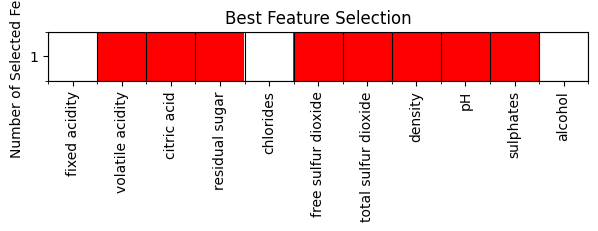

In [ ]:
params = {
    #'alpha': [ 0.01, 0.1, 1, 10, 100, 150, 200, 500, 1000],
    'alpha': [1],
    #'number_of_features': [1,2,3,4,5,6,7,8,9,10,20,30,40]
    'number_of_features': [8]
    }

for alpha_ in params['alpha']:
  for number_of_features_to_select in params['number_of_features']:
    rmse_mi_classical, rmse_rf_classical, rmse_xgb_classical= final_mutual_information_classical(number_of_features_to_select)
    rmse_lr_miq, rmse_rf_miq, rmse_xgb_miq= final_mutual_information_qc(alpha_, number_of_features_to_select)
    rmse_lr, rmse_rf, rmse_xgb= final_linear_regression(alpha_, number_of_features_to_select)
    rmse_lr_rf, rmse_rf_rf, rmse_xgb_rf= final_random_forest(alpha_, number_of_features_to_select)
    rmse_lr_xgb, rmse_rf_xgb, rmse_xgb_xgb= final_xgboost(alpha_, number_of_features_to_select)


# Results

In [ ]:
def plot_my_df(df, similarityFunc, verticalAx, horizontalAx, datasetName, categories, calledFrom=None):

    sns.set(style="whitegrid")
    if calledFrom != 'grouped':
        df = df[df['Similarity_method'] == similarityFunc]

    if(similarityFunc == 'MI_QC'):
        label_name = 'Current '

    elif(similarityFunc == 'MI_classic'):
        label_name = 'Traditional'
    else:
        label_name = 'Proposed '

    save_image_path = '/content/drive/MyDrive/Colab Notebooks/Predict BSS/Result_feature_selection/images/'+datasetName+verticalAx+horizontalAx+label_name+similarityFunc+'.png'
    if not df.empty:
        plt.figure(figsize=(12, 5), dpi=120)

        target_methods = df[categories].unique()
        colors = plt.cm.viridis(np.linspace(0, 1, len(target_methods)))  # Create a color map
        markers = ['o', '*', '^', 's', 'p', 'D', '+', 'x']  # List of markers


        if len(markers) < len(target_methods):
            markers *= (len(target_methods) // len(markers) + 1)

        overall_best_score = None
        overall_best_details = ("", float('inf')) if verticalAx == "RMSE" else ("", float('-inf'))  # Initialize for max or min comparison


        for method, color, marker in zip(target_methods, colors, markers):
            method_data = df[df[categories] == method]
            method_data = method_data.sort_values(by=horizontalAx)  # Sorting by horizontalAx for correct plotting order


            if verticalAx == "RMSE":
                bestVerticalAx = method_data[verticalAx].min()
                if bestVerticalAx < overall_best_details[1]:
                    overall_best_details = (method, bestVerticalAx)
            elif verticalAx == "R_squared":
                bestVerticalAx = method_data[verticalAx].max()
                if bestVerticalAx > overall_best_details[1]:
                    overall_best_details = (method, bestVerticalAx)


            plt.plot(method_data[horizontalAx], method_data[verticalAx], linestyle='-.', color=color, marker=marker, markersize=7,
                     label=f"{method} ", alpha=0.7)


        best_score_label = f"Best overall {verticalAx} ({label_name}Method with {overall_best_details[0]}): {overall_best_details[1]:.2f}"

        plt.title(verticalAx + ' by '+ horizontalAx + ' for ' + datasetName + ' Dataset, '+ label_name +'Method with ' + similarityFunc, fontsize=12)
        plt.xlabel(horizontalAx)
        plt.ylabel(verticalAx)

        min_value = df[verticalAx].min()
        max_value = df[verticalAx].max()
        plt.ylim(min_value - (0.1 * min_value), max_value + (0.1 * max_value))

        plt.annotate(best_score_label, xy=(0.5, 0.95), xycoords='axes fraction', ha='center', va='center',
                     fontsize=10, color='black', bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white', alpha=0.7))

        plt.legend(title=categories, loc='upper right', fontsize='small')

        plt.tight_layout()

        plt.savefig(save_image_path)

        plt.show()
    else:
        print("No data available for the dataset.")



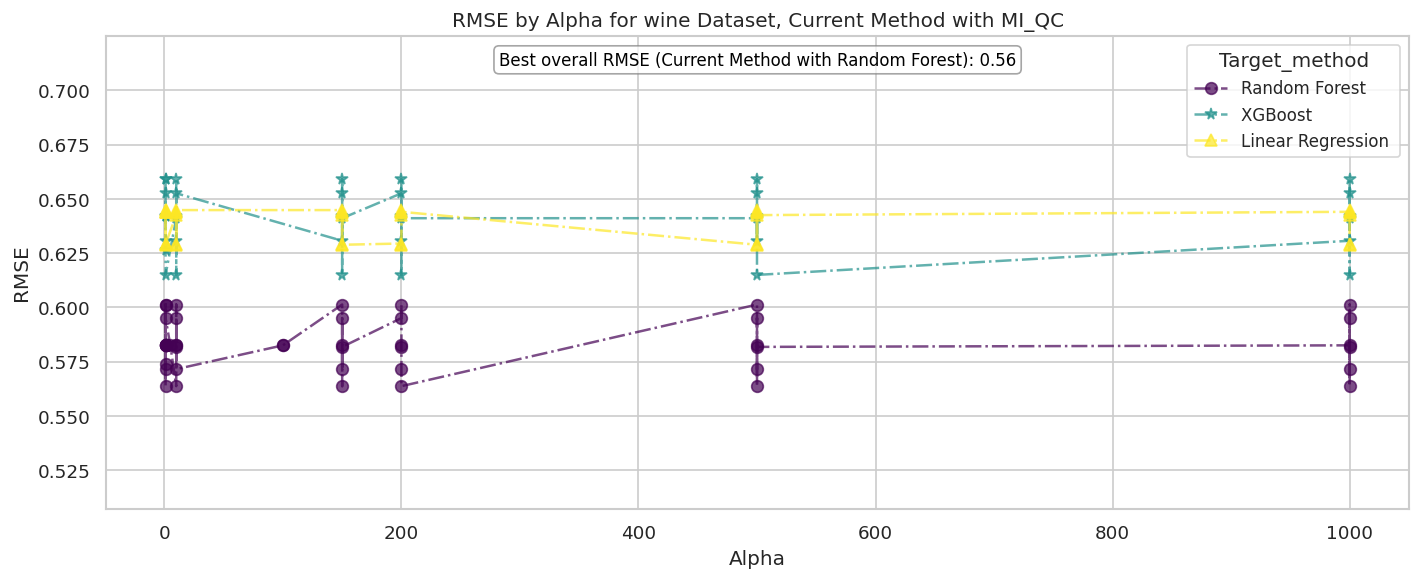

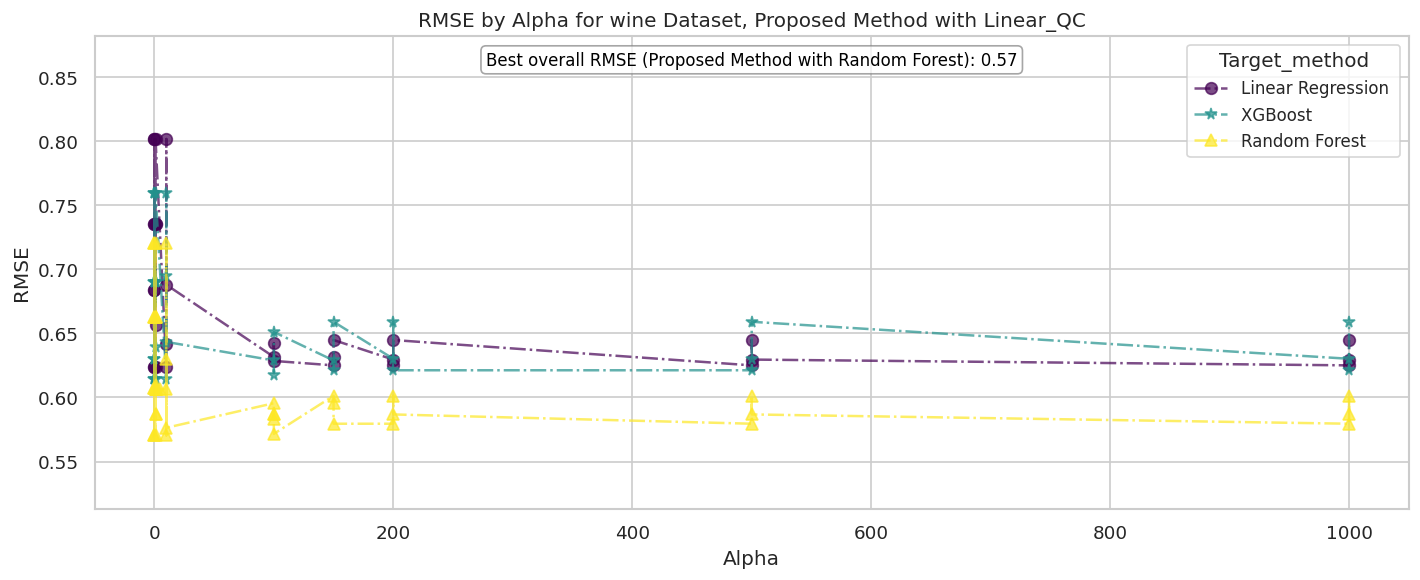

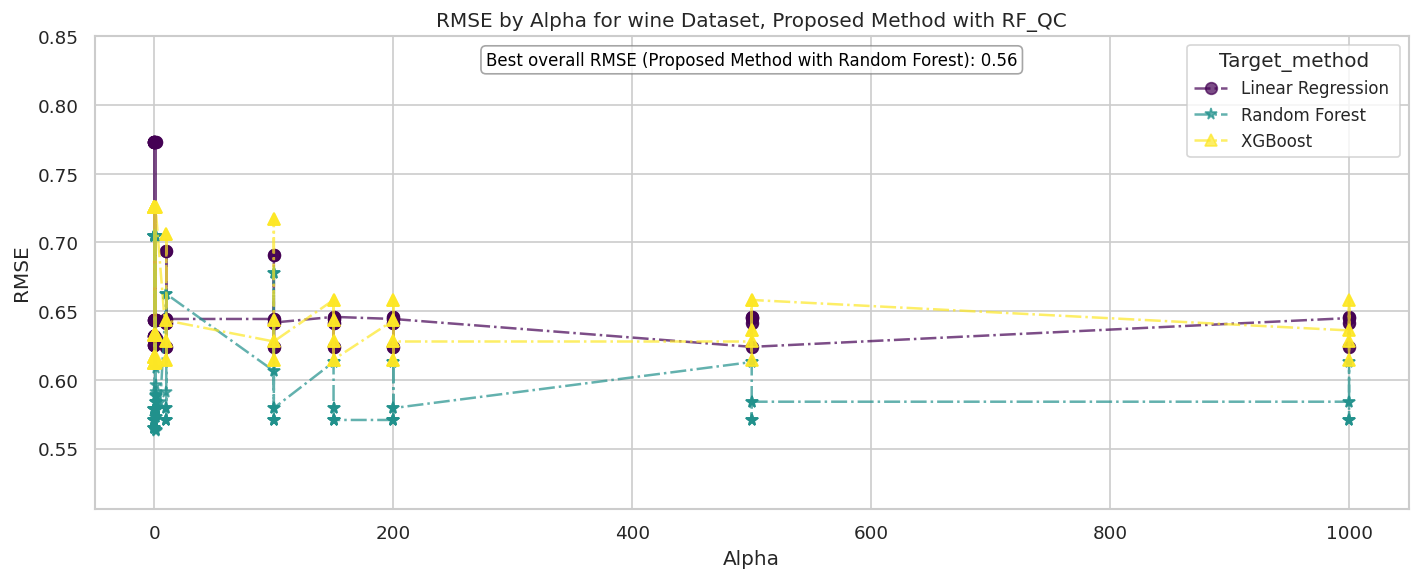

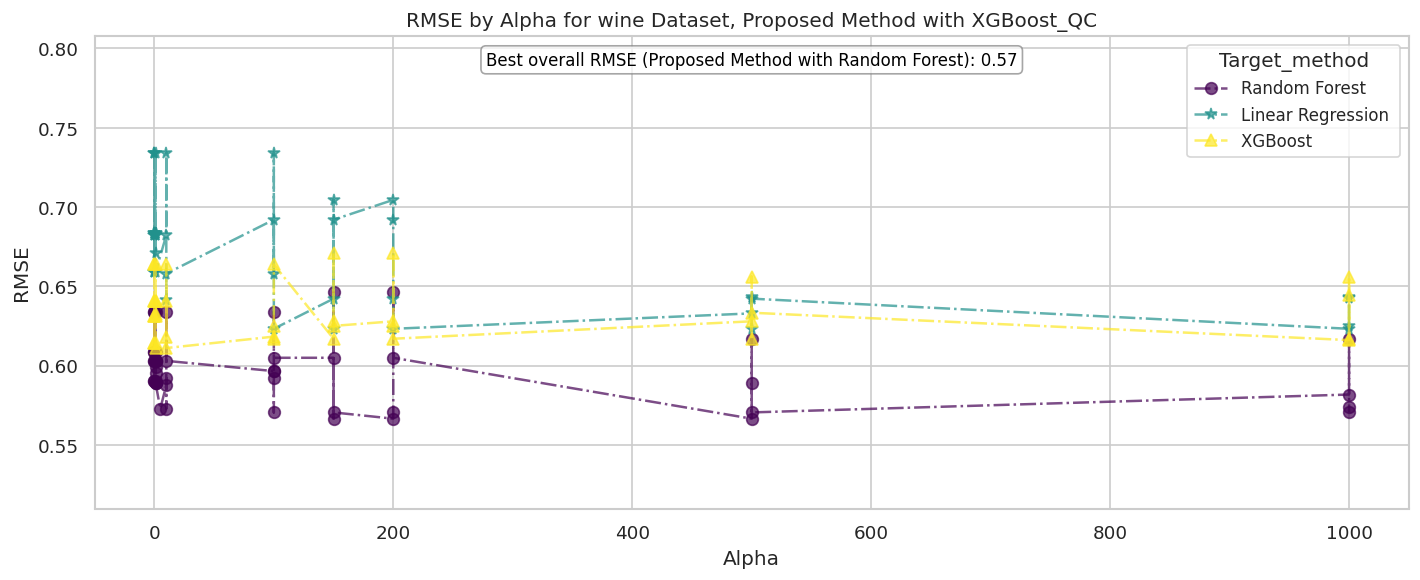

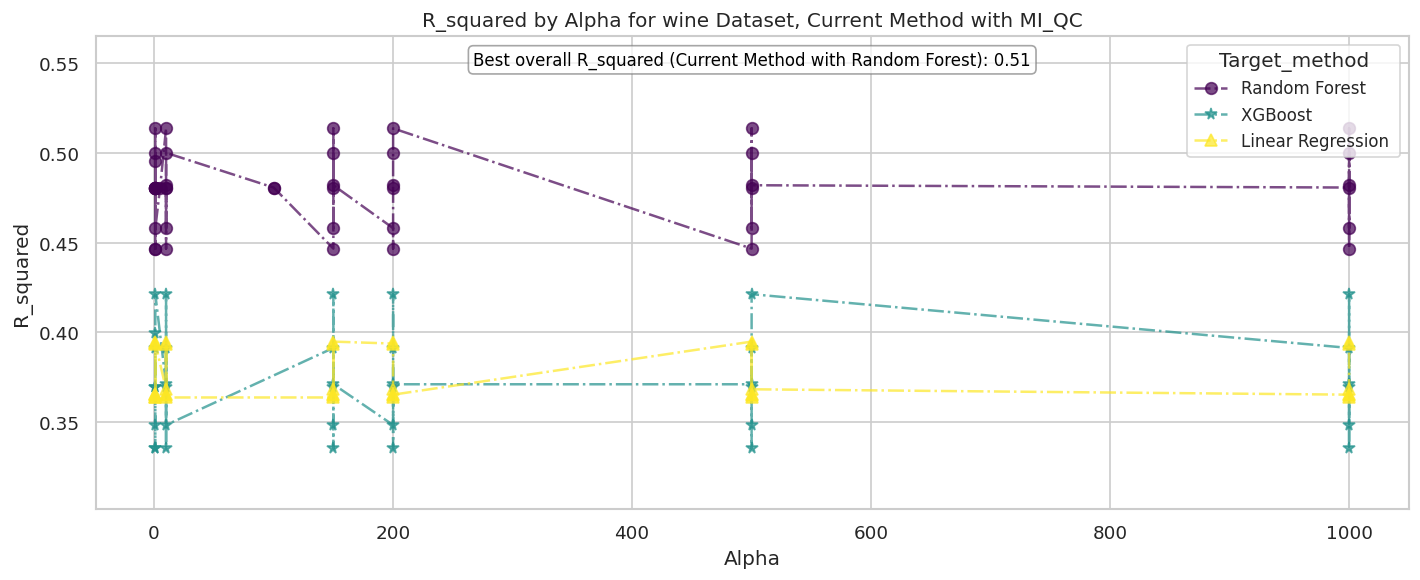

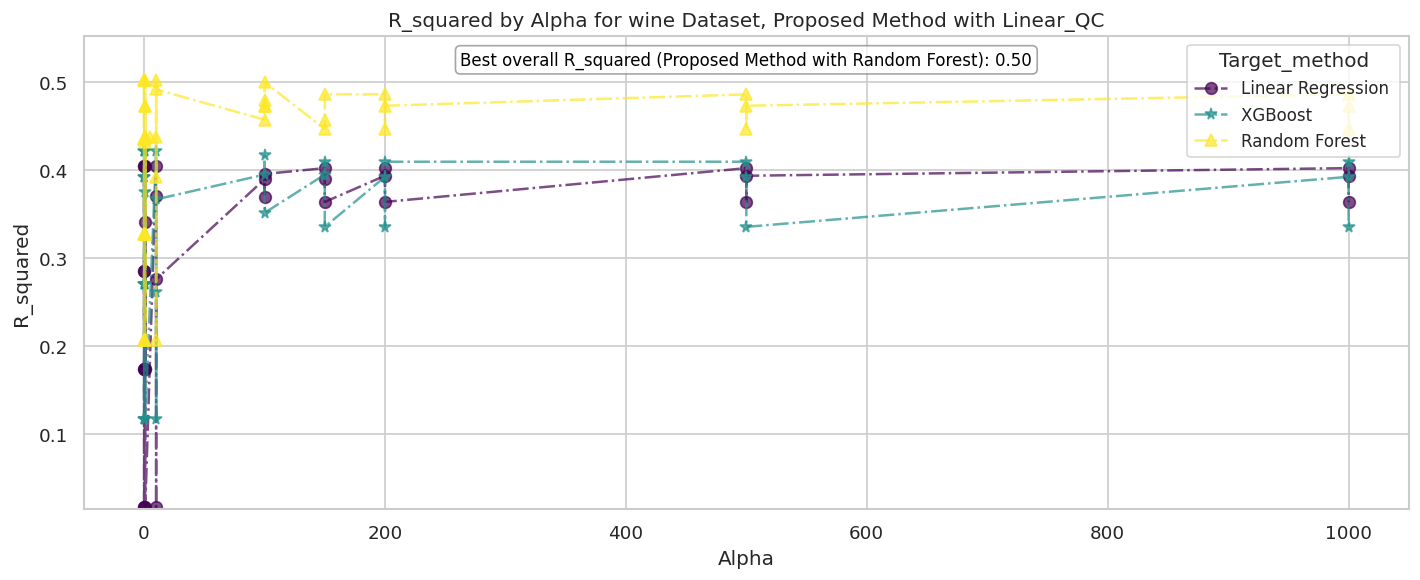

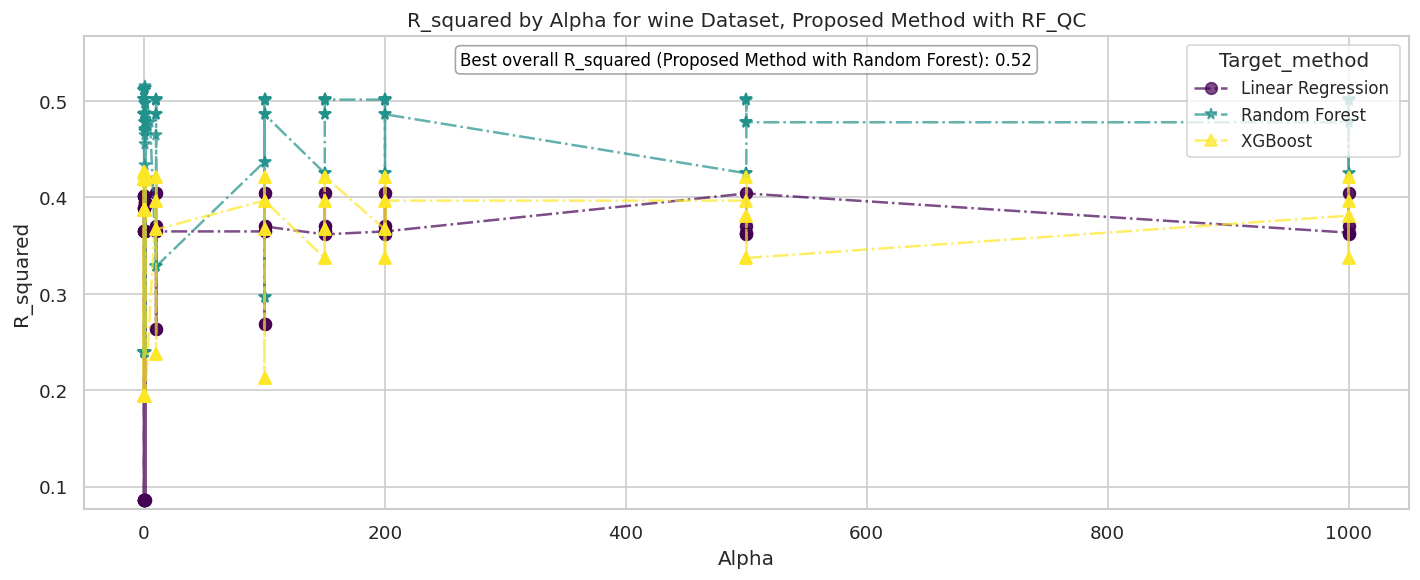

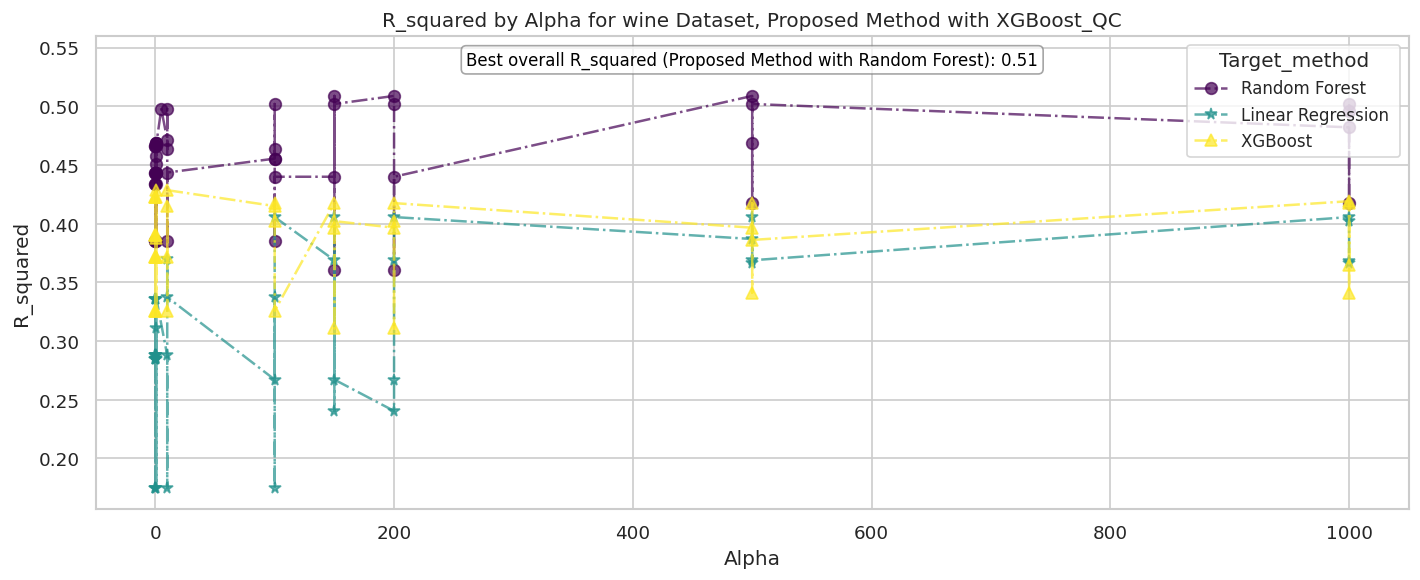

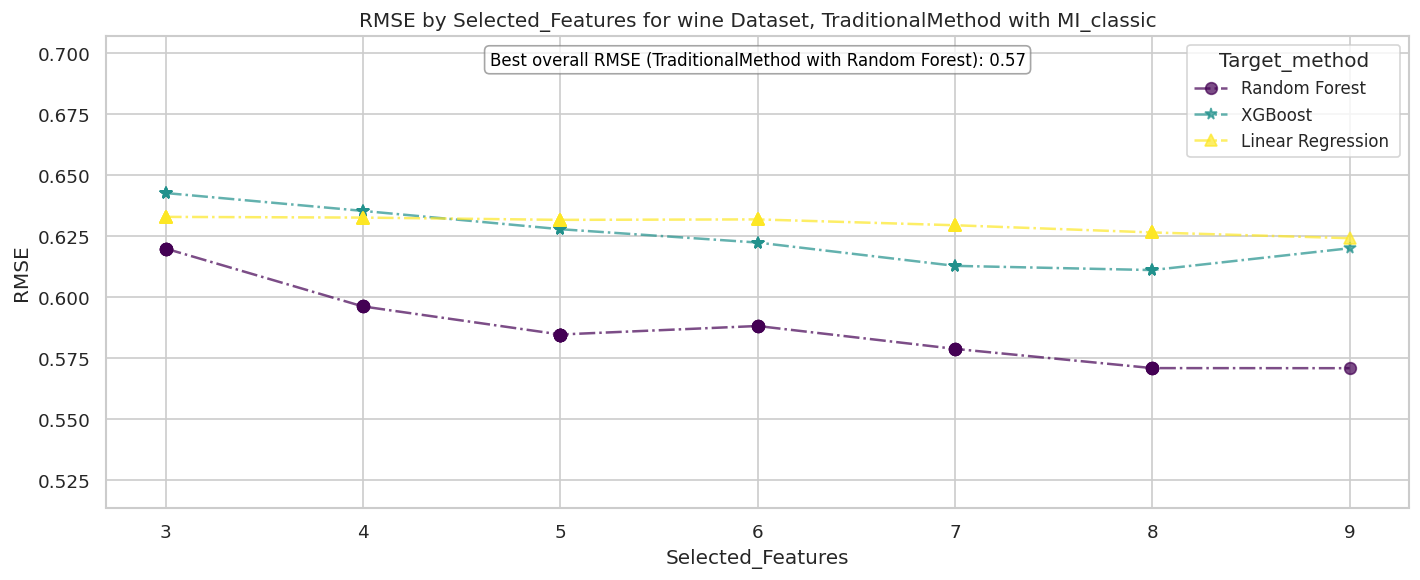

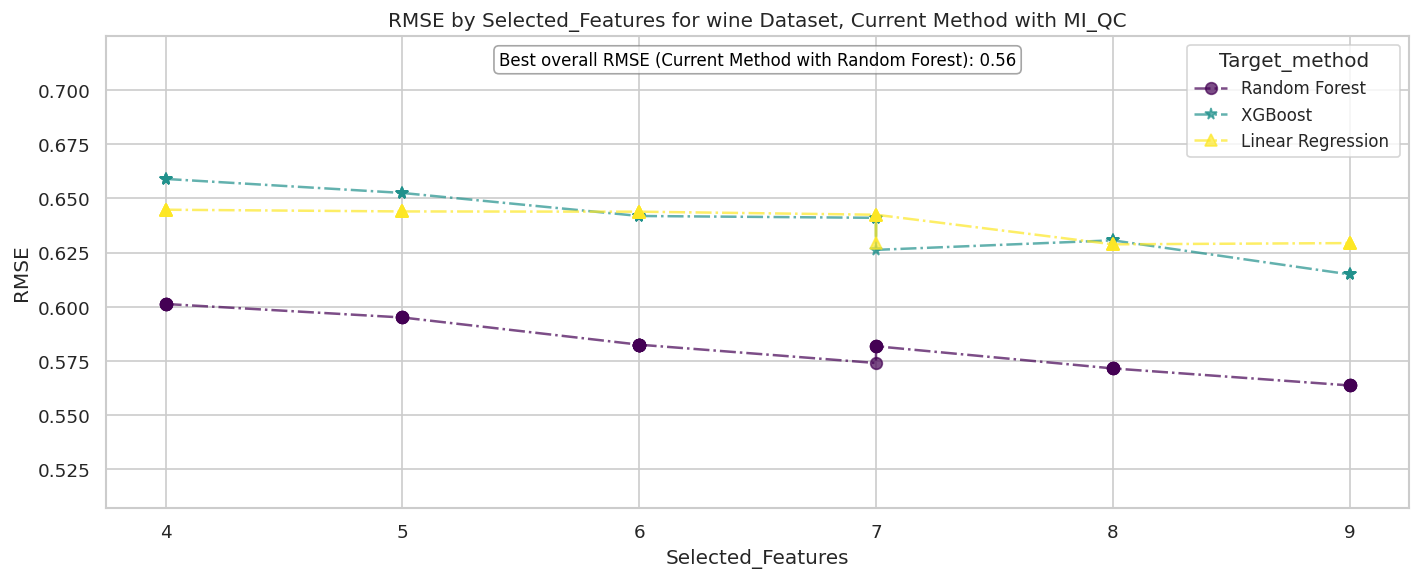

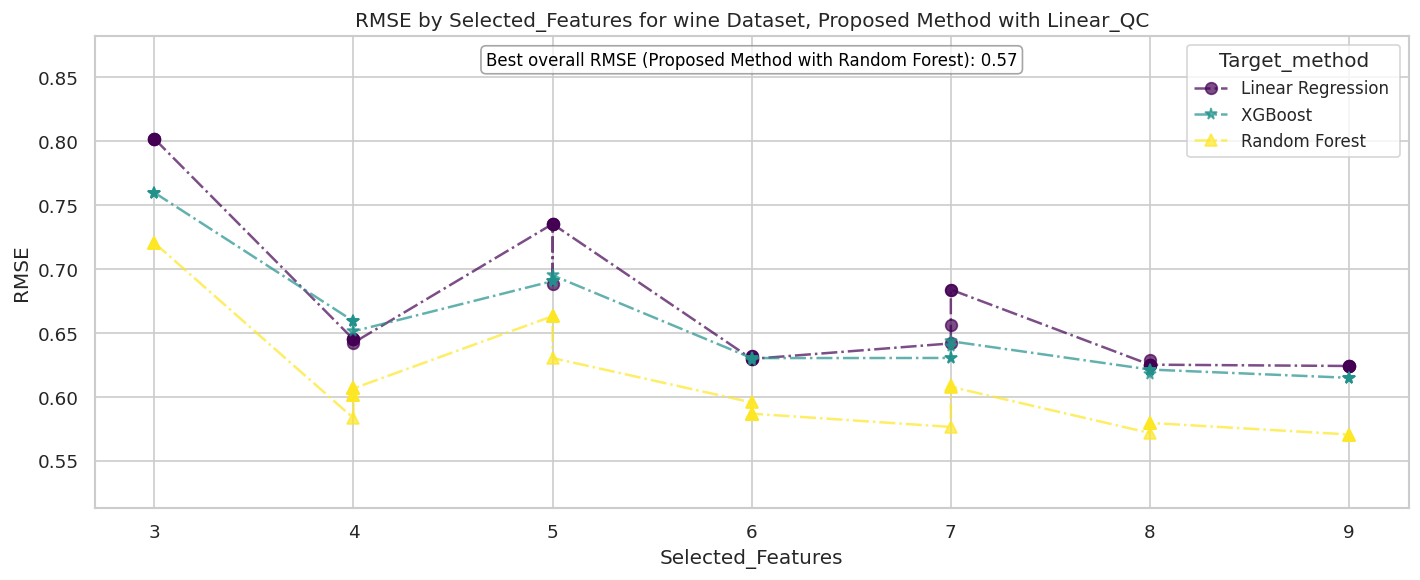

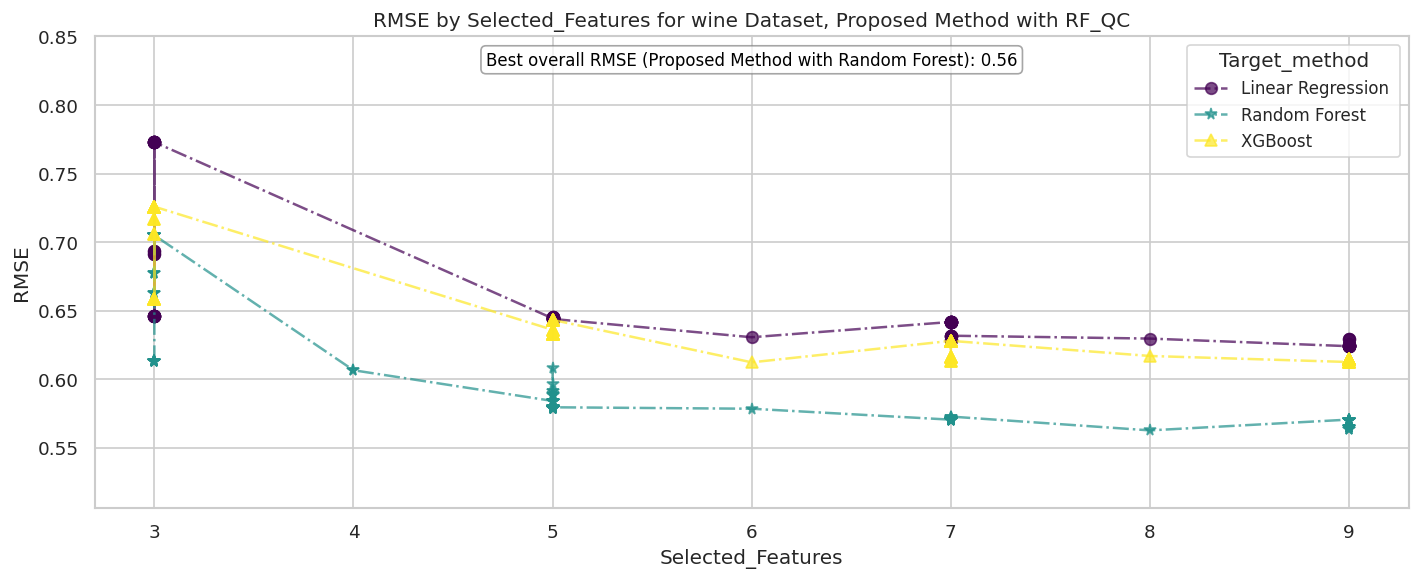

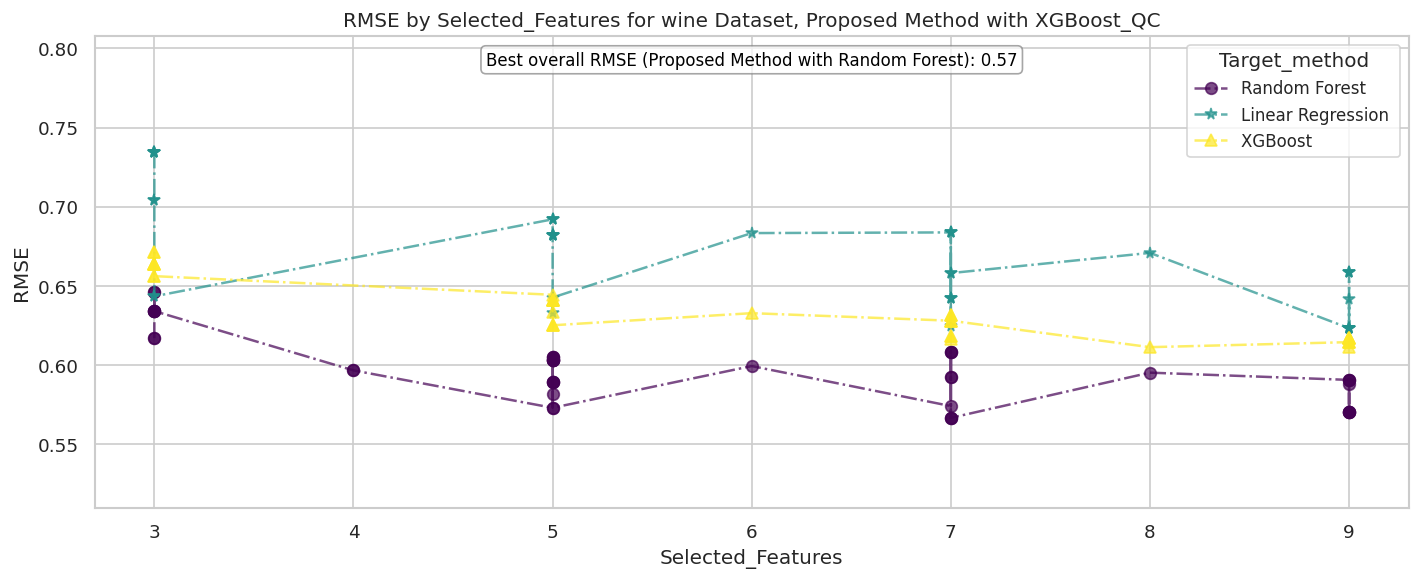

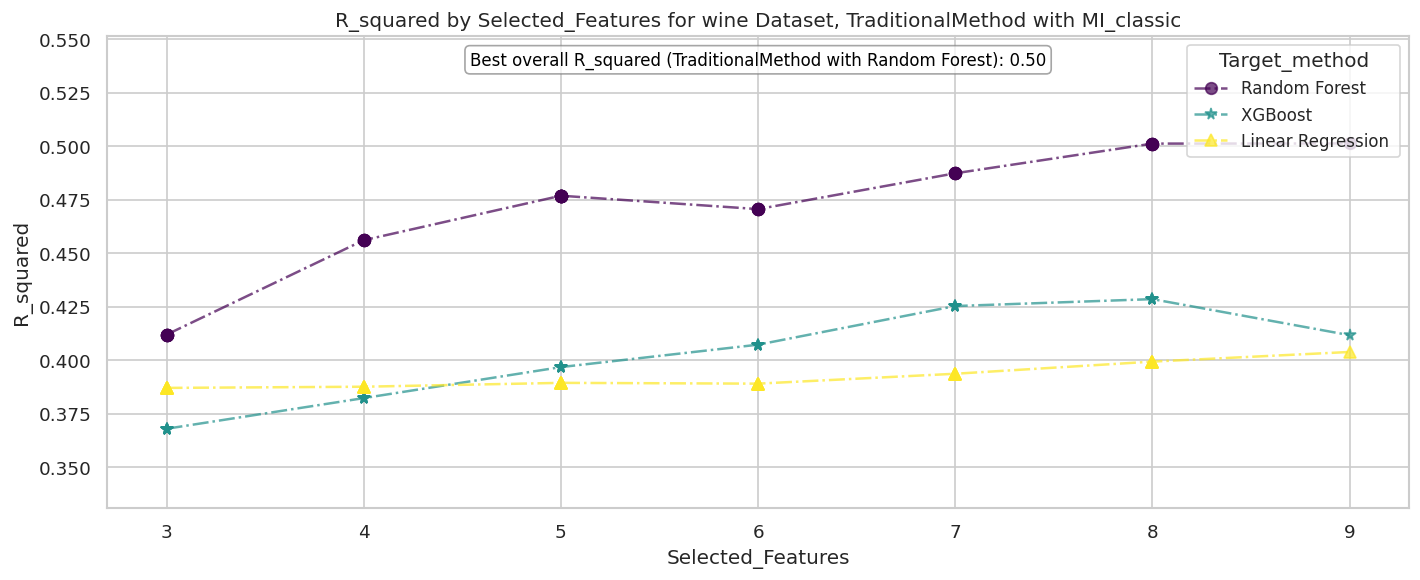

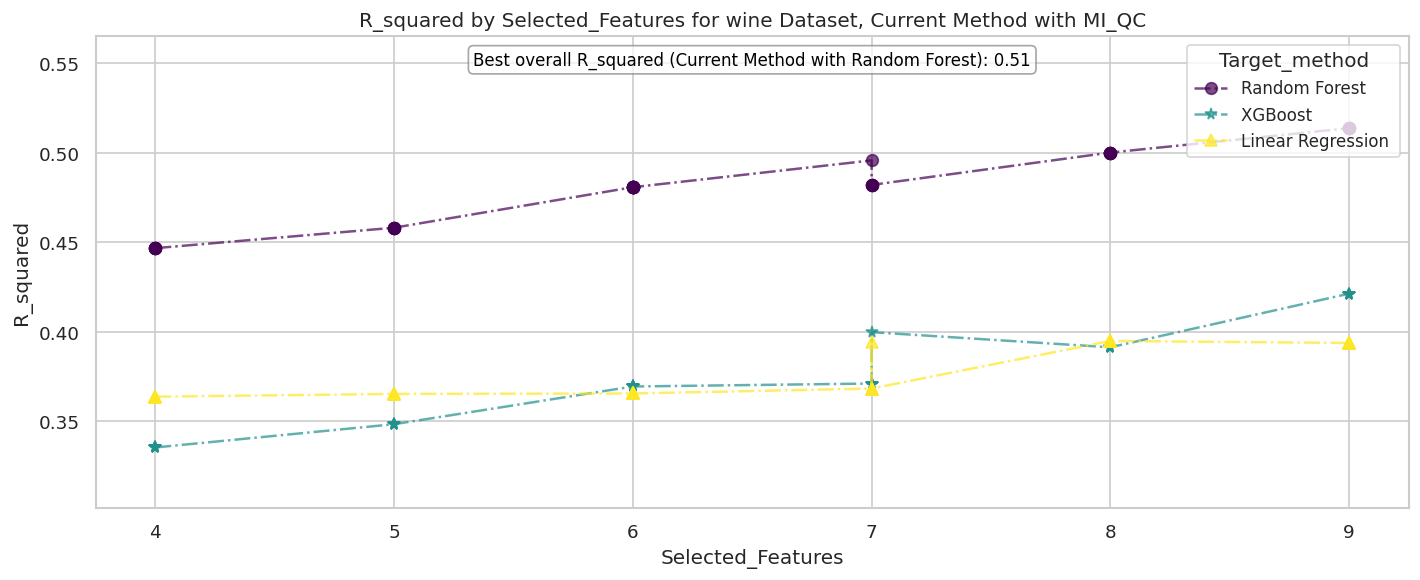

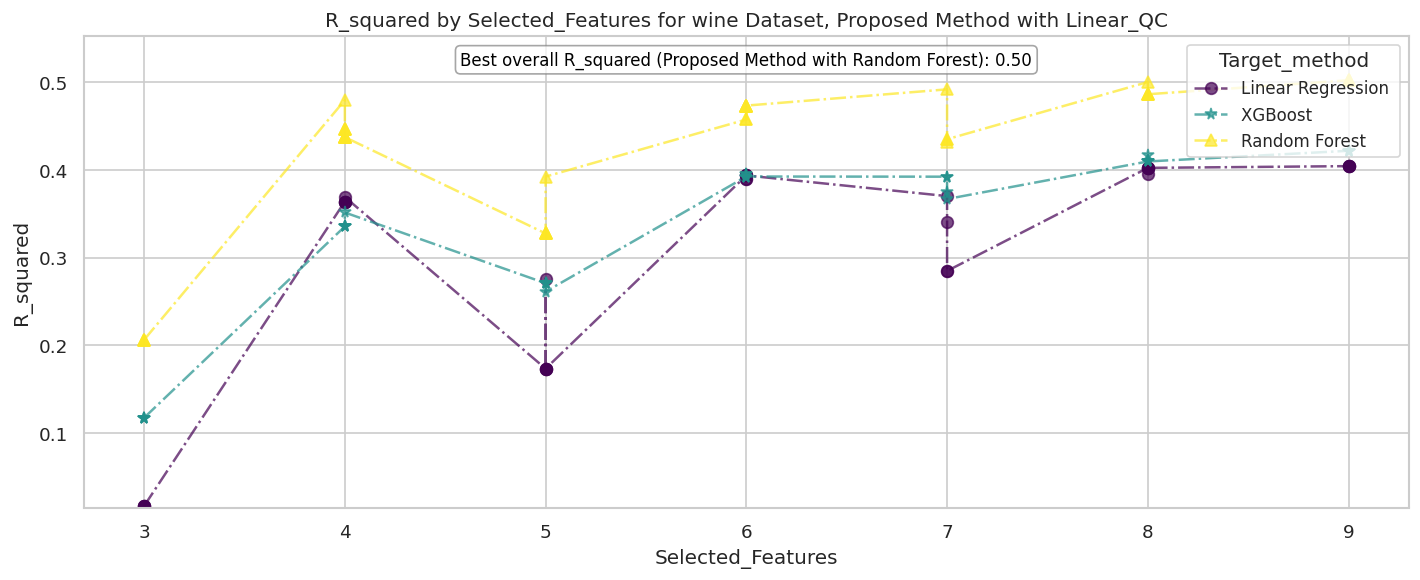

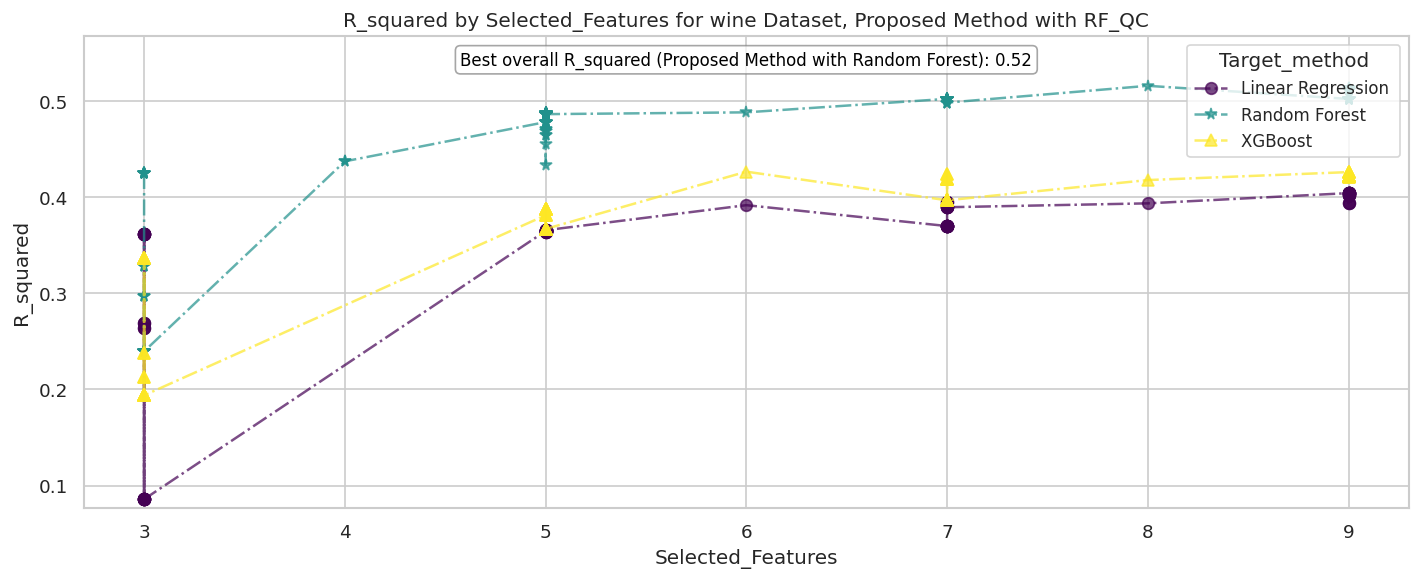

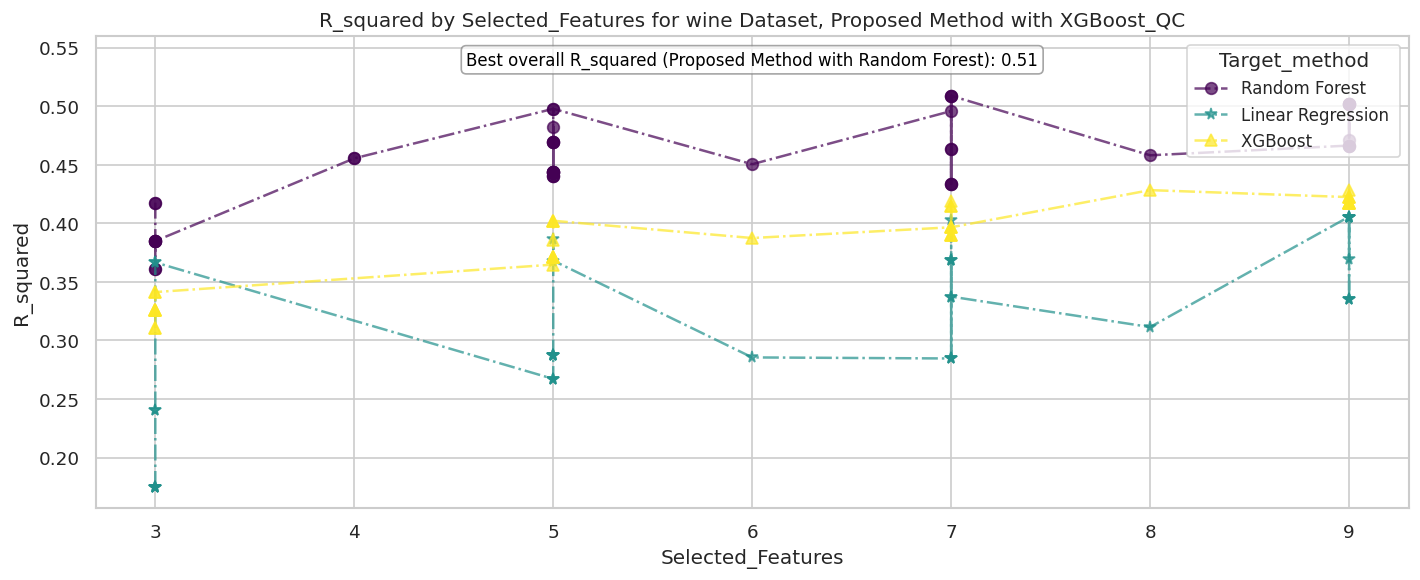

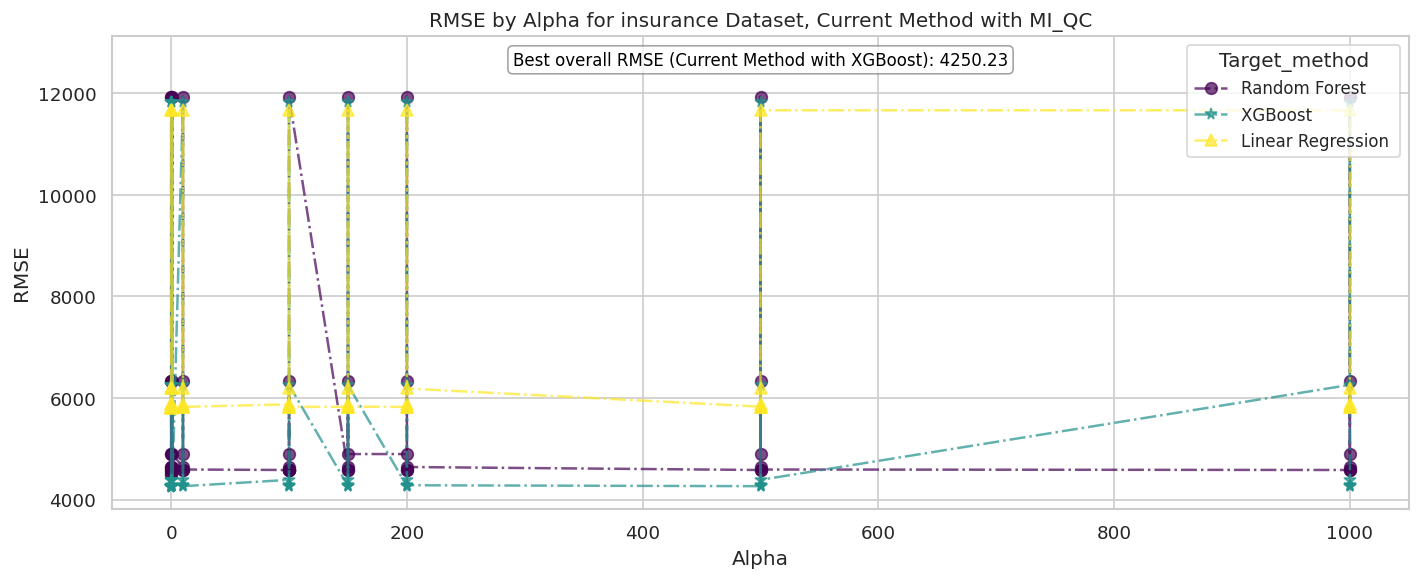

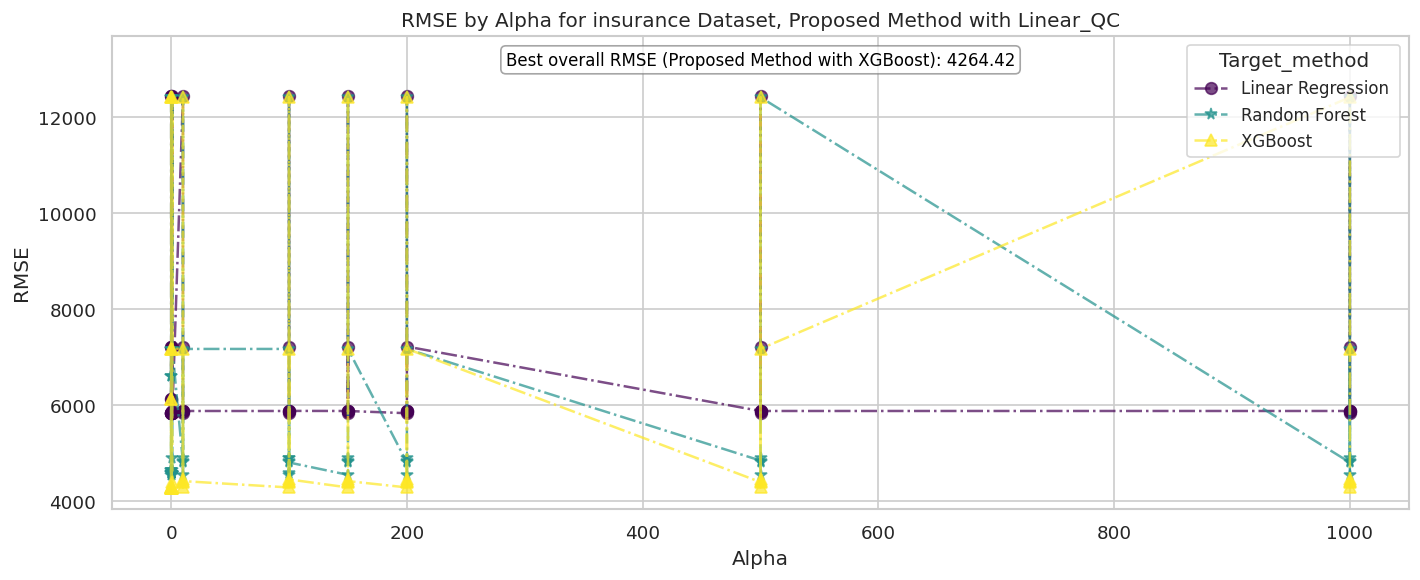

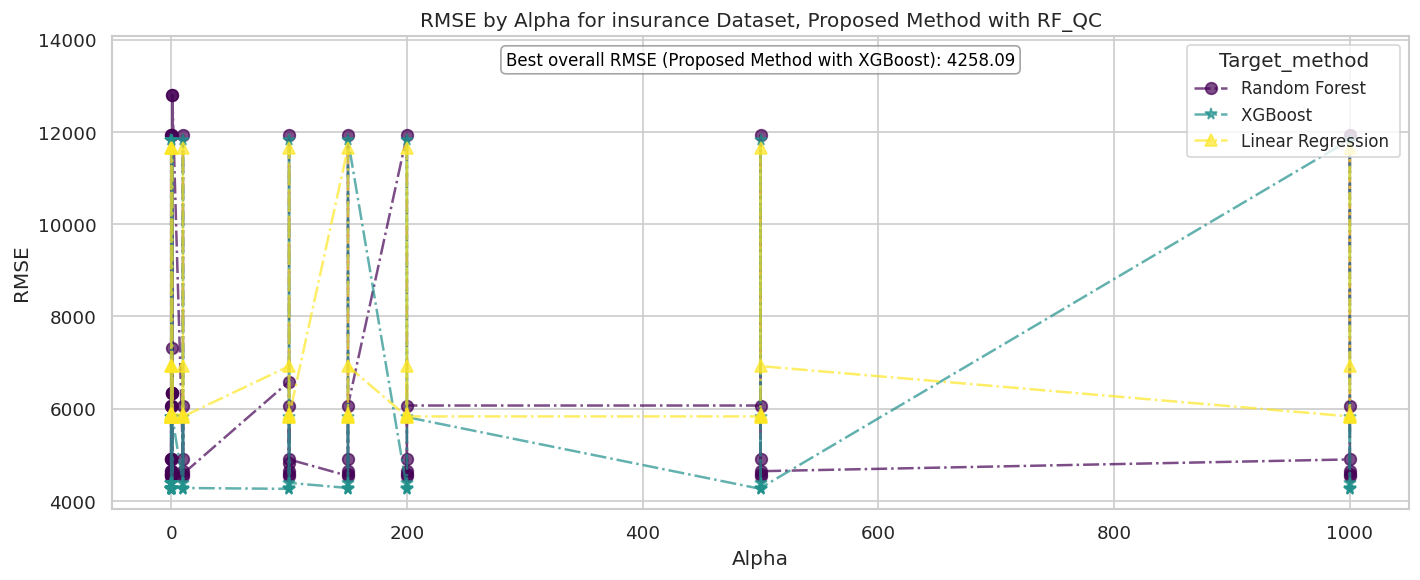

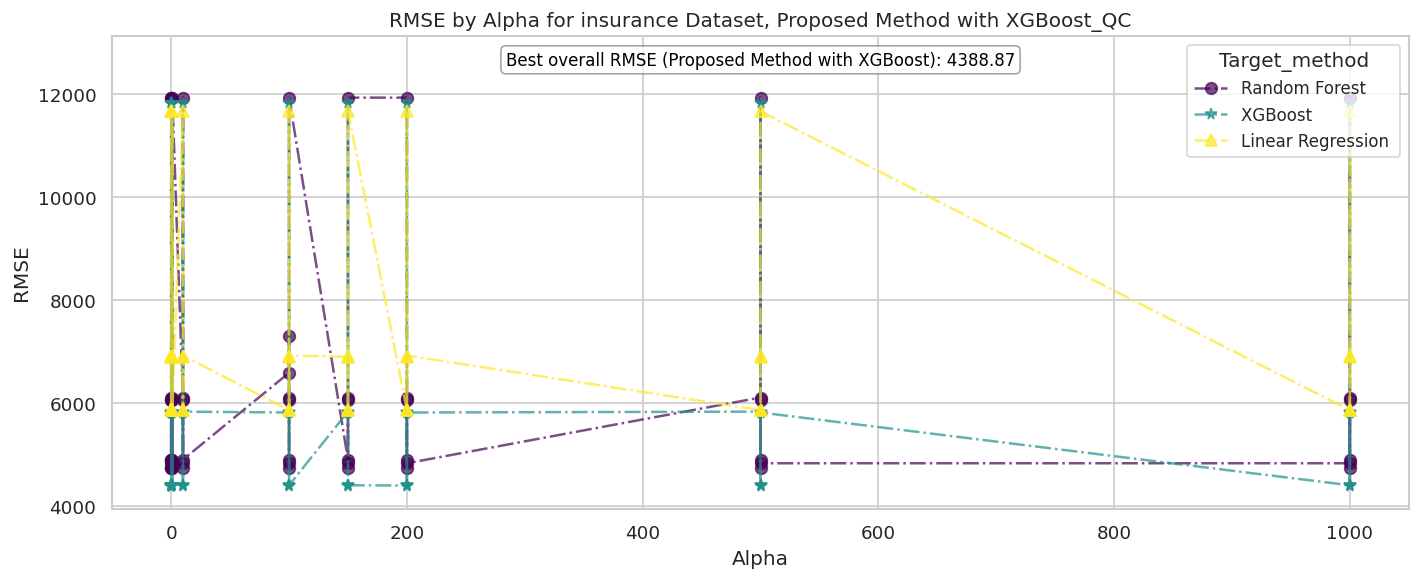

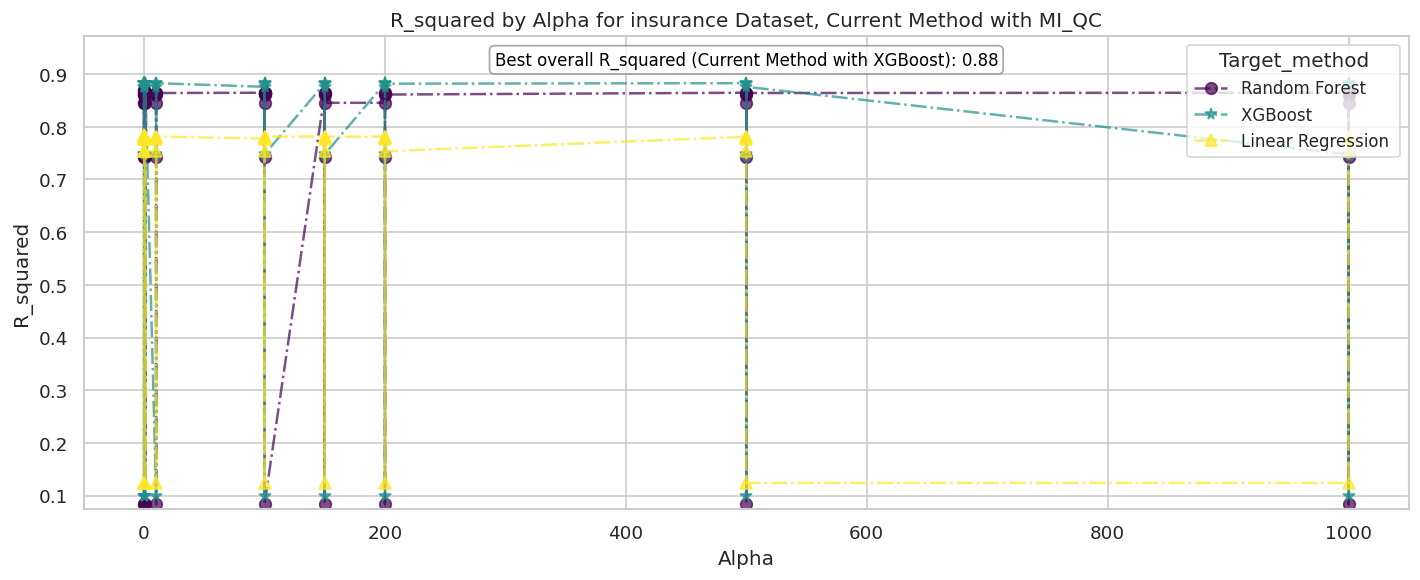

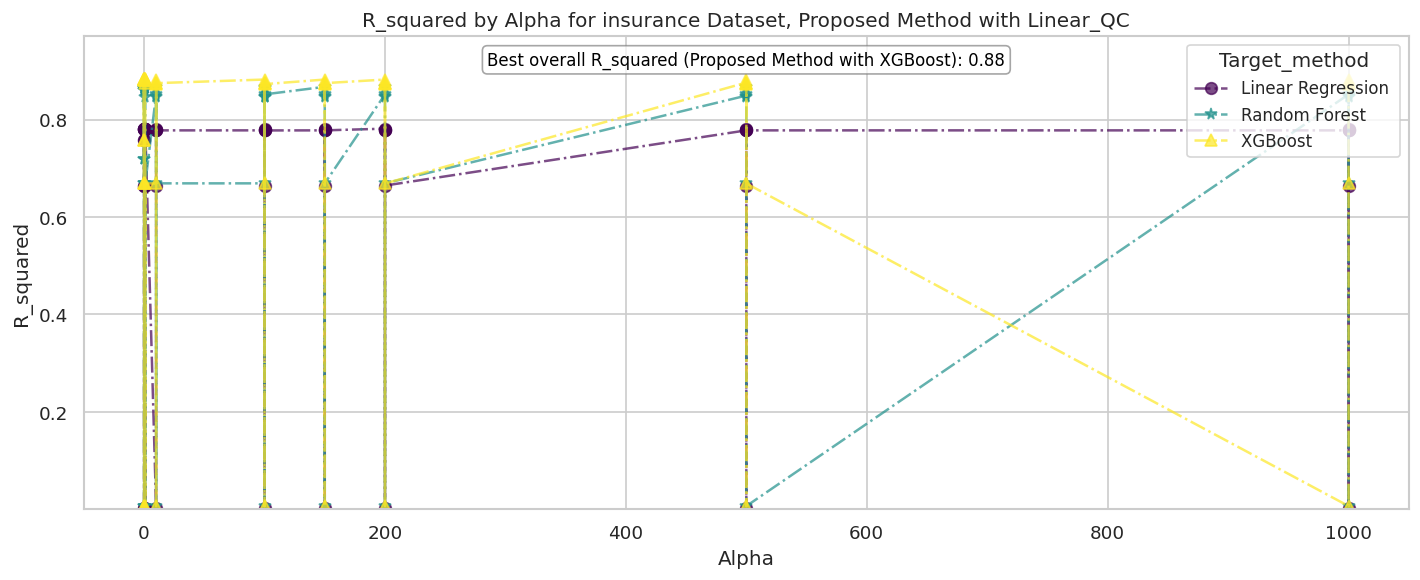

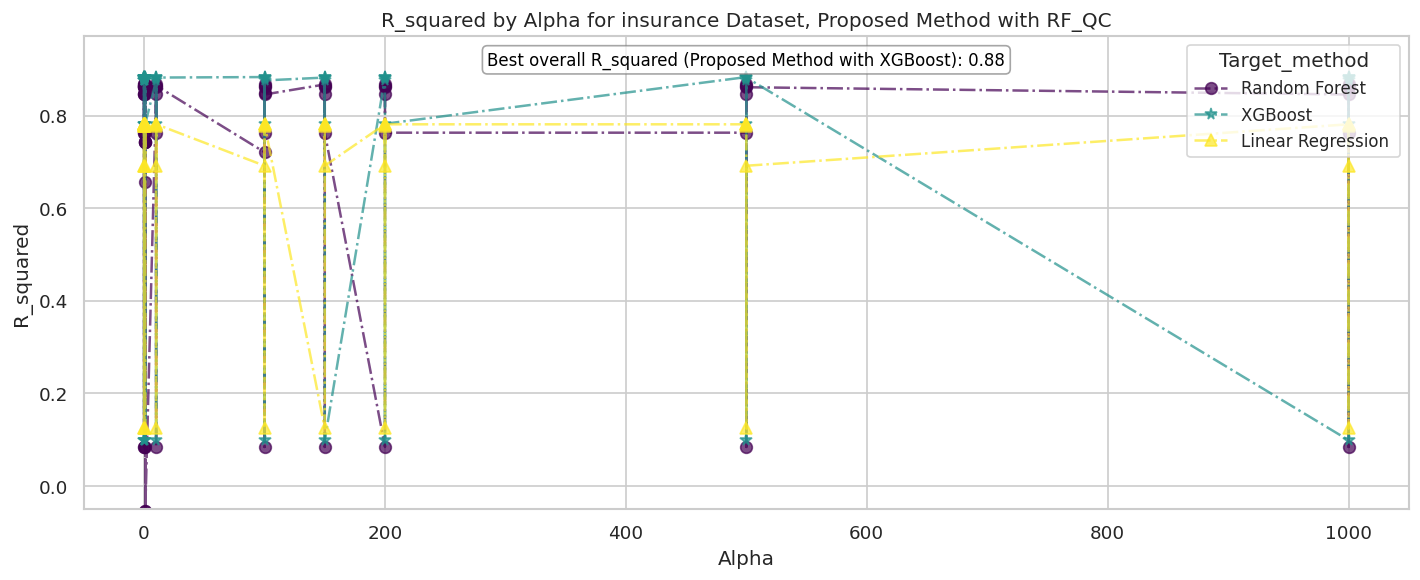

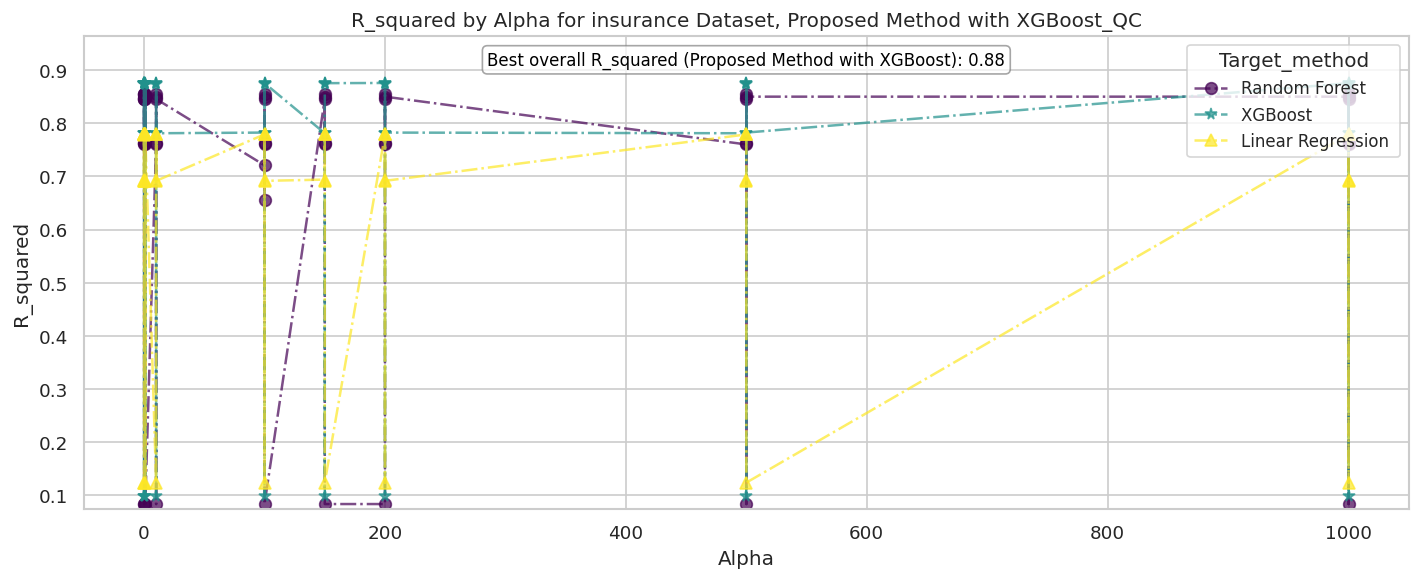

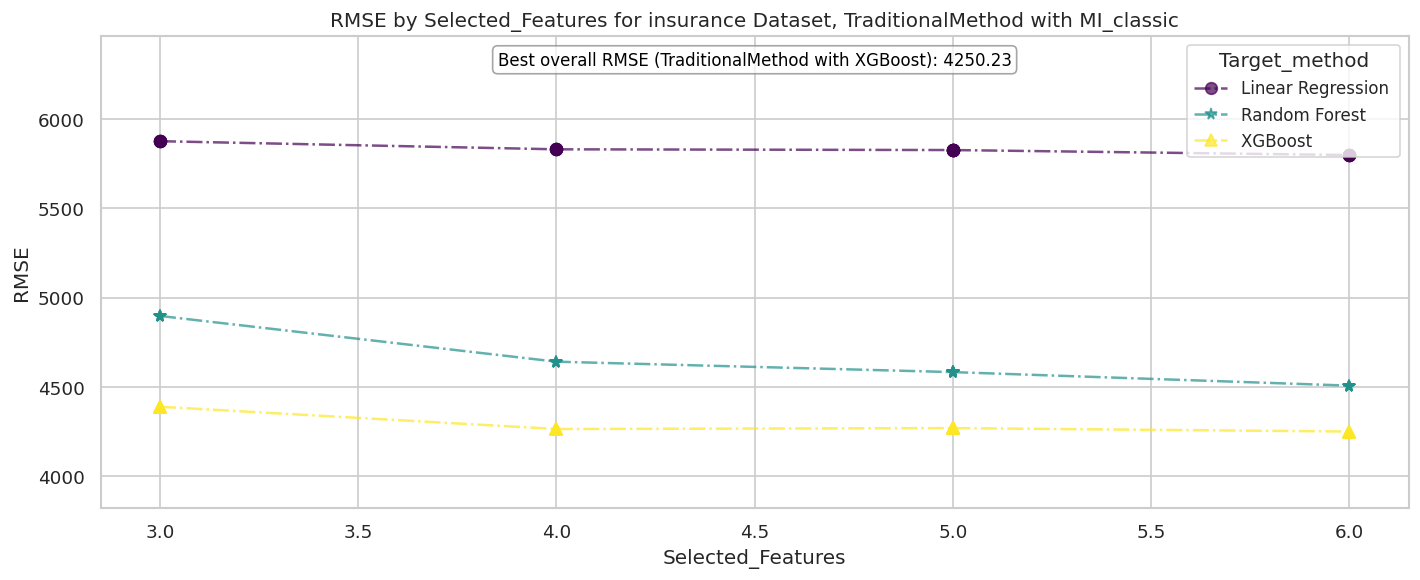

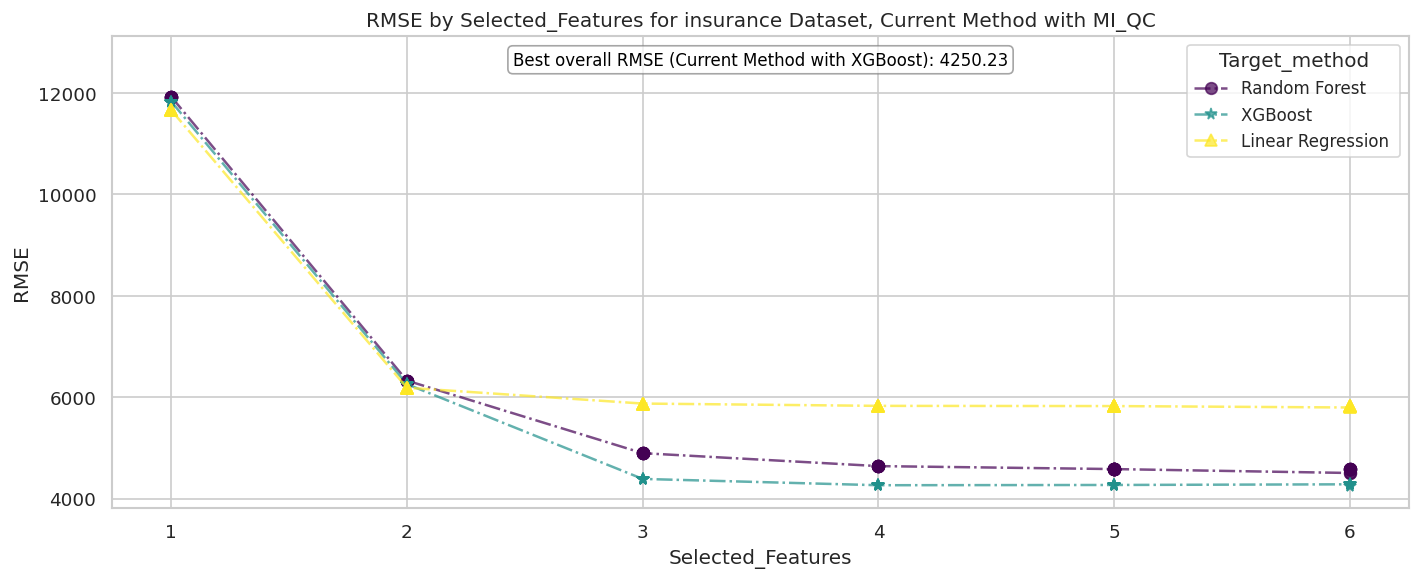

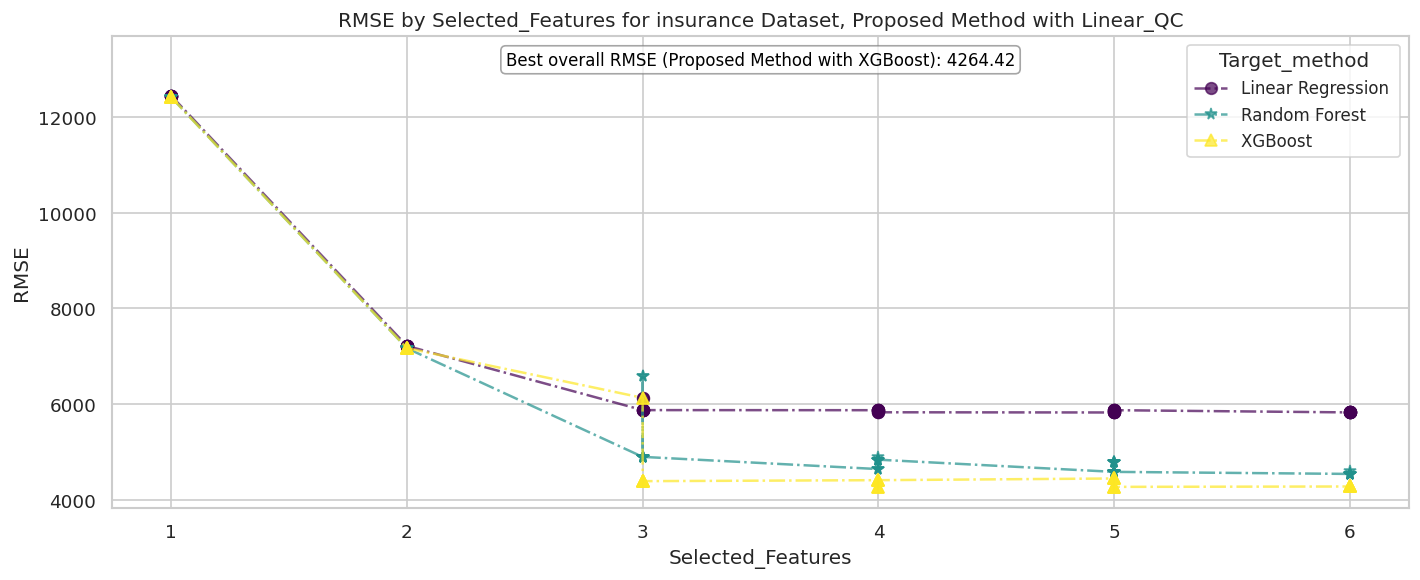

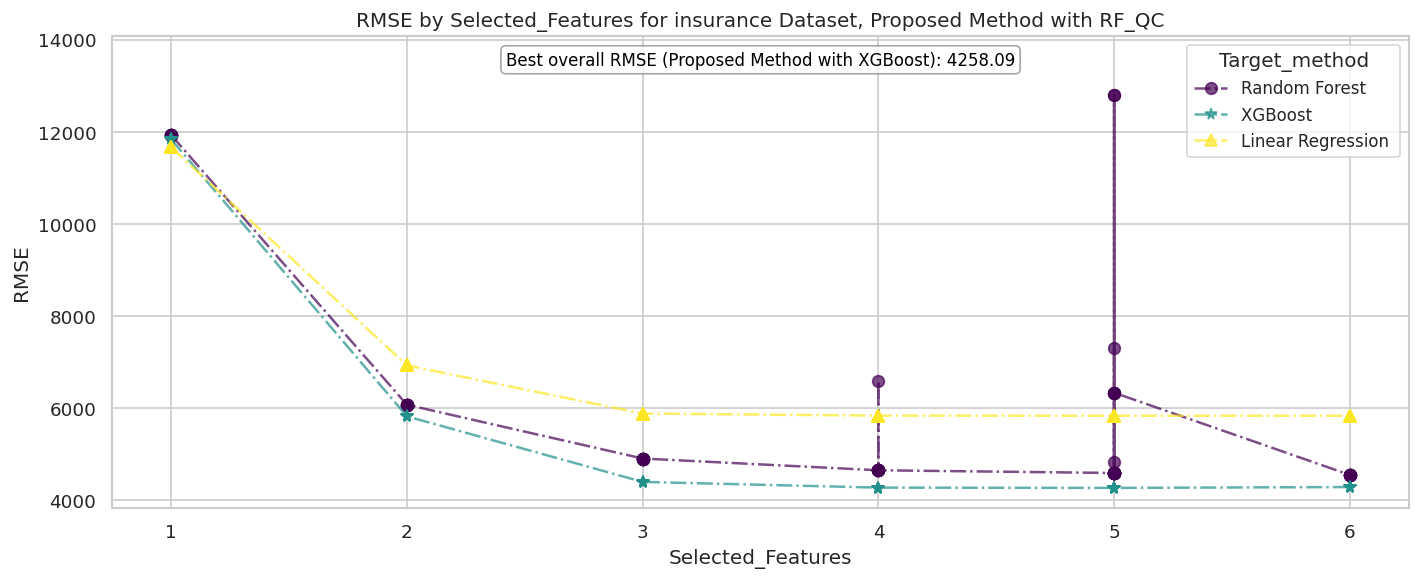

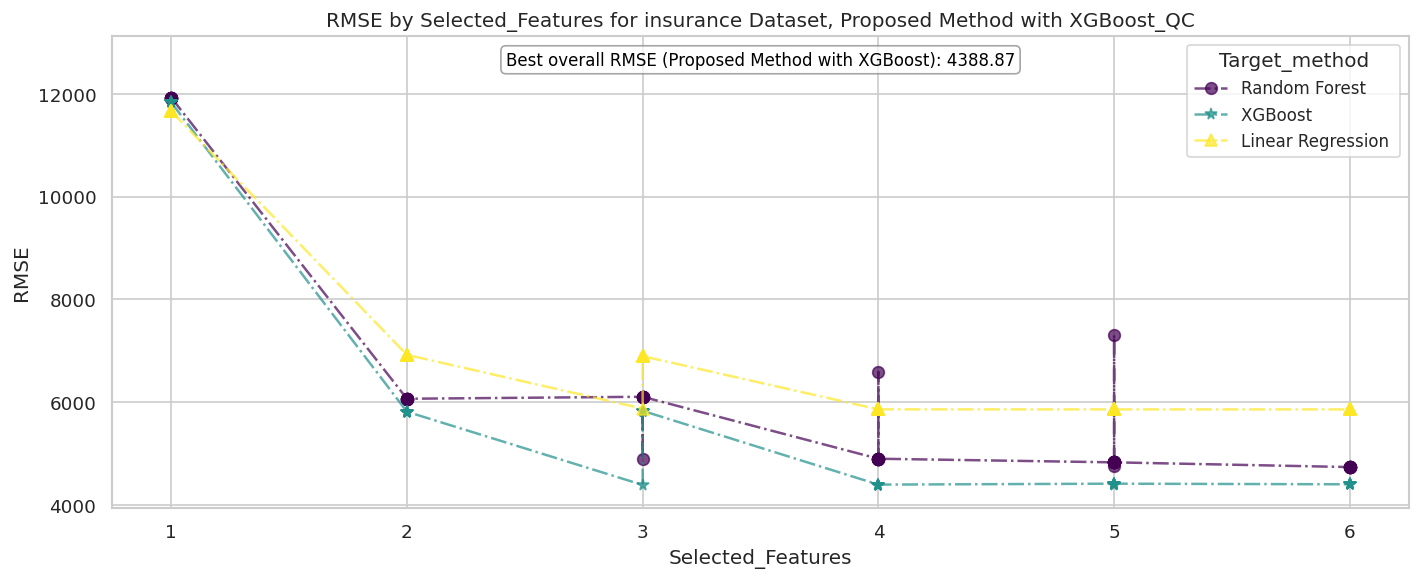

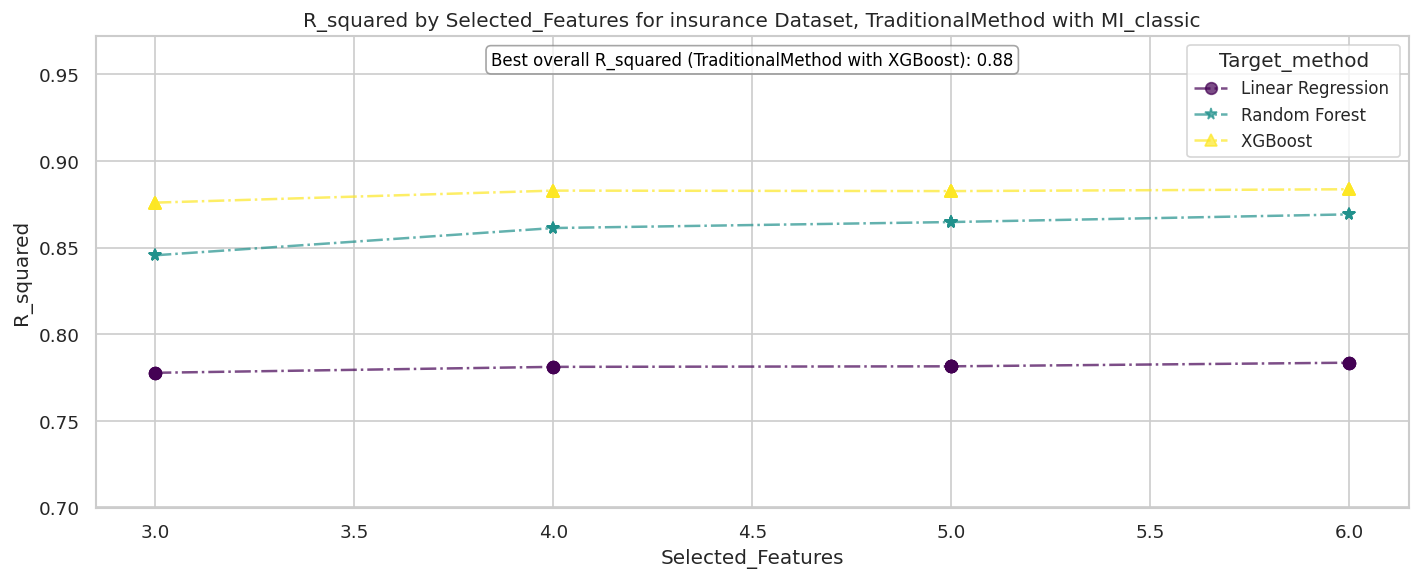

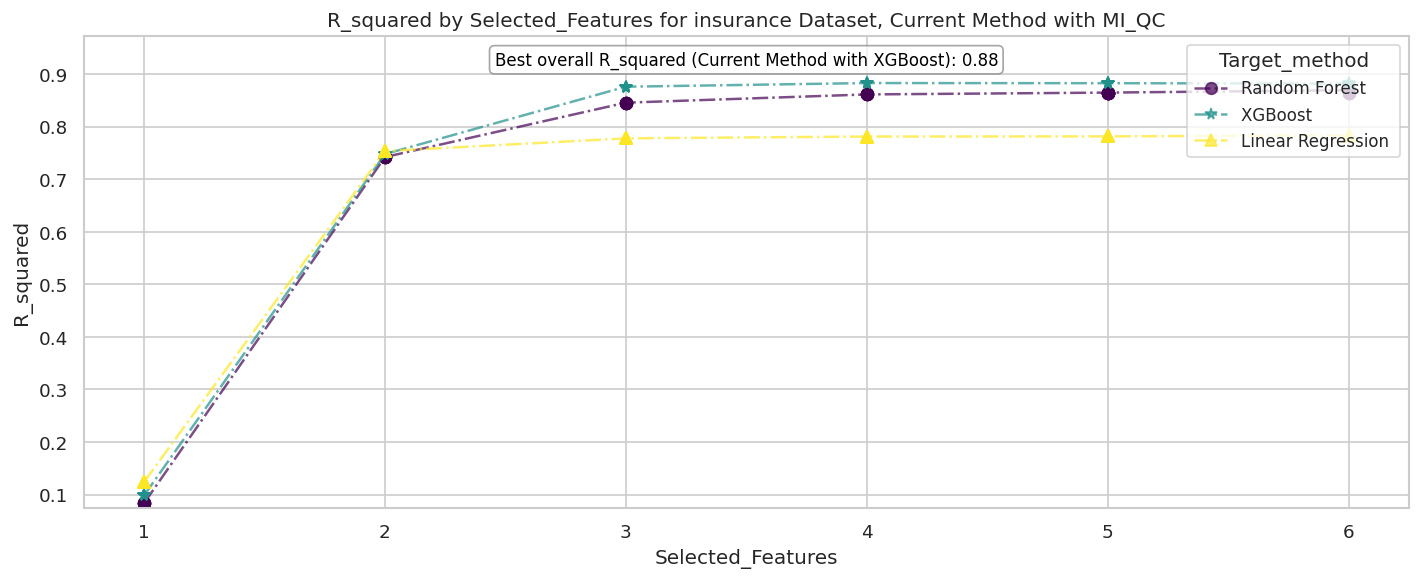

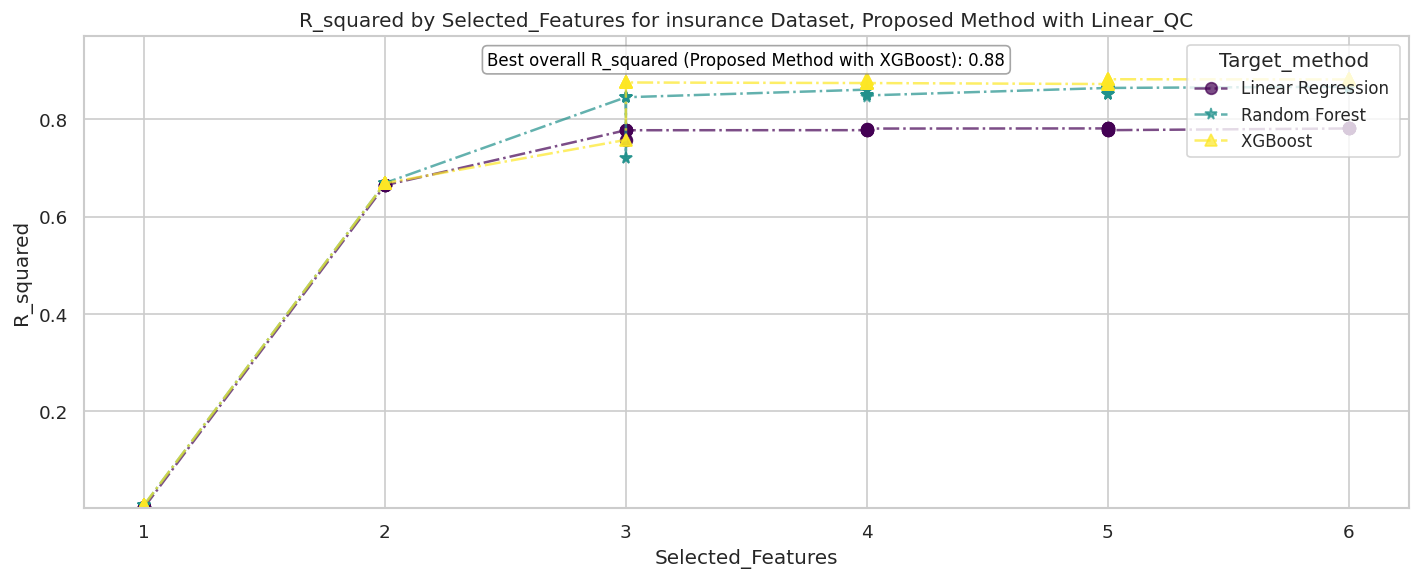

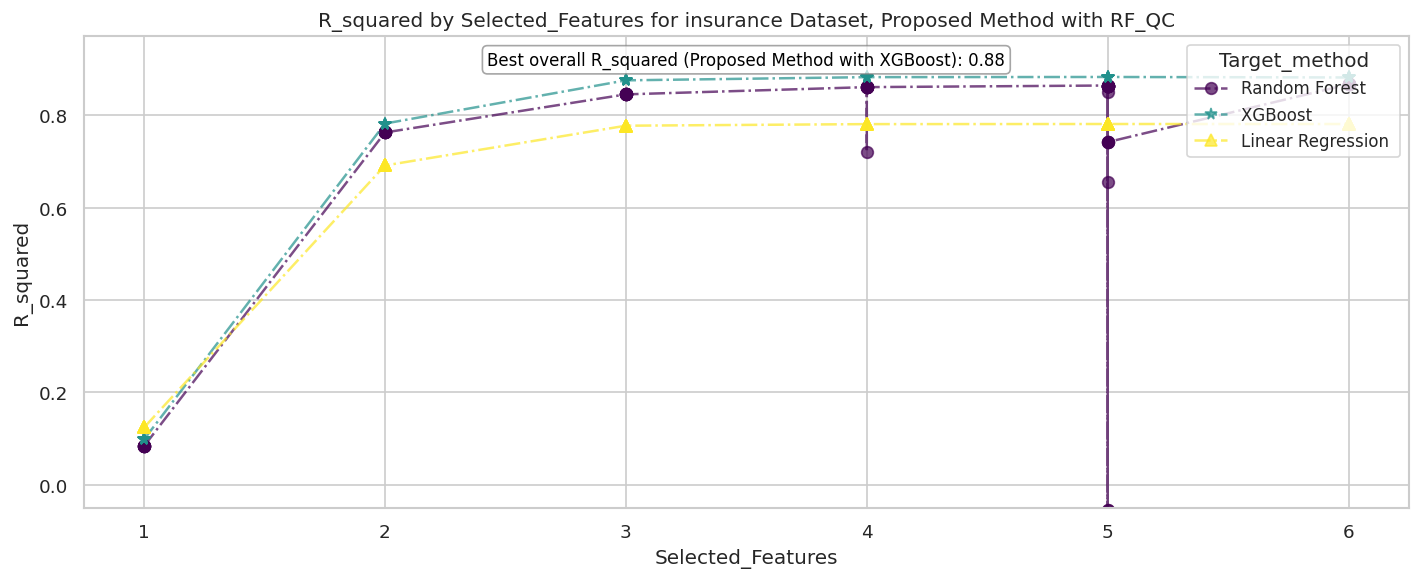

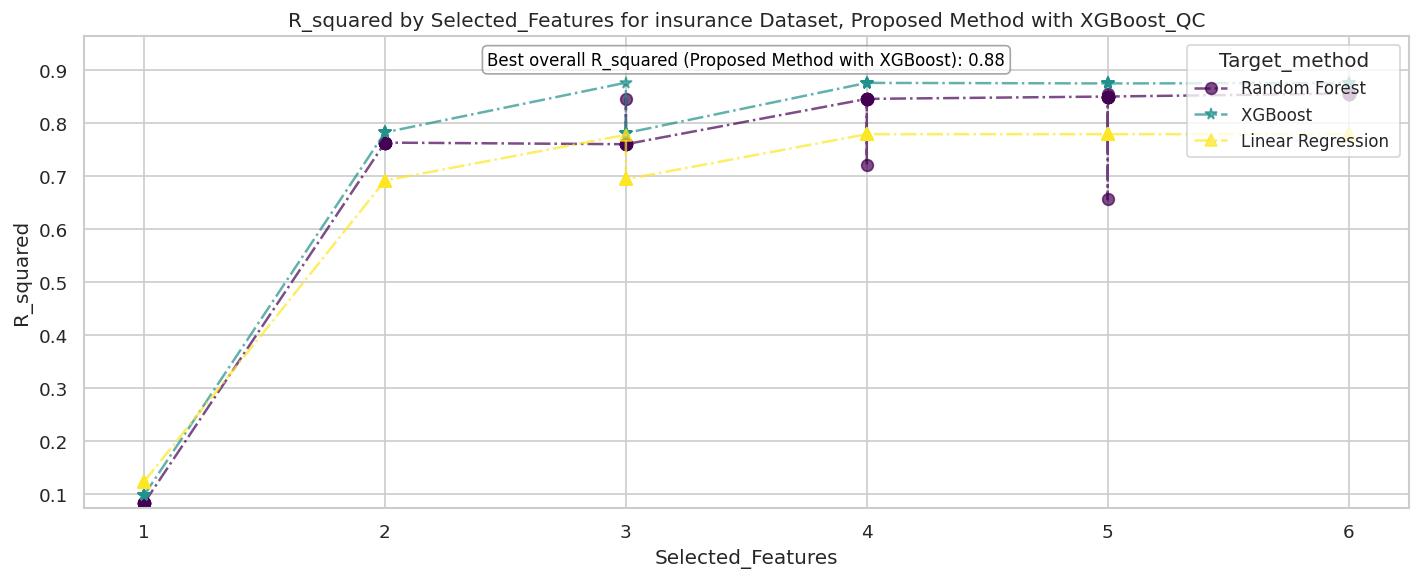

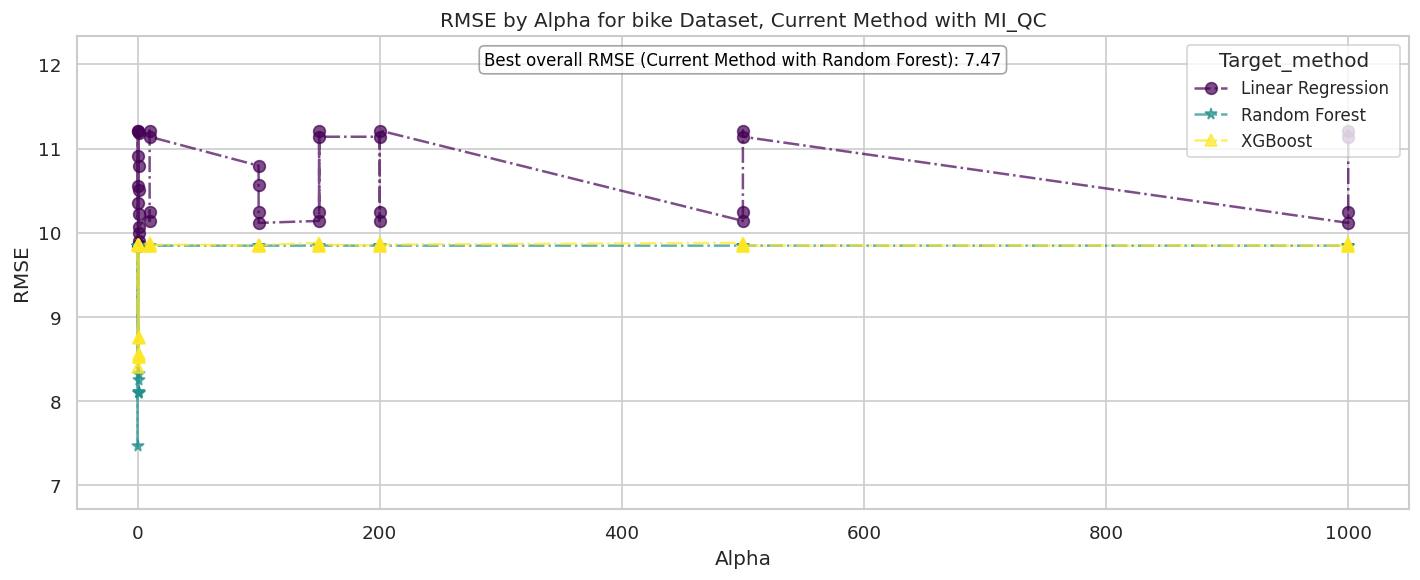

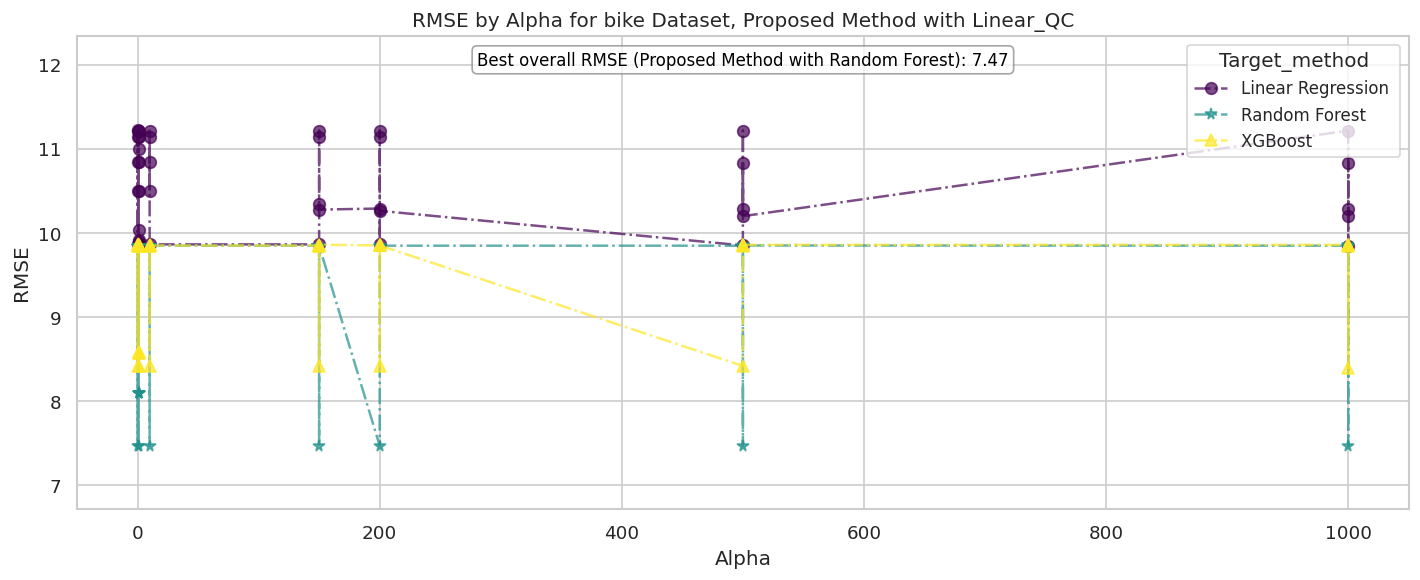

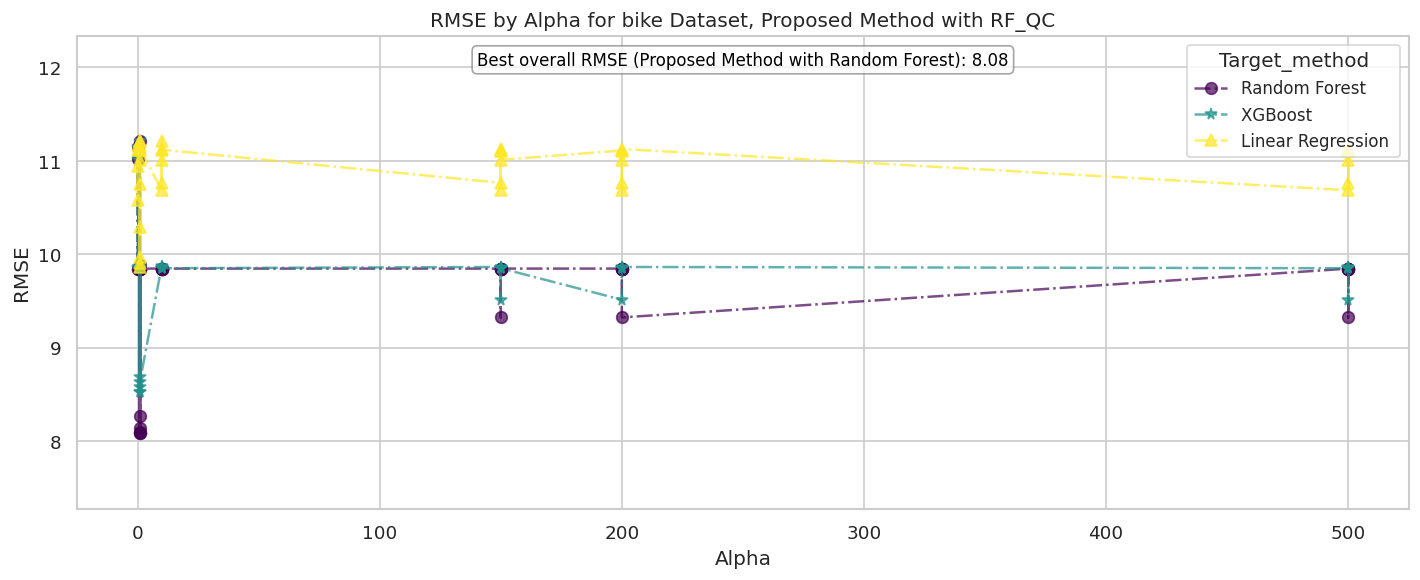

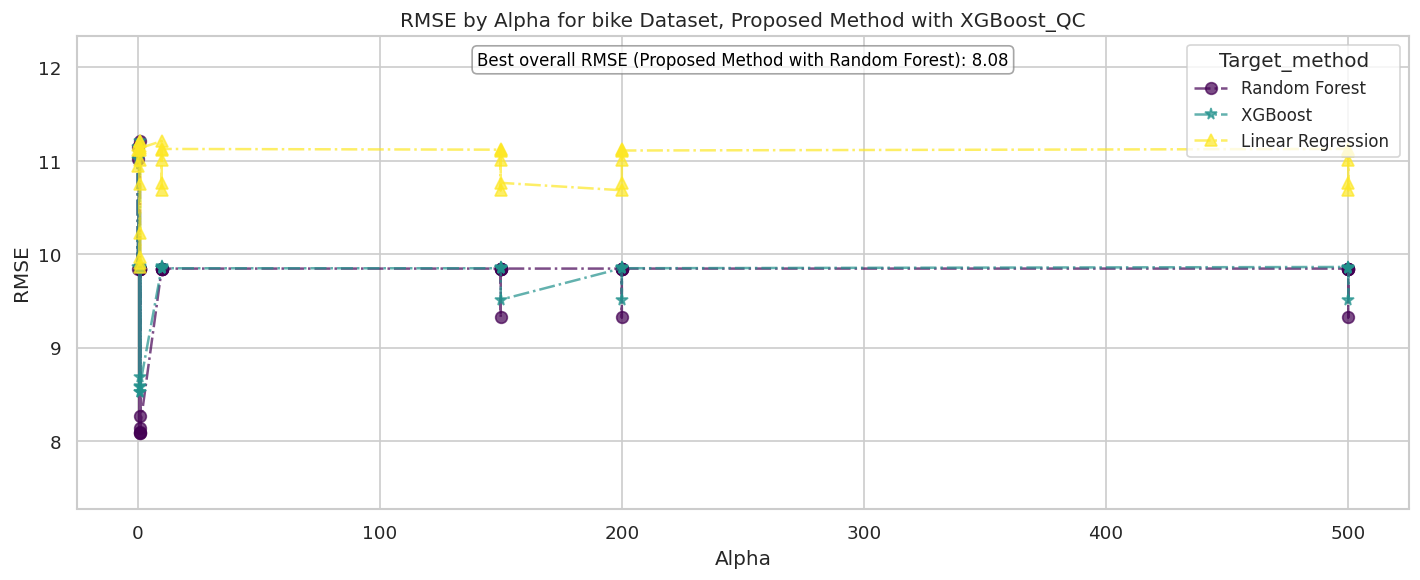

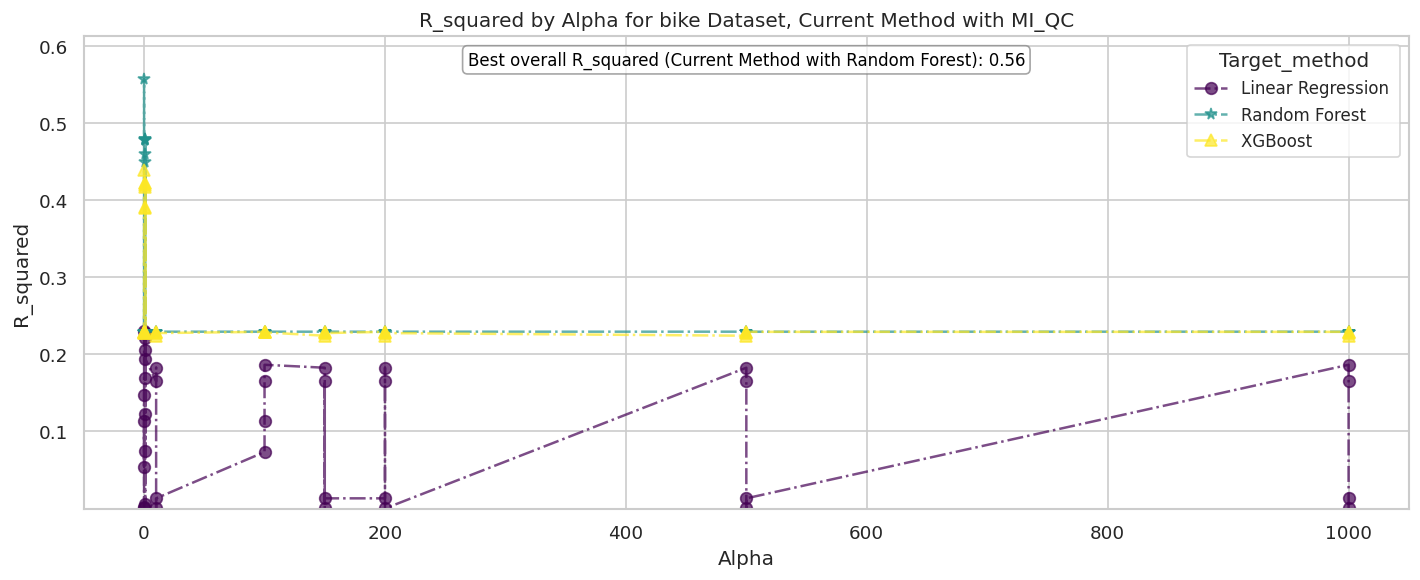

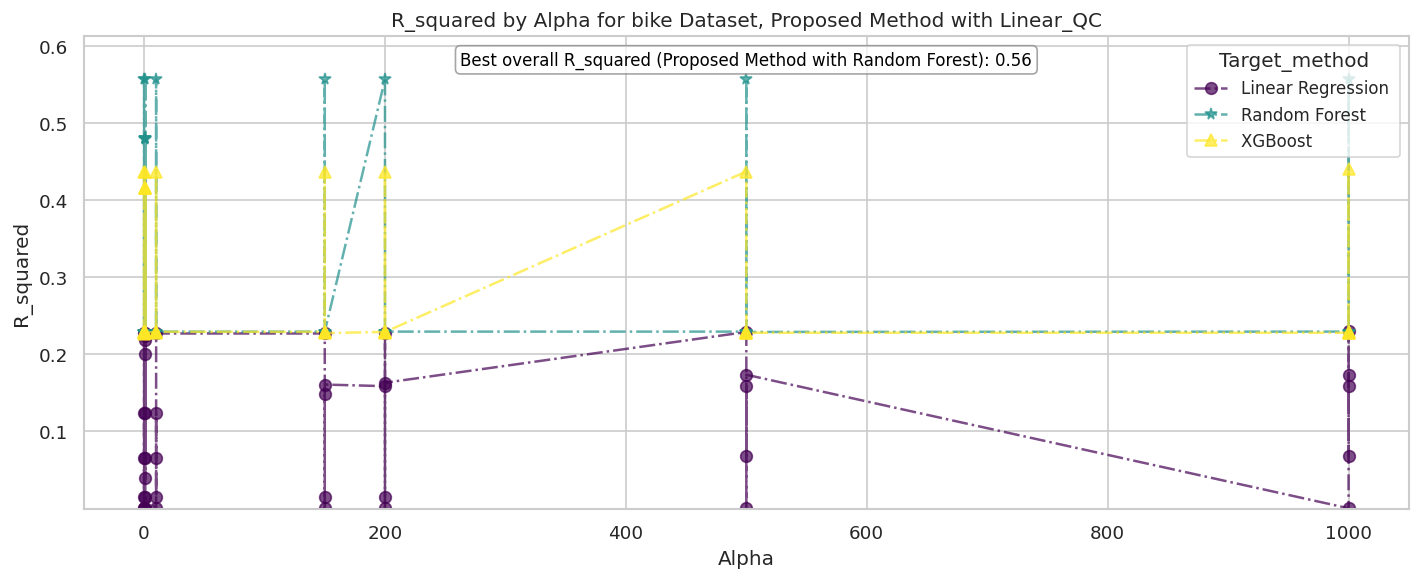

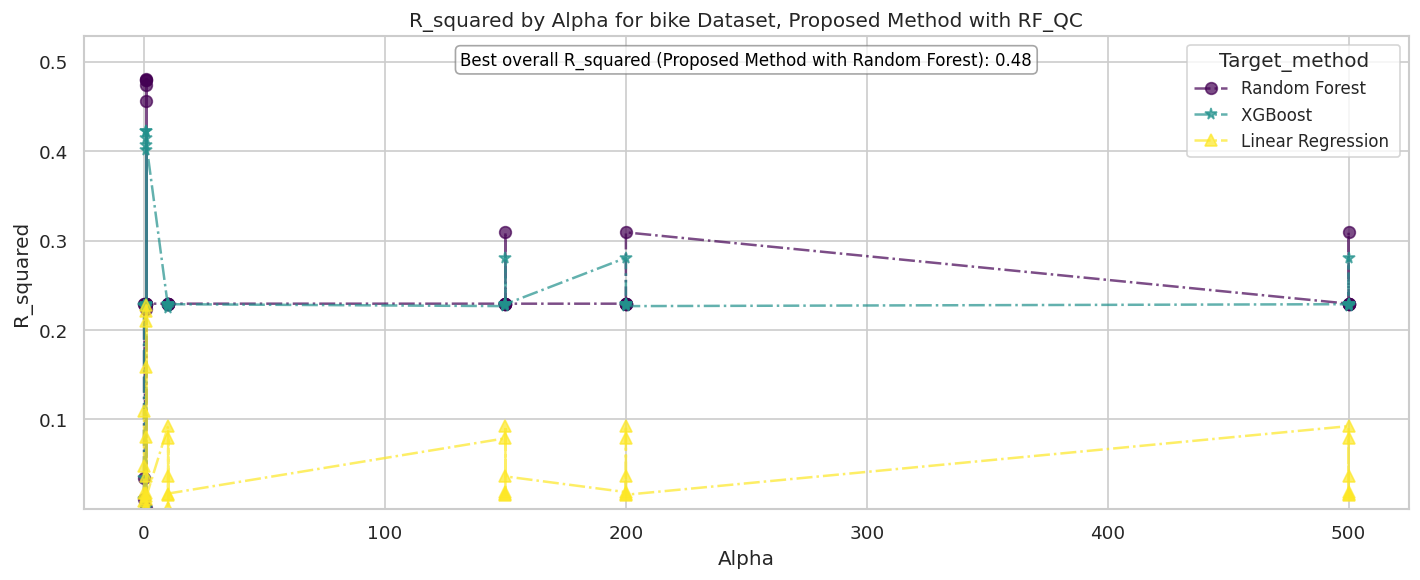

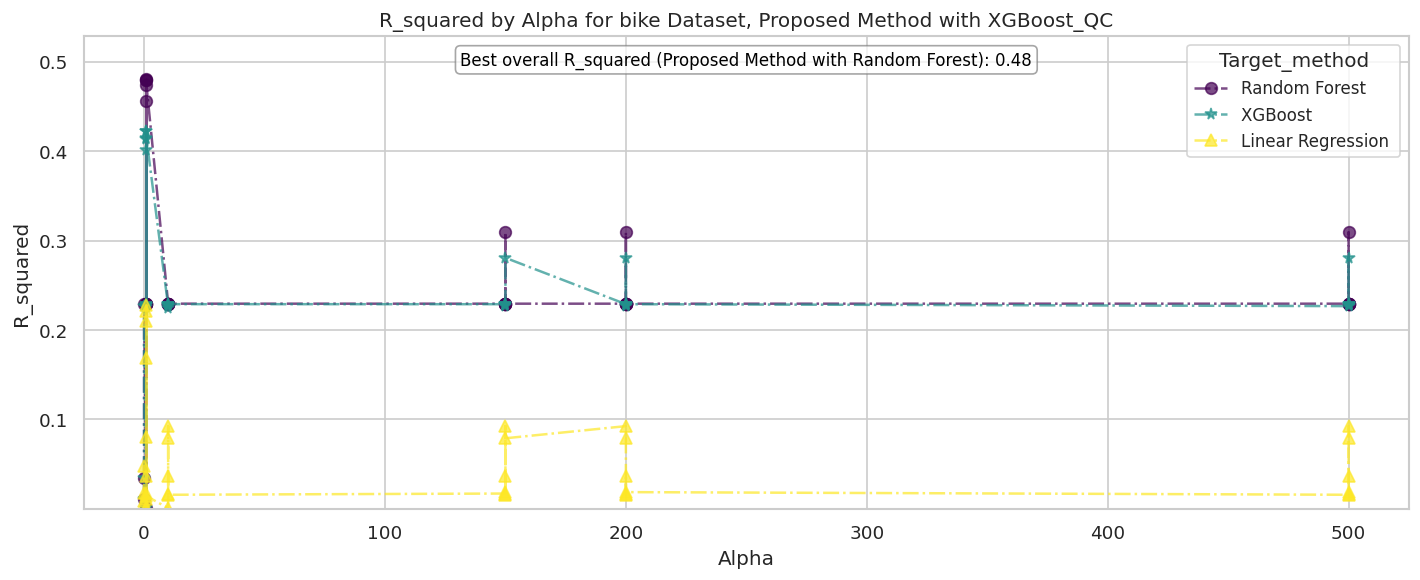

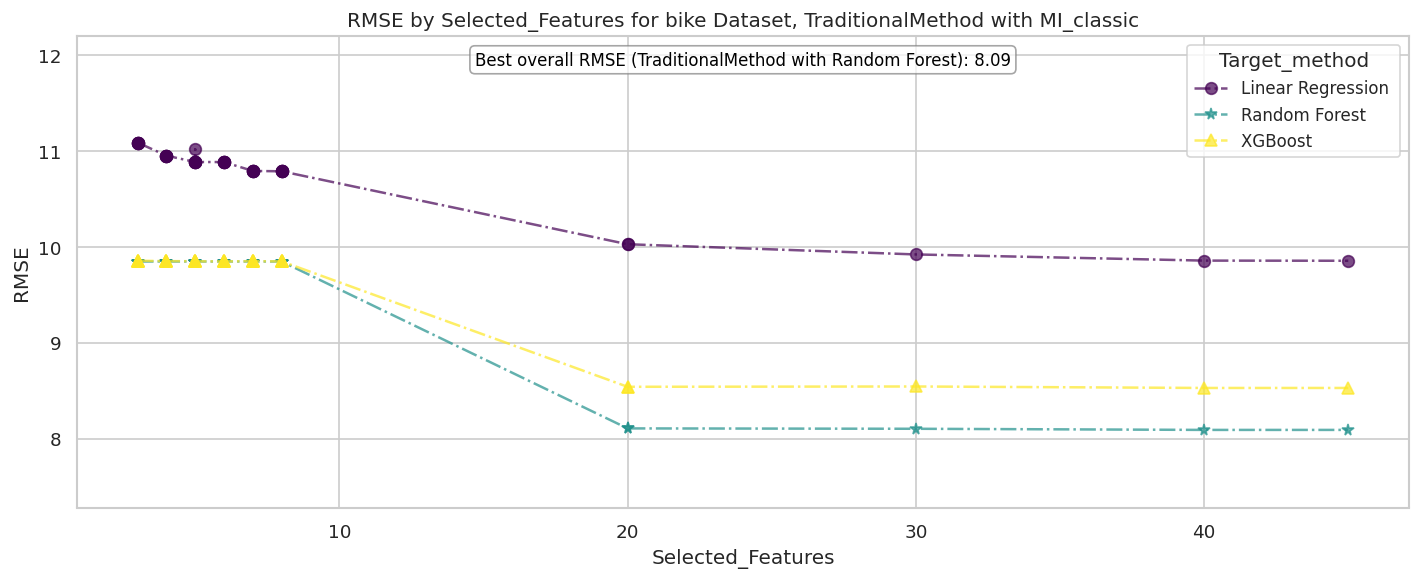

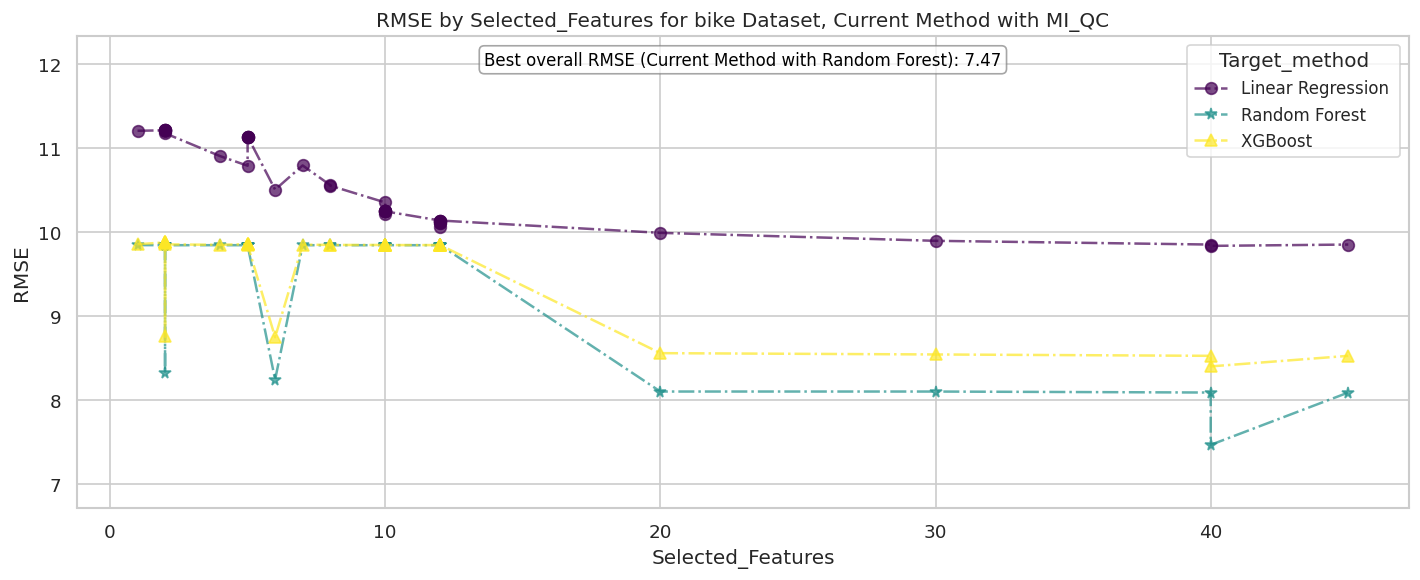

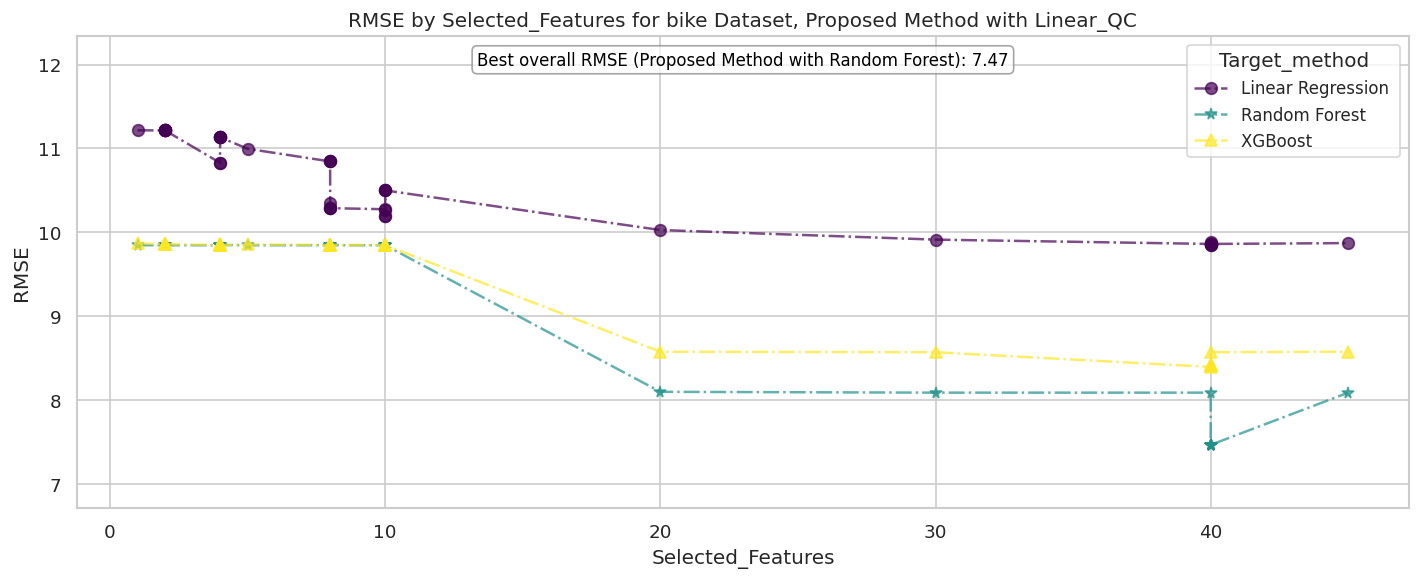

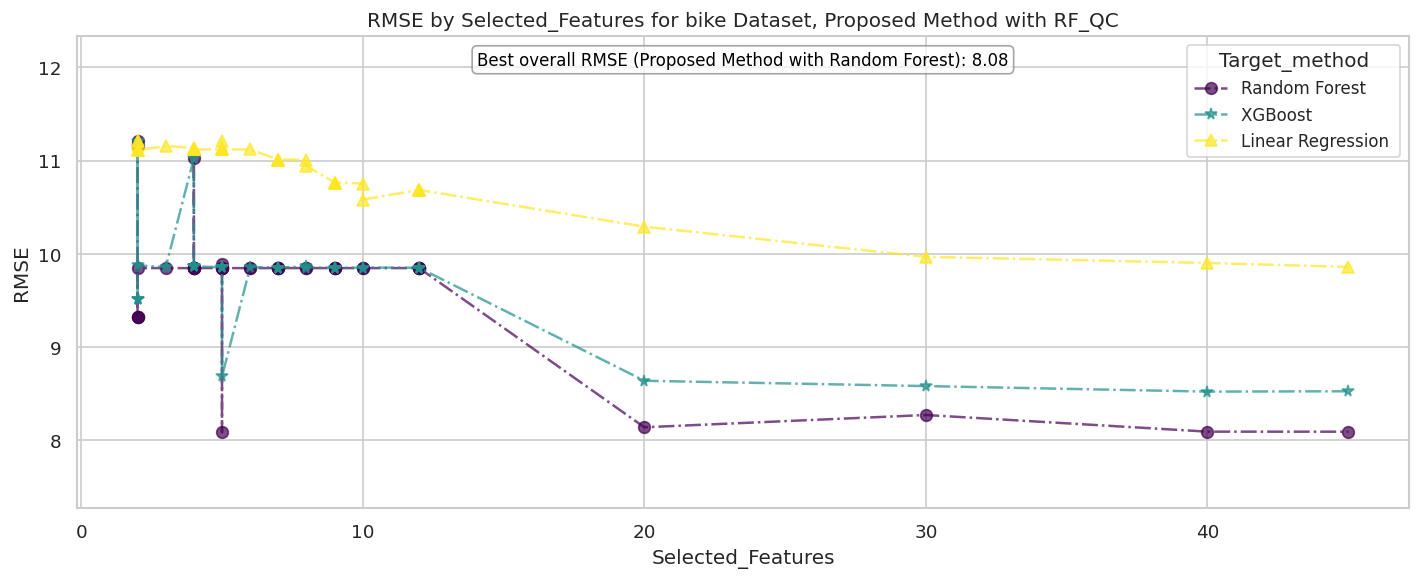

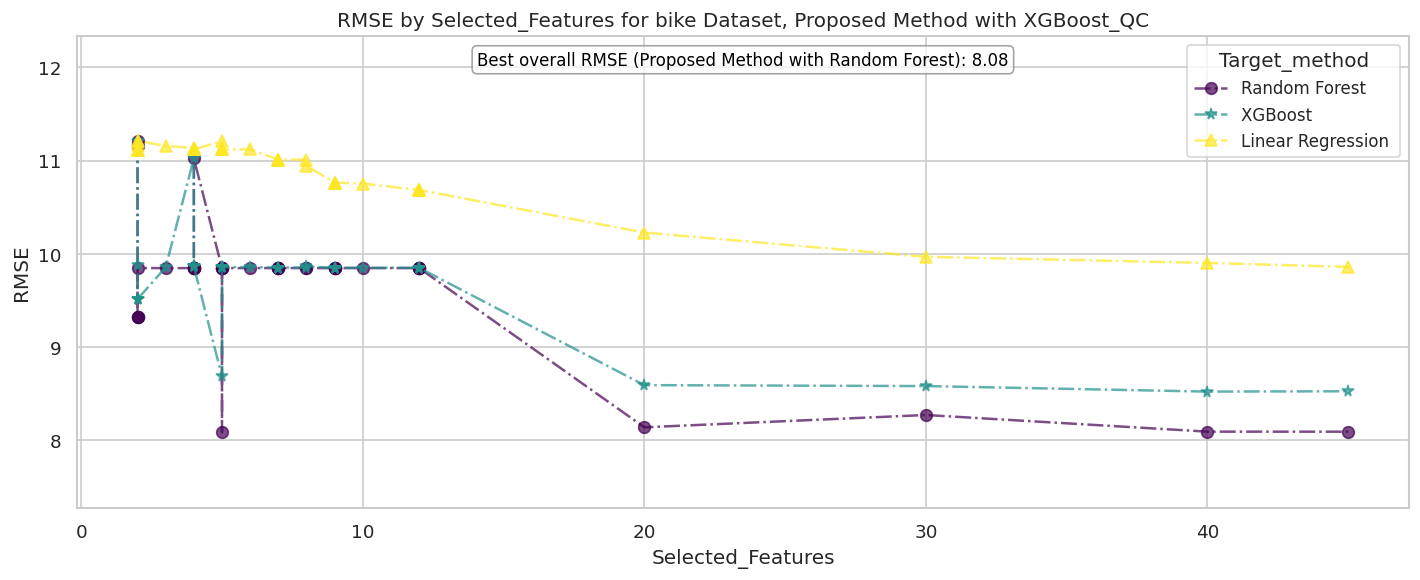

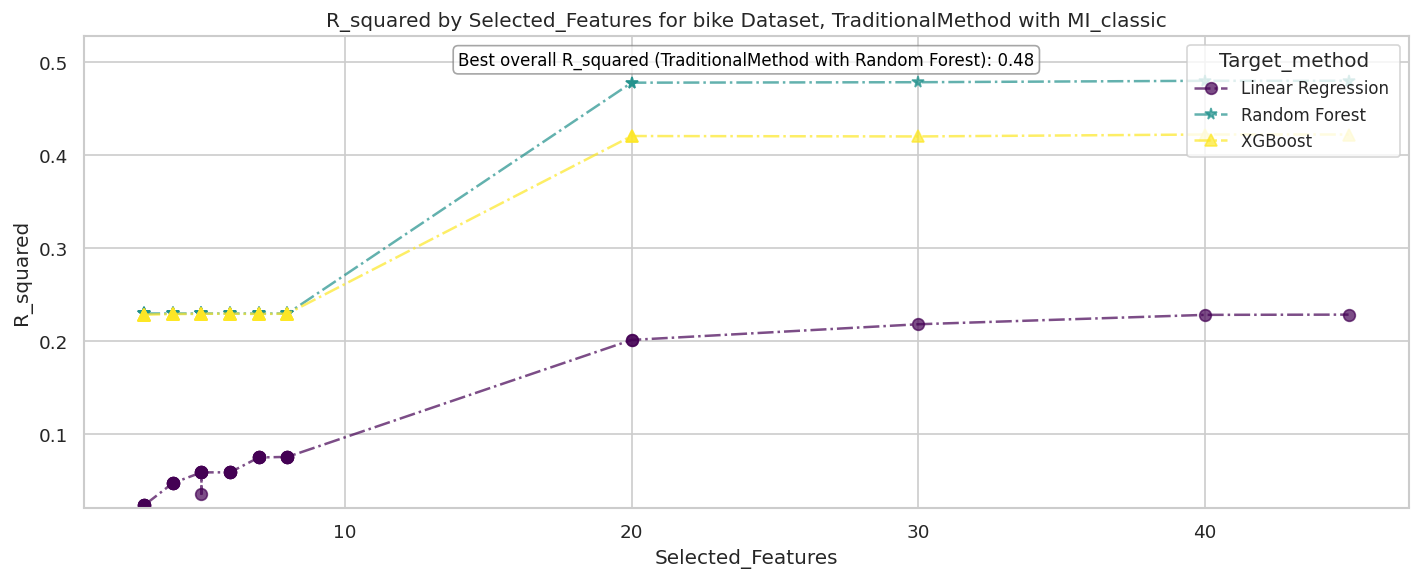

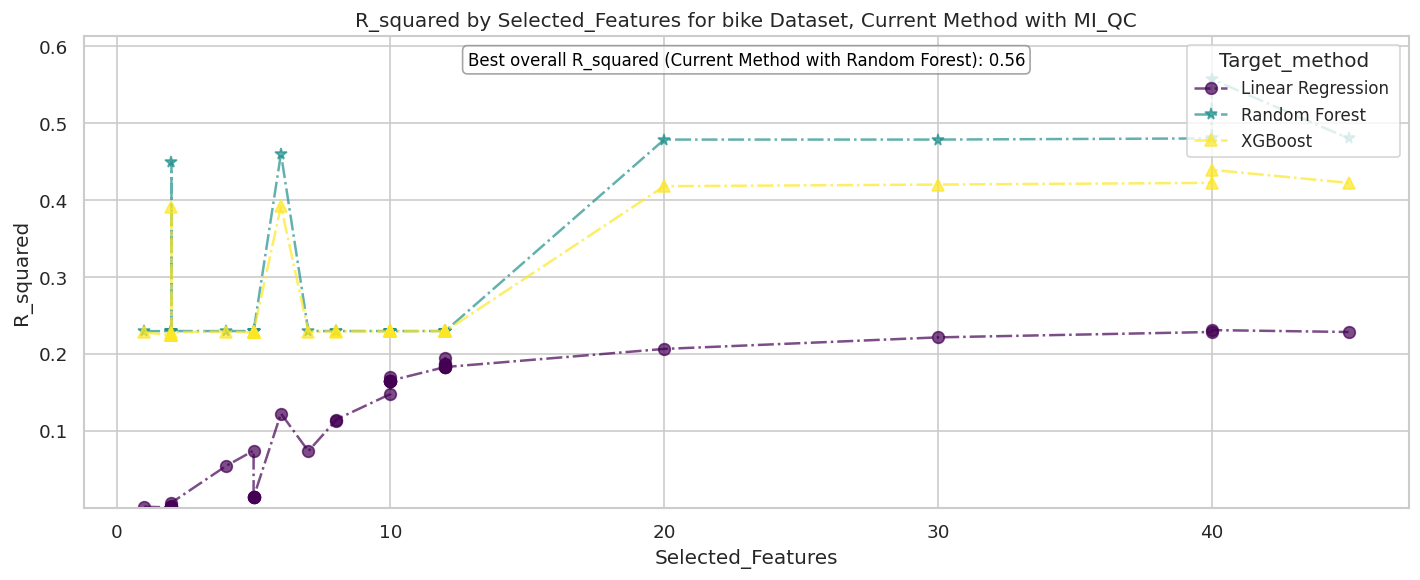

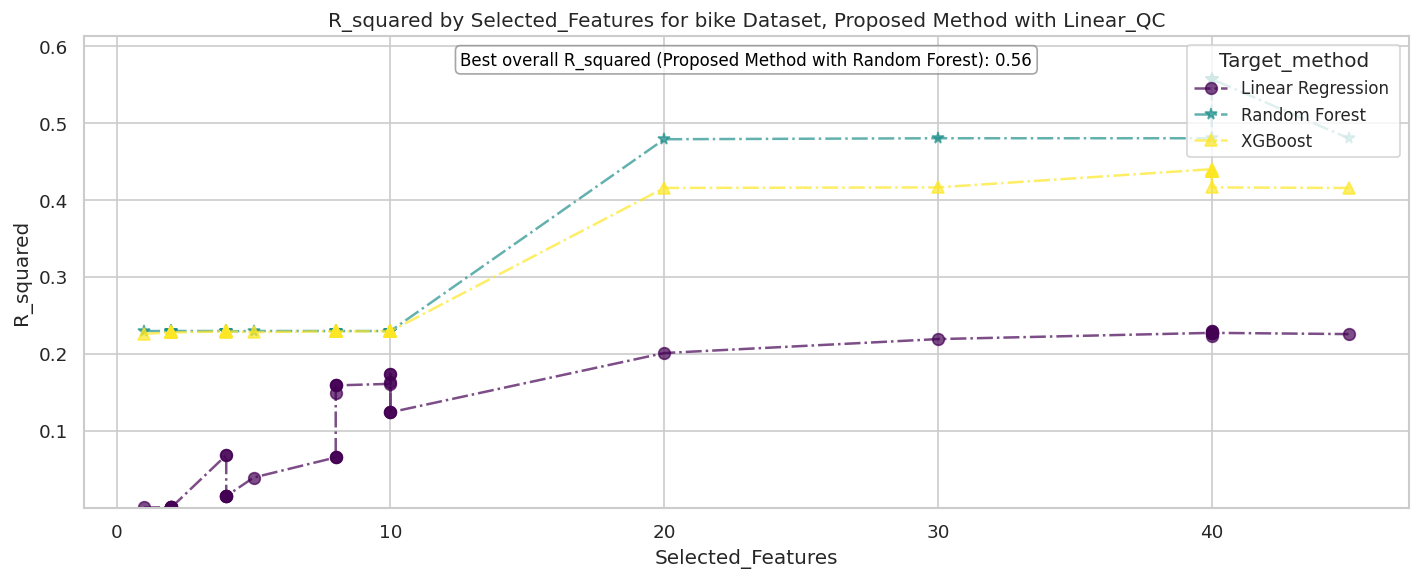

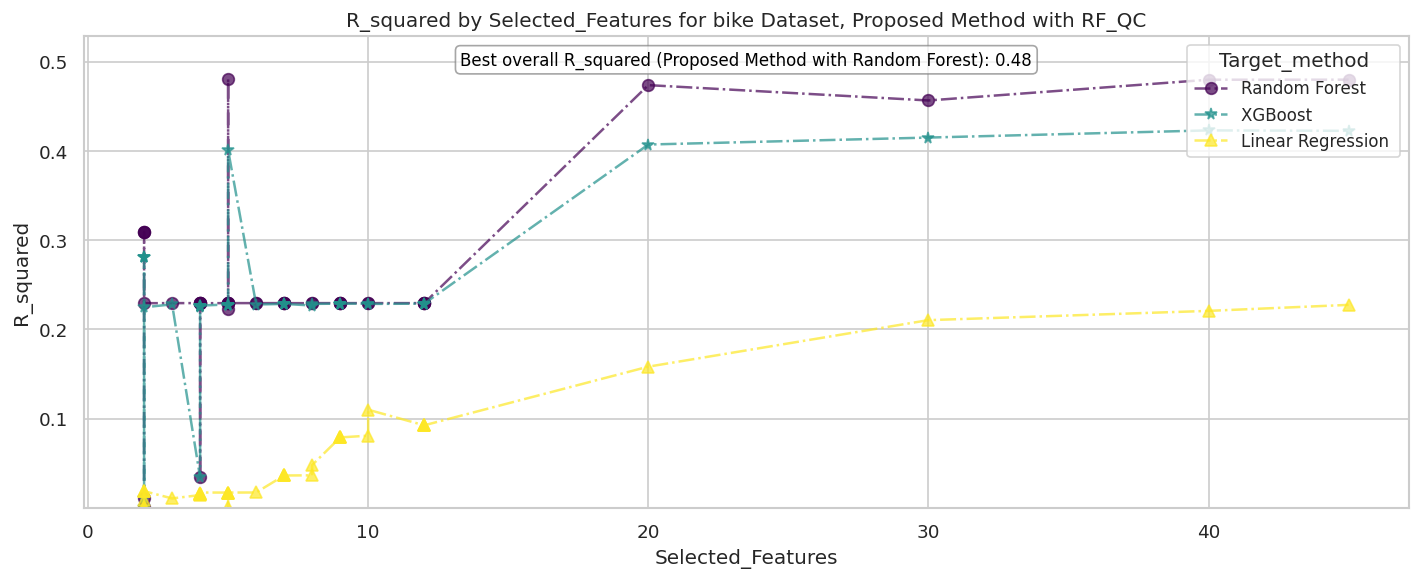

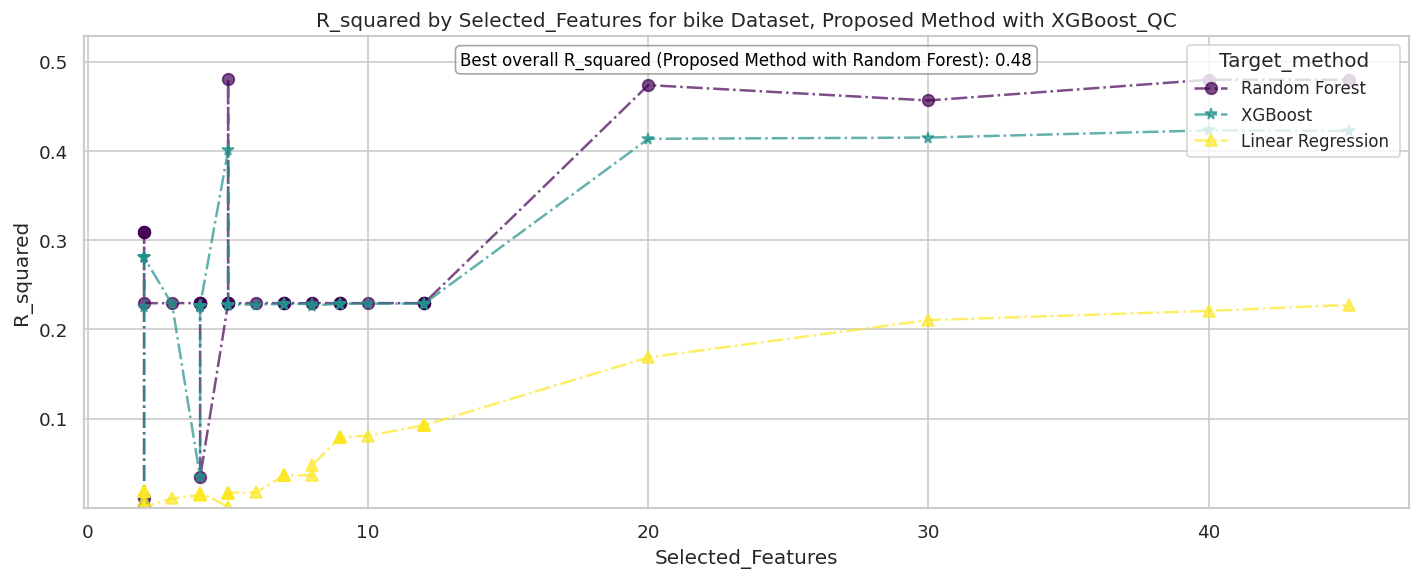

In [ ]:

# Load the data
df_results = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Predict BSS/Result_feature_selection/rmse_records.csv')
######################################################
wine_data = df_results[df_results['Dataset'] == 'wine']

plot_my_df(wine_data,'MI_QC', 'RMSE','Alpha', 'wine','Target_method')
plot_my_df(wine_data,'Linear_QC', 'RMSE','Alpha', 'wine','Target_method')
plot_my_df(wine_data,'RF_QC', 'RMSE','Alpha', 'wine','Target_method')
plot_my_df(wine_data,'XGBoost_QC', 'RMSE','Alpha', 'wine','Target_method')

plot_my_df(wine_data,'MI_QC', 'R_squared','Alpha',  'wine','Target_method')
plot_my_df(wine_data,'Linear_QC', 'R_squared','Alpha',  'wine','Target_method')
plot_my_df(wine_data,'RF_QC', 'R_squared','Alpha', 'wine','Target_method')
plot_my_df(wine_data,'XGBoost_QC', 'R_squared','Alpha', 'wine','Target_method')

plot_my_df(wine_data,'MI_classic', 'RMSE','Selected_Features', 'wine','Target_method')
plot_my_df(wine_data,'MI_QC', 'RMSE','Selected_Features', 'wine','Target_method')
plot_my_df(wine_data,'Linear_QC', 'RMSE','Selected_Features', 'wine','Target_method')
plot_my_df(wine_data,'RF_QC', 'RMSE','Selected_Features', 'wine','Target_method')
plot_my_df(wine_data,'XGBoost_QC', 'RMSE','Selected_Features', 'wine','Target_method')

plot_my_df(wine_data,'MI_classic', 'R_squared','Selected_Features',  'wine','Target_method')
plot_my_df(wine_data,'MI_QC', 'R_squared','Selected_Features',  'wine','Target_method')
plot_my_df(wine_data,'Linear_QC', 'R_squared','Selected_Features',  'wine','Target_method')
plot_my_df(wine_data,'RF_QC', 'R_squared','Selected_Features', 'wine','Target_method')
plot_my_df(wine_data,'XGBoost_QC', 'R_squared','Selected_Features', 'wine','Target_method')
######################################################
insurance_data = df_results[df_results['Dataset'] == 'insurance']
#insurance_data_Linear_QC = insurance_data[insurance_data['Similarity_method'] == 'Linear_QC']

plot_my_df(insurance_data,'MI_QC', 'RMSE','Alpha',  'insurance','Target_method')
plot_my_df(insurance_data,'Linear_QC', 'RMSE','Alpha',  'insurance','Target_method')
plot_my_df(insurance_data,'RF_QC', 'RMSE','Alpha',  'insurance','Target_method')
plot_my_df(insurance_data,'XGBoost_QC', 'RMSE','Alpha',  'insurance','Target_method')

plot_my_df(insurance_data,'MI_QC', 'R_squared','Alpha',  'insurance','Target_method')
plot_my_df(insurance_data,'Linear_QC', 'R_squared','Alpha',  'insurance','Target_method')
plot_my_df(insurance_data,'RF_QC', 'R_squared','Alpha',  'insurance','Target_method')
plot_my_df(insurance_data,'XGBoost_QC', 'R_squared','Alpha',  'insurance','Target_method')

plot_my_df(insurance_data,'MI_classic', 'RMSE','Selected_Features',  'insurance','Target_method')
plot_my_df(insurance_data,'MI_QC', 'RMSE','Selected_Features',  'insurance','Target_method')
plot_my_df(insurance_data,'Linear_QC', 'RMSE','Selected_Features',  'insurance','Target_method')
plot_my_df(insurance_data,'RF_QC', 'RMSE','Selected_Features',  'insurance','Target_method')
plot_my_df(insurance_data,'XGBoost_QC', 'RMSE','Selected_Features',  'insurance','Target_method')

plot_my_df(insurance_data,'MI_classic', 'R_squared','Selected_Features',  'insurance','Target_method')
plot_my_df(insurance_data,'MI_QC', 'R_squared','Selected_Features',  'insurance','Target_method')
plot_my_df(insurance_data,'Linear_QC', 'R_squared','Selected_Features',  'insurance','Target_method')
plot_my_df(insurance_data,'RF_QC', 'R_squared','Selected_Features',  'insurance','Target_method')
plot_my_df(insurance_data,'XGBoost_QC', 'R_squared','Selected_Features',  'insurance','Target_method')
######################################################
bike_data = df_results[df_results['Dataset'] == 'bike']
#bike_data_Linear_QC = bike_data[bike_data['Similarity_method'] == 'Linear_QC']

plot_my_df(bike_data,'MI_QC', 'RMSE','Alpha',  'bike','Target_method')
plot_my_df(bike_data,'Linear_QC', 'RMSE','Alpha',  'bike','Target_method')
plot_my_df(bike_data,'RF_QC', 'RMSE','Alpha',  'bike','Target_method')
plot_my_df(bike_data,'XGBoost_QC', 'RMSE','Alpha',  'bike','Target_method')

plot_my_df(bike_data,'MI_QC', 'R_squared', 'Alpha', 'bike','Target_method')
plot_my_df(bike_data,'Linear_QC', 'R_squared', 'Alpha', 'bike','Target_method')
plot_my_df(bike_data,'RF_QC', 'R_squared', 'Alpha', 'bike','Target_method')
plot_my_df(bike_data,'XGBoost_QC', 'R_squared', 'Alpha', 'bike','Target_method')

plot_my_df(bike_data,'MI_classic', 'RMSE','Selected_Features',  'bike','Target_method')
plot_my_df(bike_data,'MI_QC', 'RMSE','Selected_Features',  'bike','Target_method')
plot_my_df(bike_data,'Linear_QC', 'RMSE','Selected_Features',  'bike','Target_method')
plot_my_df(bike_data,'RF_QC', 'RMSE','Selected_Features',  'bike','Target_method')
plot_my_df(bike_data,'XGBoost_QC', 'RMSE','Selected_Features',  'bike','Target_method')

plot_my_df(bike_data,'MI_classic', 'R_squared', 'Selected_Features', 'bike','Target_method')
plot_my_df(bike_data,'MI_QC', 'R_squared', 'Selected_Features', 'bike','Target_method')
plot_my_df(bike_data,'Linear_QC', 'R_squared', 'Selected_Features', 'bike','Target_method')
plot_my_df(bike_data,'RF_QC', 'R_squared', 'Selected_Features', 'bike','Target_method')
plot_my_df(bike_data,'XGBoost_QC', 'R_squared', 'Selected_Features', 'bike','Target_method')

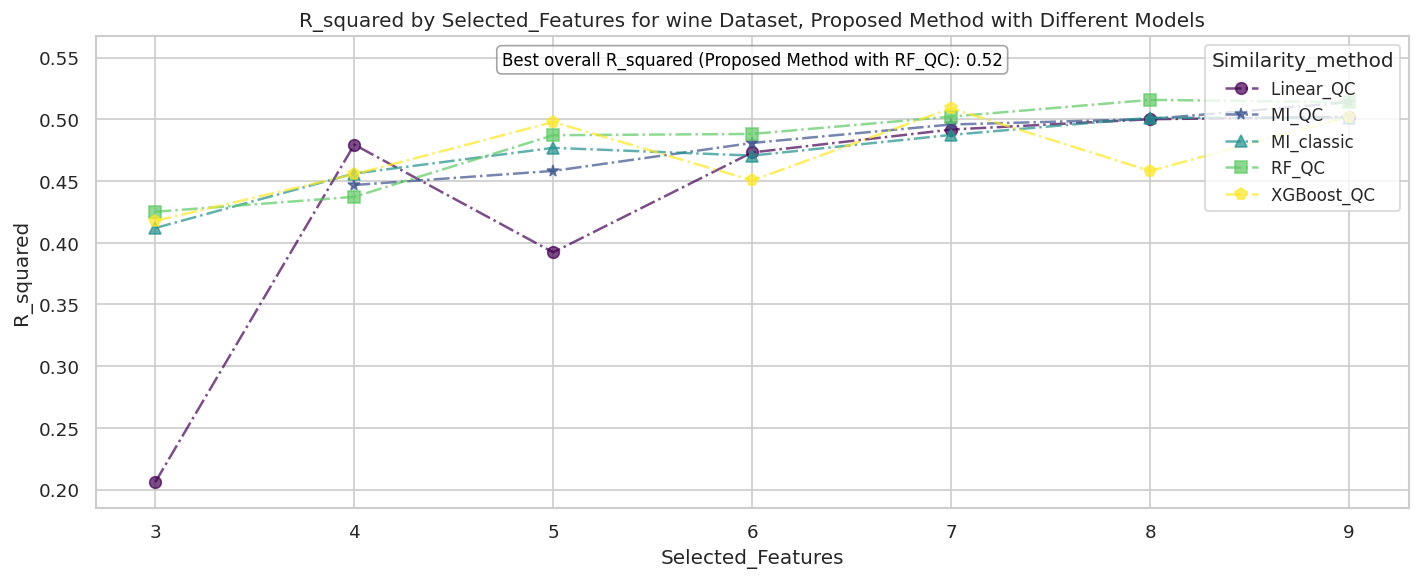

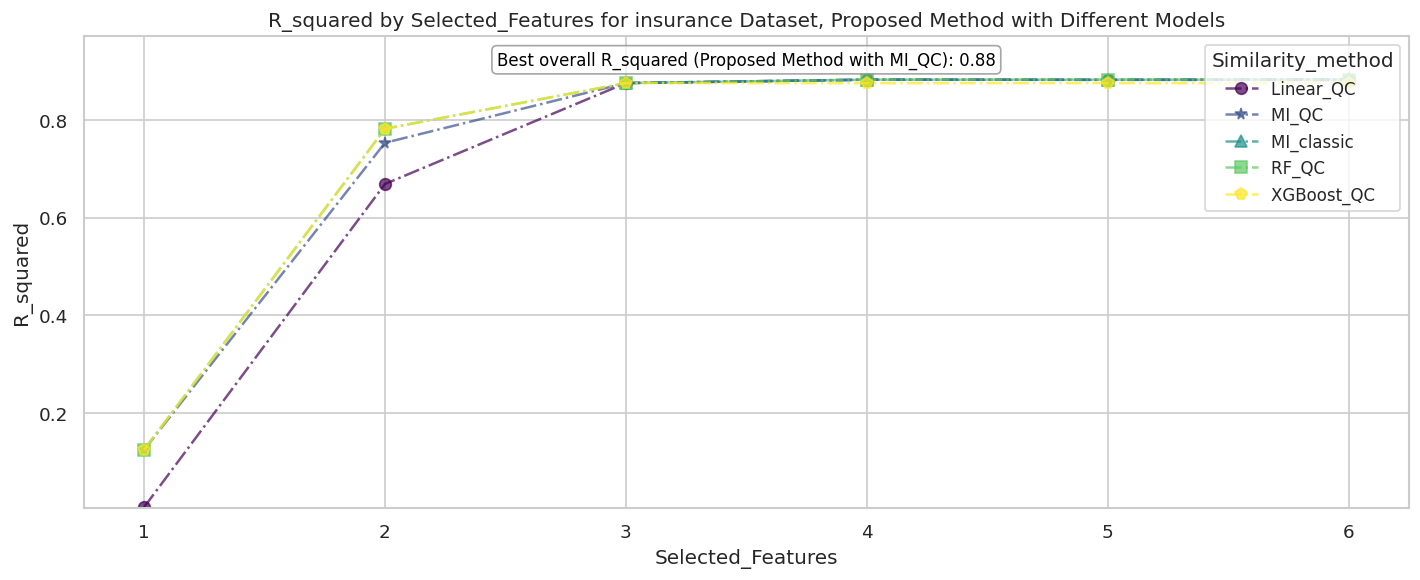

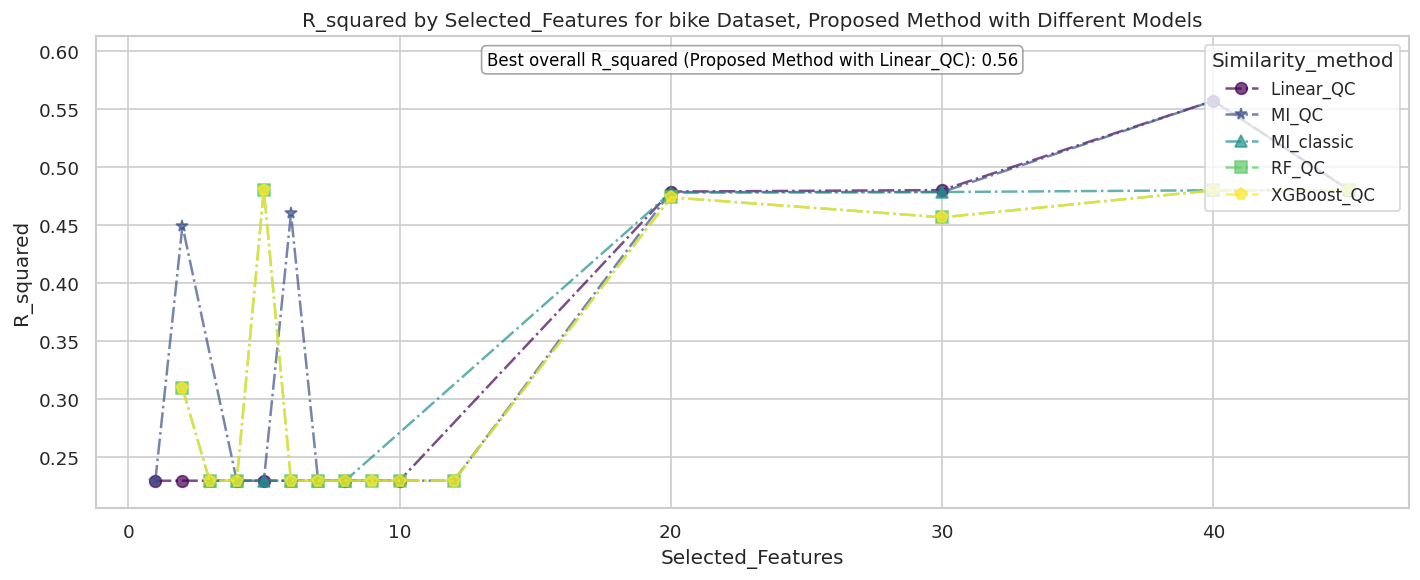

In [ ]:
result_df = df_results.groupby(['Similarity_method', 'Dataset', 'Selected_Features'])['R_squared'].max().reset_index()

wine_data = result_df[result_df['Dataset'] == 'wine']
plot_my_df(wine_data,'Different Models', 'R_squared','Selected_Features', 'wine','Similarity_method', 'grouped')
########################################################
insurance_data = result_df[result_df['Dataset'] == 'insurance']
plot_my_df(insurance_data,'Different Models', 'R_squared','Selected_Features', 'insurance','Similarity_method', 'grouped')

#######################################################
bike_data = result_df[result_df['Dataset'] == 'bike']
plot_my_df(bike_data,'Different Models', 'R_squared','Selected_Features', 'bike','Similarity_method', 'grouped')

In [ ]:
### Create tables
df_results = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Predict BSS/Result_feature_selection/rmse_records.csv')
def df_to_latex(df, label, caption):
    df['Selected_Features'] = df['Selected_Features'].astype(int)
    df.rename(columns={'Selected_Features': 'Features'}, inplace=True)
    df.columns = [col.replace('_', '\\_') for col in df.columns]
    body = df.to_latex(index=False, na_rep='', float_format="%.4f", header=False)
    body = body.replace("\\\\", "\\\\\n")  # Ensure proper line breaks
    body = body.split('\n', 2)[2].rsplit('\n', 2)[0]
    header = (
        "\\begin{table}[ht]\n"
        "\\centering\n"
        f"\\caption{{{caption}}}\n"
        f"\\label{{{label}}}\n"
        "\\begin{tabular}{lcc|ccc}\n"
        "\\toprule\n"
        " & & & \\multicolumn{3}{c}{Proposed Method} \\\\\n"
        "Features & MI\\_classic & MI\\_QC & Linear\\_QC & RF\\_QC & XGBoost\\_QC \\\\\n"
        "\\midrule\n"
    )
    footer = "\\bottomrule\n\\end{tabular}\n\\end{table}"
    latex_code = header + body + footer
    return latex_code

new_order = ['Selected_Features', 'MI_classic','MI_QC', 'Linear_QC', 'RF_QC', 'XGBoost_QC']

#############################Wine##############################################
wine_data = df_results[df_results['Dataset'] == 'wine']
wine_data_grouped_rsquared = wine_data.groupby(['Similarity_method', 'Dataset', 'Selected_Features'])['R_squared'].max().reset_index()
pivot_df_rsquared = wine_data_grouped_rsquared.pivot(index='Selected_Features', columns='Similarity_method', values='R_squared')
pivot_df_rsquared.reset_index(inplace=True)
pivot_df_rsquared = pivot_df_rsquared[new_order]
label_rsquared_wine = "tab:wineRsquared"
caption_rsquared_wine = "$R^2$ of the FS for traditional and proposed methods."
pivot_df_rsquared_latex = df_to_latex(pivot_df_rsquared, label_rsquared_wine, caption_rsquared_wine)
print("Latex table=", pivot_df_rsquared_latex)

wine_data_grouped_rmse = wine_data.groupby(['Similarity_method', 'Dataset', 'Selected_Features'])['RMSE'].min().reset_index()
pivot_df_rmse  = wine_data_grouped_rmse.pivot(index='Selected_Features', columns='Similarity_method', values='RMSE')
pivot_df_rmse .reset_index(inplace=True)
pivot_df_rmse = pivot_df_rmse[new_order]
label_rmse_wine = "tab:wineRMSE"
caption_rmse_wine = "$RMSE$ of the FS for traditional and proposed methods."
pivot_df_rmse_latex = df_to_latex(pivot_df_rmse, label_rmse_wine, caption_rmse_wine)
print("Latex table=", pivot_df_rmse_latex)
###############################insurance########################################
insurance_data = df_results[df_results['Dataset'] == 'insurance']
insurance_data_grouped_rsquared = insurance_data.groupby(['Similarity_method', 'Dataset', 'Selected_Features'])['R_squared'].max().reset_index()
pivot_df_insurance_rsquared = insurance_data_grouped_rsquared.pivot(index='Selected_Features', columns='Similarity_method', values='R_squared')
pivot_df_insurance_rsquared.reset_index(inplace=True)
pivot_df_insurance_rsquared = pivot_df_insurance_rsquared[new_order]
label_rsquared_insu = "tab:insuranceRsquared"
caption_rsquared_insu = "$R^2$ of the FS for traditional and proposed methods."
pivot_df_insurance_rsquared_latex = df_to_latex(pivot_df_insurance_rsquared, label_rsquared_insu,caption_rsquared_insu)

insurance_data_grouped_rmse = insurance_data.groupby(['Similarity_method', 'Dataset', 'Selected_Features'])['RMSE'].min().reset_index()
pivot_df_insurance_rmse  = insurance_data_grouped_rmse.pivot(index='Selected_Features', columns='Similarity_method', values='RMSE')
pivot_df_insurance_rmse .reset_index(inplace=True)
pivot_df_insurance_rmse = pivot_df_insurance_rmse[new_order]
label_rmse_insu = "tab:insuranceRMSE"
caption_rmse_insu = "$RMSE$ of the FS for traditional and proposed methods."
pivot_df_insurance_rmse_latex = df_to_latex(pivot_df_insurance_rmse,label_rmse_insu, caption_rmse_insu)

############################ bike #############################################
bike_data = df_results[df_results['Dataset'] == 'bike']
bike_data_grouped_rsquared = bike_data.groupby(['Similarity_method', 'Dataset', 'Selected_Features'])['R_squared'].max().reset_index()
pivot_df_bike_rsquared = bike_data_grouped_rsquared.pivot(index='Selected_Features', columns='Similarity_method', values='R_squared')
pivot_df_bike_rsquared.reset_index(inplace=True)
pivot_df_bike_rsquared = pivot_df_bike_rsquared[new_order]
label_rsquared_bike = "tab:bikeRsquared"
caption_rsquared_bike = "$R^2$ of the FS for traditional and proposed methods."
pivot_df_bike_rsquared_latex = df_to_latex(pivot_df_bike_rsquared, label_rsquared_bike, caption_rsquared_bike)

bike_data_grouped_rmse = bike_data.groupby(['Similarity_method', 'Dataset', 'Selected_Features'])['RMSE'].min().reset_index()
pivot_df_bike_rmse  = bike_data_grouped_rmse.pivot(index='Selected_Features', columns='Similarity_method', values='RMSE')
pivot_df_bike_rmse .reset_index(inplace=True)
pivot_df_bike_rmse = pivot_df_bike_rmse[new_order]
label_rmse_bike = "tab:bikeRMSE"
caption_rmse_bike = "$RMSE$ of the FS for traditional and proposed methods."
pivot_df_bike_rmse_latex = df_to_latex(pivot_df_bike_rmse, label_rmse_bike, caption_rmse_bike)


Latex table= \begin{table}[ht]
\centering
\caption{$R^2$ of the FS for traditional and proposed methods.}
\label{tab:wineRsquared}
\begin{tabular}{lcc|ccc}
\toprule
 & & & \multicolumn{3}{c}{Proposed Method} \\
Features & MI\_classic & MI\_QC & Linear\_QC & RF\_QC & XGBoost\_QC \\
\midrule
\midrule
3 & 0.4119 &  & 0.2062 & 0.4251 & 0.4177 \\

4 & 0.4560 & 0.4467 & 0.4794 & 0.4372 & 0.4555 \\

5 & 0.4768 & 0.4582 & 0.3922 & 0.4871 & 0.4978 \\

6 & 0.4706 & 0.4808 & 0.4731 & 0.4881 & 0.4505 \\

7 & 0.4873 & 0.4958 & 0.4916 & 0.5021 & 0.5089 \\

8 & 0.5012 & 0.5001 & 0.5000 & 0.5157 & 0.4581 \\

9 & 0.5013 & 0.5138 & 0.5020 & 0.5138 & 0.5020 \\

\bottomrule\bottomrule
\end{tabular}
\end{table}
Latex table= \begin{table}[ht]
\centering
\caption{$RMSE$ of the FS for traditional and proposed methods.}
\label{tab:wineRMSE}
\begin{tabular}{lcc|ccc}
\toprule
 & & & \multicolumn{3}{c}{Proposed Method} \\
Features & MI\_classic & MI\_QC & Linear\_QC & RF\_QC & XGBoost\_QC \\
\midrule
\midrule
3 &